In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
import random
from models_adni import ModelA, ModelB
from hyperparameter_options import params_baseline as hyperparams

In [7]:
gpu = 5
multi_gpus = None #[0, 1, 2]
zero_one_normalize = False
dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
# path to be used for all data sets
train_data_path = "/ritter/share/data/ADNI_HDF5/Splits_Eitel/10xrandom_splits/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_random_state"

In [10]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = z_factor
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [11]:
augmentations = [SagittalFlip(), SagittalTranslate(dist=(-2, 3))]

In [12]:
def pick_model(name):
    if name == "ModelA":
        net = ModelA()
    elif name == "ModelB":
        net = ModelB()
    elif name == "ModelAPIF":
        net = ModelAPIF()
    elif name == "ModelBPIF":
        net = ModelBPIF()
    return net

def update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold_idx):
    outer_fold_best["final_acc"] = report["val_metrics"][retain_metric][-1]
    outer_fold_best["best_acc"] = np.max(report["val_metrics"][retain_metric][ignore_epochs:])
    outer_fold_best["final_iter"] = len(report["val_metrics"][retain_metric])
    outer_fold_best["best_iter"] = outer_fold_best["final_iter"] - np.argmax(np.flip(np.copy(report["val_metrics"][retain_metric])))
    outer_fold_best["params"] = selected_hyperparams
    outer_fold_best["inner_fold_idx"] = inner_fold_idx
    return outer_fold_best

# Training

In [13]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    all_outer_bests = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    random_states = np.arange(20, 30) # will be used again to split in testing phase
    
    for outer_fold, r in enumerate(random_states):
        print("###### Starting outer fold {}".format(outer_fold))
        # load data sets
        train_h5 = h5py.File(train_data_path + str(r) + ".h5", 'r')
        val_h5 = h5py.File(train_data_path.replace("train", "val") + str(r) + ".h5", 'r')
        
        X_train, y_train = np.array(train_h5['X']), np.array(train_h5['y'])
        X_val, y_val = val_h5['X'], val_h5['y']
    
        # select only 20 % 
        #new_ind, _ = train_test_split(np.arange(len(X_train)), train_size=0.2, random_state=42)
        X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)
        #X_train = X_train[new_ind]
        #y_train = y_train[new_ind]

        # dataset overview
        y = np.concatenate([np.array(y_train), np.array(y_val)])
        print("# of patients {}, # of healthy controls {}".format(np.sum(y), len(y)-np.sum(y)))

        print(len(y_train))
        print(len(y_val))
        
        if zero_one_normalize:
            intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
            adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask, dtype=dtype)
            adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
        else:
            adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask, dtype=dtype)
            adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
        train_h5.close()
        val_h5.close()
        
        outer_fold_best = {
            "final_acc" : 0,
            "best_acc" : 0,
            "final_iter" : 0,
            "best_iter" : 0,
            "params" : {},
            "inner_fold_idx" : 0
        }
        
        for inner_fold in range(5):
            print("###### Starting inner fold {}".format(inner_fold))
            # sample randomly from the hyperparameter options each inner fold
            b = random.choice(hyperparams["batch_size"])
            patience = random.choice(hyperparams["patience"]["small"])
            lr = random.choice(hyperparams["lr"])
            
            # force each model architecture to occur twice
            if inner_fold < 2:
                model_name = "ModelA"
            elif inner_fold < 4:
                model_name = "ModelB"
            else:
                # only choose model randomly in the last run
                model_name = random.choice(hyperparams["model"])

            selected_hyperparams = {
                "model" : model_name,
                "batch_size" : b,
                "patience" : patience,
                "lr" : lr
                }
            print(selected_hyperparams)
            
            # load model
            if multi_gpus is None:
                net = pick_model(model_name).cuda(gpu)
            else:
                net = torch.nn.DataParallel(pick_model(model_name), device_ids=multi_gpus).cuda(gpu)
            
            print("Trainable model parameters: {}".format(count_parameters(net)))
        
            callbacks = [EarlyStopping(patience=patience, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
                         ModelCheckpoint(path=output_dir,
                                         prepend="outer_{}_inner_{}".format(outer_fold, inner_fold),
                                         store_best=True,
                                         ignore_before=ignore_epochs,
                                         retain_metric=retain_metric)]
        
            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
                        initial_prepend = None
            fold += 1
            
            # set optimizer
            wd = 1e-4
            criterion = nn.BCEWithLogitsLoss().cuda(gpu)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
            
            train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, shuffle=True
            )
            val_loader = DataLoader(
                adni_data_val, batch_size=1, num_workers=1, shuffle=True
            )
        
            trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=gpu
            )
            # train model and store results
            net, report = trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=10,
                show_validation_epochs=1,
            )
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric][-10:])
                fold_metric.append(report["val_metrics"][retain_metric][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold)
            else:
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric.__name__][-10:])
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric.__name__][-1] > outer_fold_best["final_acc"]:
                if best_val > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric.__name__, selected_hyperparams, inner_fold)

            models.append(net)        
            print("Finished inner fold.")

            # visualize result
            trainer.visualize_training(report, metrics)
            trainer.evaluate_model(val_loader, gpu)
        print("Finished outer fold.")
        print(outer_fold_best)
        all_outer_bests.append(outer_fold_best)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    print(all_outer_bests)
    return fold_metric, models


In [14]:
num_epochs = 200
min_iters = 3
ignore_epochs = 25
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy, auc_score]

In [15]:
r = 0

In [16]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/20_percent/10xrandom_splits/baseline/"

###### Starting outer fold 0


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# of patients 128, # of healthy controls 118
139
107
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.68430
[0,    20] loss: 0.70466
Time elapsed: 0h:0m:2s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.699567
[1,    10] loss: 0.69473
[1,    20] loss: 0.68866
Time elapsed: 0h:0m:6s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700760
[2,    10] loss: 0.69801
[2,    20] loss: 0.67962
Time elapsed: 0h:0m:10s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704556
[3,    10] loss: 0.68615
[3,  

val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.714957
[31,    10] loss: 0.67339
[31,    20] loss: 0.68112
Time elapsed: 0h:2m:8s
train accuracy_score: 57.55 %
train balanced_accuracy: 51.03 %
train auc_score: 51.03 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.707917
[32,    10] loss: 0.68945
[32,    20] loss: 0.71004
Time elapsed: 0h:2m:12s
train accuracy_score: 51.80 %
train balanced_accuracy: 47.57 %
train auc_score: 47.57 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694725
[33,    10] loss: 0.68576
[33,    20] loss: 0.67475
Time elapsed: 0h:2m:16s
train accuracy_score: 58.27 %
train balanced_accuracy: 52.07 %
train auc_score: 52.07 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.703032
[34,    10] loss: 0.67163
[34,    20] loss: 0.68165
Time elapsed: 0h:2m:21s
train accuracy_score: 56.83 %

val accuracy_score: 50.47 %
val balanced_accuracy: 54.15 %
val auc_score: 54.15 %
Val loss: 0.668404
[62,    10] loss: 0.62432
[62,    20] loss: 0.68394
Time elapsed: 0h:4m:15s
train accuracy_score: 61.15 %
train balanced_accuracy: 55.40 %
train auc_score: 55.40 %
val accuracy_score: 70.09 %
val balanced_accuracy: 70.04 %
val auc_score: 70.04 %
Val loss: 0.639816
[63,    10] loss: 0.63751
[63,    20] loss: 0.60177
Time elapsed: 0h:4m:19s
train accuracy_score: 69.78 %
train balanced_accuracy: 70.21 %
train auc_score: 70.21 %
val accuracy_score: 68.22 %
val balanced_accuracy: 68.00 %
val auc_score: 68.00 %
Val loss: 0.631829
[64,    10] loss: 0.66185
[64,    20] loss: 0.64201
Time elapsed: 0h:4m:23s
train accuracy_score: 64.75 %
train balanced_accuracy: 62.77 %
train auc_score: 62.77 %
val accuracy_score: 64.49 %
val balanced_accuracy: 66.77 %
val auc_score: 66.77 %
Val loss: 0.647827
[65,    10] loss: 0.67454
[65,    20] loss: 0.61779
Time elapsed: 0h:4m:28s
train accuracy_score: 64.03 

val accuracy_score: 71.96 %
val balanced_accuracy: 71.29 %
val auc_score: 71.29 %
Val loss: 0.528491
[93,    10] loss: 0.43150
[93,    20] loss: 0.57220
Time elapsed: 0h:6m:22s
train accuracy_score: 76.26 %
train balanced_accuracy: 74.30 %
train auc_score: 74.30 %
val accuracy_score: 72.90 %
val balanced_accuracy: 74.52 %
val auc_score: 74.52 %
Val loss: 0.566159
[94,    10] loss: 0.66227
[94,    20] loss: 0.42965
Time elapsed: 0h:6m:26s
train accuracy_score: 72.66 %
train balanced_accuracy: 71.74 %
train auc_score: 71.74 %
val accuracy_score: 72.90 %
val balanced_accuracy: 74.52 %
val auc_score: 74.52 %
Val loss: 0.570612
[95,    10] loss: 0.49438
[95,    20] loss: 0.54222
Time elapsed: 0h:6m:30s
train accuracy_score: 71.22 %
train balanced_accuracy: 70.68 %
train auc_score: 70.68 %
val accuracy_score: 77.57 %
val balanced_accuracy: 78.36 %
val auc_score: 78.36 %
Val loss: 0.528654
[96,    10] loss: 0.47353
[96,    20] loss: 0.58174
Time elapsed: 0h:6m:34s
train accuracy_score: 76.26 

val accuracy_score: 81.31 %
val balanced_accuracy: 81.49 %
val auc_score: 81.49 %
Val loss: 0.467571
[124,    10] loss: 0.37286
[124,    20] loss: 0.44738
Time elapsed: 0h:8m:28s
train accuracy_score: 77.70 %
train balanced_accuracy: 76.77 %
train auc_score: 76.77 %
val accuracy_score: 83.18 %
val balanced_accuracy: 83.53 %
val auc_score: 83.53 %
Val loss: 0.470687
[125,    10] loss: 0.42070
[125,    20] loss: 0.45411
Time elapsed: 0h:8m:32s
train accuracy_score: 81.29 %
train balanced_accuracy: 80.94 %
train auc_score: 80.94 %
val accuracy_score: 73.83 %
val balanced_accuracy: 75.23 %
val auc_score: 75.23 %
Val loss: 0.545375
[126,    10] loss: 0.43443
[126,    20] loss: 0.40759
Time elapsed: 0h:8m:36s
train accuracy_score: 82.01 %
train balanced_accuracy: 81.57 %
train auc_score: 81.57 %
val accuracy_score: 80.37 %
val balanced_accuracy: 80.95 %
val auc_score: 80.95 %
Val loss: 0.492238
[127,    10] loss: 0.40450
[127,    20] loss: 0.37653
Time elapsed: 0h:8m:40s
train accuracy_score

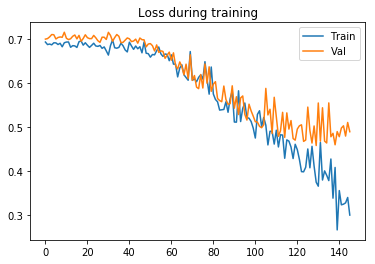

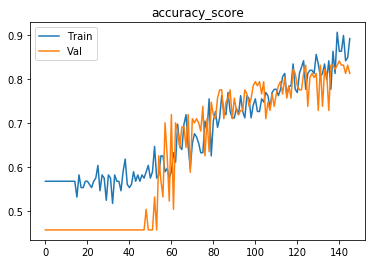

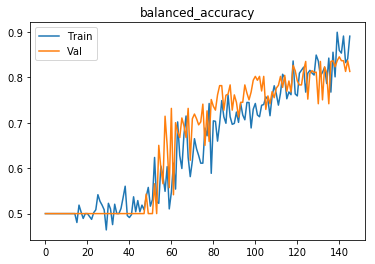

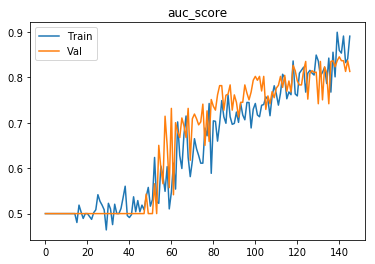

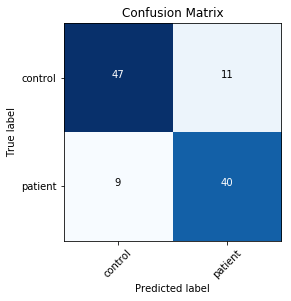

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    10] loss: 0.69923
[0,    20] loss: 0.69489
[0,    30] loss: 0.68913
Time elapsed: 0h:0m:2s
train accuracy_score: 46.04 %
train balanced_accuracy: 44.51 %
train auc_score: 44.51 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698022
[1,    10] loss: 0.70478
[1,    20] loss: 0.68798
[1,    30] loss: 0.67937
Time elapsed: 0h:0m:7s
train accuracy_score: 58.99 %
train balanced_accuracy: 52.50 %
train auc_score: 52.50 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.712218
[2,    10] loss: 0.74290
[2,    20] loss: 0.67857
[2,    30] loss: 0.68863
Time elapsed: 0h:0m:11s
train accuracy_score: 56.12 %
train balanced_accuracy: 49.77 %
train auc_score: 49.77 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696947
[3,    

[28,    10] loss: 0.60067
[28,    20] loss: 0.65386
[28,    30] loss: 0.56592
Time elapsed: 0h:2m:6s
train accuracy_score: 62.59 %
train balanced_accuracy: 60.47 %
train auc_score: 60.47 %
val accuracy_score: 62.62 %
val balanced_accuracy: 65.20 %
val auc_score: 65.20 %
Val loss: 0.624269
[29,    10] loss: 0.61737
[29,    20] loss: 0.55653
[29,    30] loss: 0.52859
Time elapsed: 0h:2m:10s
train accuracy_score: 71.94 %
train balanced_accuracy: 70.31 %
train auc_score: 70.31 %
val accuracy_score: 78.50 %
val balanced_accuracy: 79.38 %
val auc_score: 79.38 %
Val loss: 0.543387
[30,    10] loss: 0.51383
[30,    20] loss: 0.59941
[30,    30] loss: 0.54608
Time elapsed: 0h:2m:14s
train accuracy_score: 70.50 %
train balanced_accuracy: 69.44 %
train auc_score: 69.44 %
val accuracy_score: 75.70 %
val balanced_accuracy: 76.95 %
val auc_score: 76.95 %
Val loss: 0.563811
[31,    10] loss: 0.59864
[31,    20] loss: 0.52472
[31,    30] loss: 0.47753
Time elapsed: 0h:2m:19s
train accuracy_score: 74.1

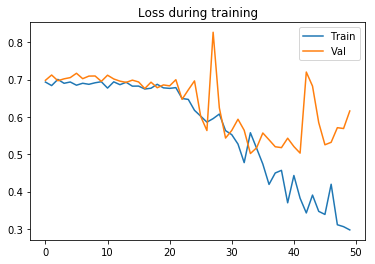

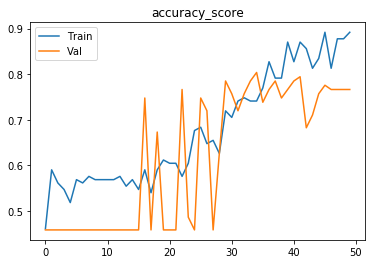

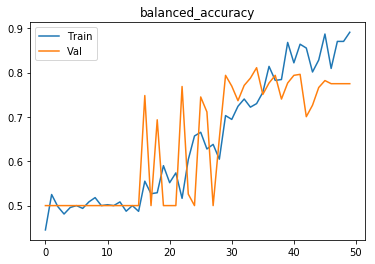

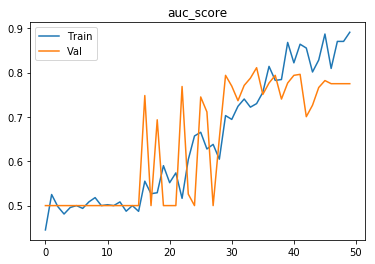

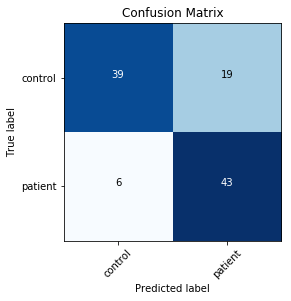

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.69684
[0,    20] loss: 0.71316
Time elapsed: 0h:0m:4s
train accuracy_score: 49.64 %
train balanced_accuracy: 45.68 %
train auc_score: 45.68 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696853
[1,    10] loss: 0.69217
[1,    20] loss: 0.67798
Time elapsed: 0h:0m:10s
train accuracy_score: 57.55 %
train balanced_accuracy: 56.24 %
train auc_score: 56.24 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.723949
[2,    10] loss: 0.71414
[2,    20] loss: 0.67255
Time elapsed: 0h:0m:23s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.710326
[3,    10] loss: 0.68255
[3,    20] loss: 0.68861
Time elapsed: 0h:0m:30s
train a

val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.682210
[31,    10] loss: 0.63197
[31,    20] loss: 0.66950
Time elapsed: 0h:3m:33s
train accuracy_score: 62.59 %
train balanced_accuracy: 56.87 %
train auc_score: 56.87 %
val accuracy_score: 68.22 %
val balanced_accuracy: 66.57 %
val auc_score: 66.57 %
Val loss: 0.630869
[32,    10] loss: 0.68365
[32,    20] loss: 0.62156
Time elapsed: 0h:3m:40s
train accuracy_score: 59.71 %
train balanced_accuracy: 59.55 %
train auc_score: 59.55 %
val accuracy_score: 47.66 %
val balanced_accuracy: 51.72 %
val auc_score: 51.72 %
Val loss: 0.670556
[33,    10] loss: 0.63304
[33,    20] loss: 0.64549
Time elapsed: 0h:3m:46s
train accuracy_score: 64.75 %
train balanced_accuracy: 63.98 %
train auc_score: 63.98 %
val accuracy_score: 71.03 %
val balanced_accuracy: 70.27 %
val auc_score: 70.27 %
Val loss: 0.598517
[34,    10] loss: 0.58682
[34,    20] loss: 0.61928
Time elapsed: 0h:3m:53s
train accuracy_score: 69.78 

val accuracy_score: 80.37 %
val balanced_accuracy: 81.58 %
val auc_score: 81.58 %
Val loss: 0.659236
[62,    10] loss: 0.20608
[62,    20] loss: 0.19672
Time elapsed: 0h:6m:56s
train accuracy_score: 92.09 %
train balanced_accuracy: 91.64 %
train auc_score: 91.64 %
val accuracy_score: 79.44 %
val balanced_accuracy: 80.72 %
val auc_score: 80.72 %
Val loss: 0.664088
[63,    10] loss: 0.18004
[63,    20] loss: 0.14396
Time elapsed: 0h:7m:3s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.23 %
train auc_score: 96.23 %
val accuracy_score: 76.64 %
val balanced_accuracy: 77.34 %
val auc_score: 77.34 %
Val loss: 0.607072
[64,    10] loss: 0.15697
[64,    20] loss: 0.12150
Time elapsed: 0h:7m:9s
train accuracy_score: 95.68 %
train balanced_accuracy: 95.60 %
train auc_score: 95.60 %
val accuracy_score: 78.50 %
val balanced_accuracy: 77.96 %
val auc_score: 77.96 %
Val loss: 0.636558
[65,    10] loss: 0.06495
[65,    20] loss: 0.27616
Time elapsed: 0h:7m:16s
train accuracy_score: 95.68 %


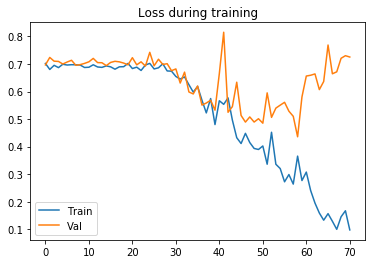

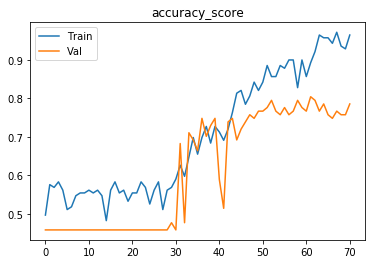

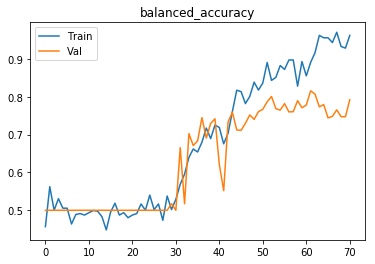

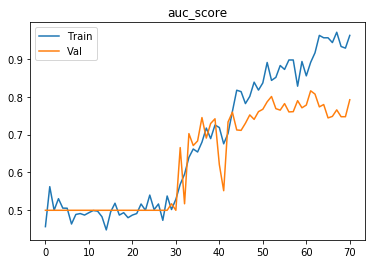

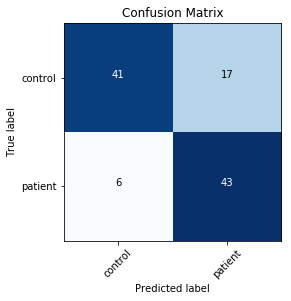

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.69045
Time elapsed: 0h:0m:4s
train accuracy_score: 52.52 %
train balanced_accuracy: 46.20 %
train auc_score: 46.20 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.706665
[1,    10] loss: 0.68675
Time elapsed: 0h:0m:10s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.713560
[2,    10] loss: 0.68860
Time elapsed: 0h:0m:17s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705341
[3,    10] loss: 0.68711
Time elapsed: 0h:0m:23s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score

[34,    10] loss: 0.66510
Time elapsed: 0h:3m:40s
train accuracy_score: 60.43 %
train balanced_accuracy: 55.17 %
train auc_score: 55.17 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.679057
[35,    10] loss: 0.66087
Time elapsed: 0h:3m:46s
train accuracy_score: 60.43 %
train balanced_accuracy: 57.77 %
train auc_score: 57.77 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.678745
[36,    10] loss: 0.65933
Time elapsed: 0h:3m:52s
train accuracy_score: 58.27 %
train balanced_accuracy: 53.87 %
train auc_score: 53.87 %
val accuracy_score: 68.22 %
val balanced_accuracy: 69.74 %
val auc_score: 69.74 %
Val loss: 0.647704
[37,    10] loss: 0.66004
Time elapsed: 0h:3m:58s
train accuracy_score: 58.99 %
train balanced_accuracy: 54.10 %
train auc_score: 54.10 %
val accuracy_score: 74.77 %
val balanced_accuracy: 74.82 %
val auc_score: 74.82 %
Val loss: 0.638949
[38,    10] loss: 0.63746
Time elapsed: 0h:4

val accuracy_score: 82.24 %
val balanced_accuracy: 82.20 %
val auc_score: 82.20 %
Val loss: 0.569413
[69,    10] loss: 0.27563
Time elapsed: 0h:7m:20s
train accuracy_score: 87.77 %
train balanced_accuracy: 87.44 %
train auc_score: 87.44 %
val accuracy_score: 83.18 %
val balanced_accuracy: 83.37 %
val auc_score: 83.37 %
Val loss: 0.585870
[70,    10] loss: 0.27306
Time elapsed: 0h:7m:27s
train accuracy_score: 91.37 %
train balanced_accuracy: 91.20 %
train auc_score: 91.20 %
val accuracy_score: 83.18 %
val balanced_accuracy: 83.53 %
val auc_score: 83.53 %
Val loss: 0.551124
[71,    10] loss: 0.25663
Time elapsed: 0h:7m:33s
train accuracy_score: 89.93 %
train balanced_accuracy: 89.74 %
train auc_score: 89.74 %
val accuracy_score: 81.31 %
val balanced_accuracy: 81.33 %
val auc_score: 81.33 %
Val loss: 0.551473
[72,    10] loss: 0.30311
Time elapsed: 0h:7m:39s
train accuracy_score: 85.61 %
train balanced_accuracy: 85.54 %
train auc_score: 85.54 %
val accuracy_score: 78.50 %
val balanced_acc

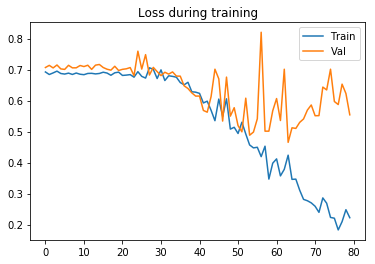

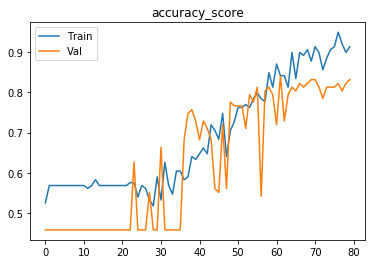

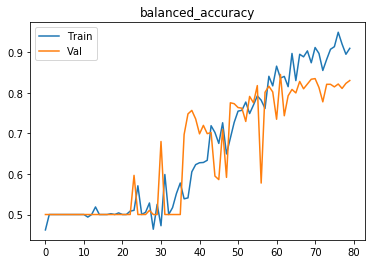

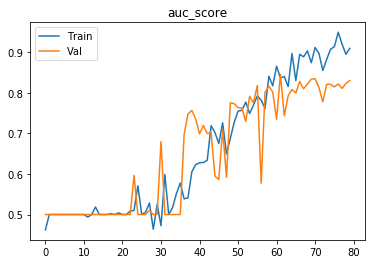

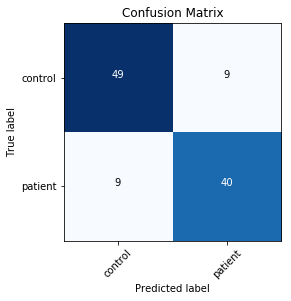

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69326
Time elapsed: 0h:0m:2s
train accuracy_score: 46.76 %
train balanced_accuracy: 46.35 %
train auc_score: 46.35 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695848
[1,    10] loss: 0.69094
Time elapsed: 0h:0m:6s
train accuracy_score: 58.99 %
train balanced_accuracy: 53.10 %
train auc_score: 53.10 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697709
[2,    10] loss: 0.68390
Time elapsed: 0h:0m:9s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.706152
[3,    10] loss: 0.68652
Time elapsed: 0h:0m:14s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 4

[34,    10] loss: 0.67904
Time elapsed: 0h:2m:15s
train accuracy_score: 56.83 %
train balanced_accuracy: 51.40 %
train auc_score: 51.40 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.692290
[35,    10] loss: 0.68933
Time elapsed: 0h:2m:18s
train accuracy_score: 53.96 %
train balanced_accuracy: 49.07 %
train auc_score: 49.07 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694188
[36,    10] loss: 0.67235
Time elapsed: 0h:2m:22s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.20 %
train auc_score: 50.20 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.706106
[37,    10] loss: 0.66925
Time elapsed: 0h:2m:26s
train accuracy_score: 57.55 %
train balanced_accuracy: 51.23 %
train auc_score: 51.23 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698882
[38,    10] loss: 0.67372
Time elapsed: 0h:2

val accuracy_score: 68.22 %
val balanced_accuracy: 69.90 %
val auc_score: 69.90 %
Val loss: 0.654681
[69,    10] loss: 0.64351
Time elapsed: 0h:4m:33s
train accuracy_score: 56.12 %
train balanced_accuracy: 53.38 %
train auc_score: 53.38 %
val accuracy_score: 66.36 %
val balanced_accuracy: 66.27 %
val auc_score: 66.27 %
Val loss: 0.645170
[70,    10] loss: 0.65859
Time elapsed: 0h:4m:36s
train accuracy_score: 64.03 %
train balanced_accuracy: 60.14 %
train auc_score: 60.14 %
val accuracy_score: 66.36 %
val balanced_accuracy: 68.33 %
val auc_score: 68.33 %
Val loss: 0.657211
[71,    10] loss: 0.62089
Time elapsed: 0h:4m:40s
train accuracy_score: 63.31 %
train balanced_accuracy: 59.70 %
train auc_score: 59.70 %
val accuracy_score: 69.16 %
val balanced_accuracy: 70.76 %
val auc_score: 70.76 %
Val loss: 0.648890
[72,    10] loss: 0.63956
Time elapsed: 0h:4m:44s
train accuracy_score: 61.87 %
train balanced_accuracy: 59.24 %
train auc_score: 59.24 %
val accuracy_score: 63.55 %
val balanced_acc

[103,    10] loss: 0.58730
Time elapsed: 0h:6m:46s
train accuracy_score: 74.10 %
train balanced_accuracy: 74.01 %
train auc_score: 74.01 %
val accuracy_score: 73.83 %
val balanced_accuracy: 73.33 %
val auc_score: 73.33 %
Val loss: 0.556761
[104,    10] loss: 0.55395
Time elapsed: 0h:6m:49s
train accuracy_score: 71.22 %
train balanced_accuracy: 69.27 %
train auc_score: 69.27 %
val accuracy_score: 79.44 %
val balanced_accuracy: 80.08 %
val auc_score: 80.08 %
Val loss: 0.566561
[105,    10] loss: 0.51500
Time elapsed: 0h:6m:53s
train accuracy_score: 74.82 %
train balanced_accuracy: 73.24 %
train auc_score: 73.24 %
val accuracy_score: 71.96 %
val balanced_accuracy: 70.97 %
val auc_score: 70.97 %
Val loss: 0.553034
[106,    10] loss: 0.62044
Time elapsed: 0h:6m:58s
train accuracy_score: 70.50 %
train balanced_accuracy: 70.04 %
train auc_score: 70.04 %
val accuracy_score: 77.57 %
val balanced_accuracy: 78.04 %
val auc_score: 78.04 %
Val loss: 0.556980
[107,    10] loss: 0.52576
Time elapsed:

val accuracy_score: 79.44 %
val balanced_accuracy: 79.77 %
val auc_score: 79.77 %
Val loss: 0.481435
[138,    10] loss: 0.40027
Time elapsed: 0h:9m:4s
train accuracy_score: 85.61 %
train balanced_accuracy: 84.74 %
train auc_score: 84.74 %
val accuracy_score: 81.31 %
val balanced_accuracy: 81.33 %
val auc_score: 81.33 %
Val loss: 0.474075
[139,    10] loss: 0.43778
Time elapsed: 0h:9m:8s
train accuracy_score: 79.86 %
train balanced_accuracy: 80.07 %
train auc_score: 80.07 %
val accuracy_score: 82.24 %
val balanced_accuracy: 82.35 %
val auc_score: 82.35 %
Val loss: 0.476919
[140,    10] loss: 0.44289
Time elapsed: 0h:9m:12s
train accuracy_score: 76.98 %
train balanced_accuracy: 75.94 %
train auc_score: 75.94 %
val accuracy_score: 82.24 %
val balanced_accuracy: 82.20 %
val auc_score: 82.20 %
Val loss: 0.472540
[141,    10] loss: 0.44432
Time elapsed: 0h:9m:16s
train accuracy_score: 80.58 %
train balanced_accuracy: 79.50 %
train auc_score: 79.50 %
val accuracy_score: 83.18 %
val balanced_a

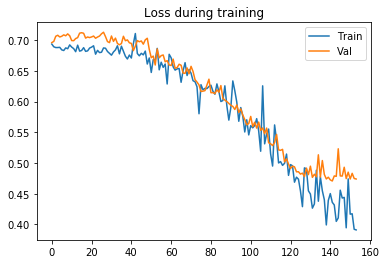

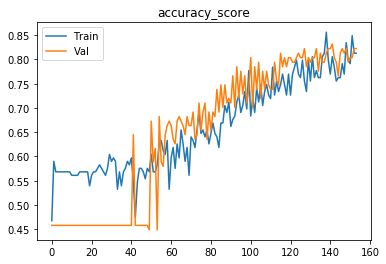

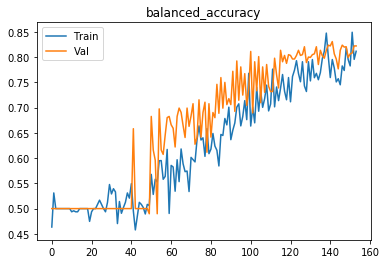

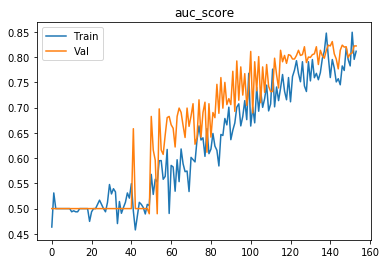

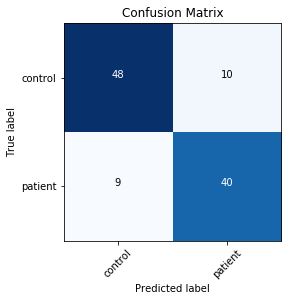

Finished outer fold.
{'final_acc': 0.8305770584095707, 'best_acc': 0.8455313159746658, 'final_iter': 80, 'best_iter': 62, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3}
###### Starting outer fold 1
# of patients 109, # of healthy controls 125
139
95
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    10] loss: 0.67972
[0,    20] loss: 0.63493
[0,    30] loss: 0.73105
Time elapsed: 0h:0m:2s
train accuracy_score: 57.55 %
train balanced_accuracy: 57.40 %
train auc_score: 57.40 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.764692
[1,    10] loss: 0.71352
[1,    20] loss: 0.70443
[1,    30] loss: 0.69252
Time elapsed: 0h:0m:7s
train accuracy_score: 48.92 %
train balanced_accuracy: 48.98 %
train auc_score: 48.98 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0

[27,    10] loss: 0.69719
[27,    20] loss: 0.69854
[27,    30] loss: 0.69577
Time elapsed: 0h:1m:59s
train accuracy_score: 47.48 %
train balanced_accuracy: 47.23 %
train auc_score: 47.23 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.684190
[28,    10] loss: 0.67286
[28,    20] loss: 0.71230
[28,    30] loss: 0.70034
Time elapsed: 0h:2m:4s
train accuracy_score: 51.80 %
train balanced_accuracy: 51.53 %
train auc_score: 51.53 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.692409
[29,    10] loss: 0.69585
[29,    20] loss: 0.69435
[29,    30] loss: 0.70005
Time elapsed: 0h:2m:8s
train accuracy_score: 47.48 %
train balanced_accuracy: 47.44 %
train auc_score: 47.44 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.687550
[30,    10] loss: 0.70328
[30,    20] loss: 0.67889
[30,    30] loss: 0.70058
Time elapsed: 0h:2m:12s
train accuracy_score: 48.92

[55,    30] loss: 0.69470
Time elapsed: 0h:3m:59s
train accuracy_score: 55.40 %
train balanced_accuracy: 55.21 %
train auc_score: 55.21 %
val accuracy_score: 65.26 %
val balanced_accuracy: 58.75 %
val auc_score: 58.75 %
Val loss: 0.670531
[56,    10] loss: 0.67342
[56,    20] loss: 0.69227
[56,    30] loss: 0.68117
Time elapsed: 0h:4m:3s
train accuracy_score: 55.40 %
train balanced_accuracy: 55.22 %
train auc_score: 55.22 %
val accuracy_score: 69.47 %
val balanced_accuracy: 63.75 %
val auc_score: 63.75 %
Val loss: 0.669580
[57,    10] loss: 0.67577
[57,    20] loss: 0.68051
[57,    30] loss: 0.68325
Time elapsed: 0h:4m:7s
train accuracy_score: 56.12 %
train balanced_accuracy: 56.18 %
train auc_score: 56.18 %
val accuracy_score: 69.47 %
val balanced_accuracy: 63.75 %
val auc_score: 63.75 %
Val loss: 0.664028
[58,    10] loss: 0.69807
[58,    20] loss: 0.68529
[58,    30] loss: 0.70174
Time elapsed: 0h:4m:12s
train accuracy_score: 51.80 %
train balanced_accuracy: 51.67 %
train auc_score:

val accuracy_score: 77.89 %
val balanced_accuracy: 78.86 %
val auc_score: 78.86 %
Val loss: 0.450389
[84,    10] loss: 0.45603
[84,    20] loss: 0.45897
[84,    30] loss: 0.47846
Time elapsed: 0h:6m:5s
train accuracy_score: 78.42 %
train balanced_accuracy: 78.43 %
train auc_score: 78.43 %
val accuracy_score: 81.05 %
val balanced_accuracy: 79.55 %
val auc_score: 79.55 %
Val loss: 0.411299
[85,    10] loss: 0.46965
[85,    20] loss: 0.49499
[85,    30] loss: 0.33564
Time elapsed: 0h:6m:9s
train accuracy_score: 82.01 %
train balanced_accuracy: 82.01 %
train auc_score: 82.01 %
val accuracy_score: 80.00 %
val balanced_accuracy: 76.25 %
val auc_score: 76.25 %
Val loss: 0.453434
[86,    10] loss: 0.49005
[86,    20] loss: 0.49572
[86,    30] loss: 0.47286
Time elapsed: 0h:6m:14s
train accuracy_score: 79.86 %
train balanced_accuracy: 79.84 %
train auc_score: 79.84 %
val accuracy_score: 81.05 %
val balanced_accuracy: 77.50 %
val auc_score: 77.50 %
Val loss: 0.433045
[87,    10] loss: 0.36924
[8

[112,    10] loss: 0.27291
[112,    20] loss: 0.22120
[112,    30] loss: 0.19095
Time elapsed: 0h:8m:7s
train accuracy_score: 88.49 %
train balanced_accuracy: 88.48 %
train auc_score: 88.48 %
val accuracy_score: 83.16 %
val balanced_accuracy: 82.05 %
val auc_score: 82.05 %
Val loss: 0.351422
[113,    10] loss: 0.16388
[113,    20] loss: 0.17674
[113,    30] loss: 0.28369
Time elapsed: 0h:8m:11s
train accuracy_score: 94.24 %
train balanced_accuracy: 94.22 %
train auc_score: 94.22 %
val accuracy_score: 76.84 %
val balanced_accuracy: 77.95 %
val auc_score: 77.95 %
Val loss: 0.407552
[114,    10] loss: 0.27619
[114,    20] loss: 0.19656
[114,    30] loss: 0.28149
Time elapsed: 0h:8m:16s
train accuracy_score: 89.93 %
train balanced_accuracy: 89.93 %
train auc_score: 89.93 %
val accuracy_score: 86.32 %
val balanced_accuracy: 84.09 %
val auc_score: 84.09 %
Val loss: 0.387839
[115,    10] loss: 0.23605
[115,    20] loss: 0.30032
[115,    30] loss: 0.19282
Time elapsed: 0h:8m:20s
train accuracy

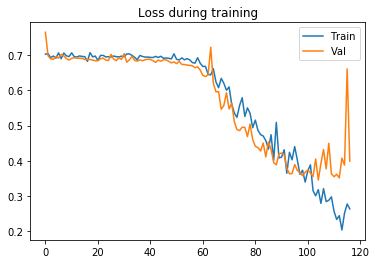

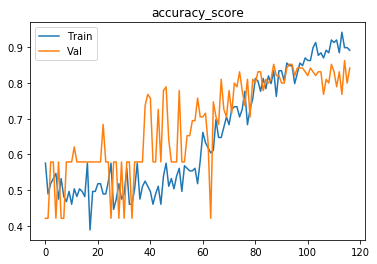

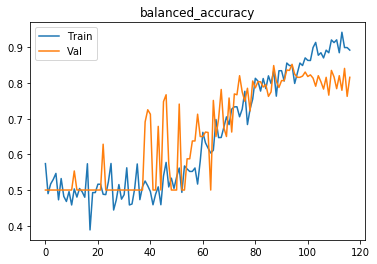

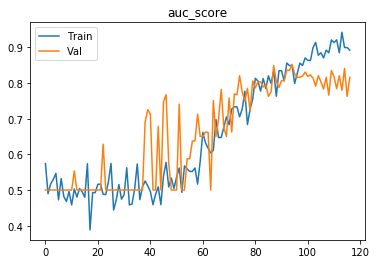

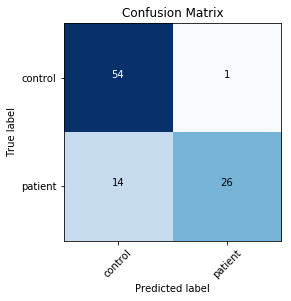

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69723
[0,    20] loss: 0.69438
Time elapsed: 0h:0m:2s
train accuracy_score: 50.36 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.688134
[1,    10] loss: 0.69206
[1,    20] loss: 0.69074
Time elapsed: 0h:0m:6s
train accuracy_score: 51.80 %
train balanced_accuracy: 51.45 %
train auc_score: 51.45 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.689449
[2,    10] loss: 0.69770
[2,    20] loss: 0.69033
Time elapsed: 0h:0m:10s
train accuracy_score: 48.92 %
train balanced_accuracy: 48.61 %
train auc_score: 48.61 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.689233
[3,    10] loss: 0.68985
[3,    20] loss: 0.69065
Time elapsed: 0h:0m:14s
train acc

val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.683772
[31,    10] loss: 0.69719
[31,    20] loss: 0.69678
Time elapsed: 0h:2m:8s
train accuracy_score: 46.04 %
train balanced_accuracy: 45.77 %
train auc_score: 45.77 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.685136
[32,    10] loss: 0.69214
[32,    20] loss: 0.69414
Time elapsed: 0h:2m:12s
train accuracy_score: 46.76 %
train balanced_accuracy: 46.63 %
train auc_score: 46.63 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.686790
[33,    10] loss: 0.68850
[33,    20] loss: 0.69869
Time elapsed: 0h:2m:16s
train accuracy_score: 50.36 %
train balanced_accuracy: 50.21 %
train auc_score: 50.21 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.686033
[34,    10] loss: 0.68936
[34,    20] loss: 0.69204
Time elapsed: 0h:2m:20s
train accuracy_score: 49.64 %

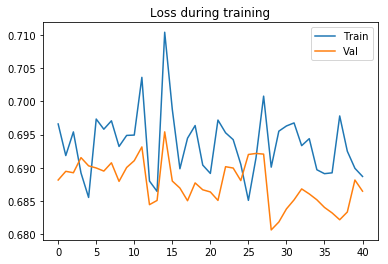

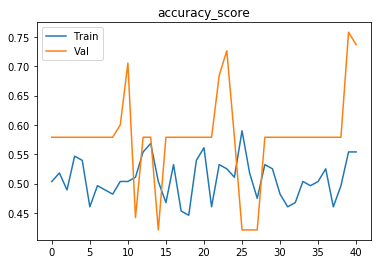

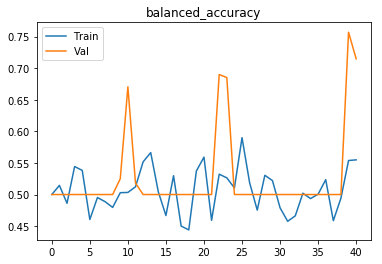

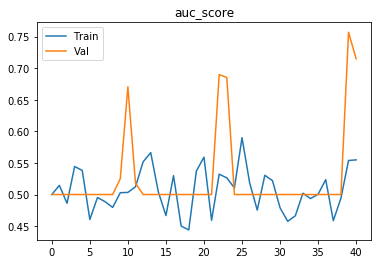

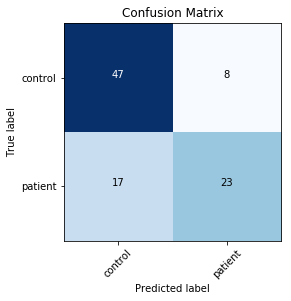

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.70255
[0,    20] loss: 0.69605
Time elapsed: 0h:0m:4s
train accuracy_score: 44.60 %
train balanced_accuracy: 44.50 %
train auc_score: 44.50 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.685460
[1,    10] loss: 0.69607
[1,    20] loss: 0.69607
Time elapsed: 0h:0m:10s
train accuracy_score: 49.64 %
train balanced_accuracy: 49.29 %
train auc_score: 49.29 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.689375
[2,    10] loss: 0.69689
[2,    20] loss: 0.70018
Time elapsed: 0h:0m:17s
train accuracy_score: 42.45 %
train balanced_accuracy: 42.64 %
train auc_score: 42.64 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691557
[3,    10] loss: 0.69598
[3,    20] loss: 0.69731
Time elapsed: 0h:0m:23s
train a

val accuracy_score: 81.05 %
val balanced_accuracy: 78.52 %
val auc_score: 78.52 %
Val loss: 0.457433
[31,    10] loss: 0.55994
[31,    20] loss: 0.52675
Time elapsed: 0h:3m:18s
train accuracy_score: 74.82 %
train balanced_accuracy: 74.86 %
train auc_score: 74.86 %
val accuracy_score: 82.11 %
val balanced_accuracy: 78.75 %
val auc_score: 78.75 %
Val loss: 0.457381
[32,    10] loss: 0.54708
[32,    20] loss: 0.55169
Time elapsed: 0h:3m:24s
train accuracy_score: 76.26 %
train balanced_accuracy: 76.21 %
train auc_score: 76.21 %
val accuracy_score: 82.11 %
val balanced_accuracy: 81.82 %
val auc_score: 81.82 %
Val loss: 0.470153
[33,    10] loss: 0.60684
[33,    20] loss: 0.56055
Time elapsed: 0h:3m:31s
train accuracy_score: 73.38 %
train balanced_accuracy: 73.40 %
train auc_score: 73.40 %
val accuracy_score: 81.05 %
val balanced_accuracy: 77.50 %
val auc_score: 77.50 %
Val loss: 0.473238
[34,    10] loss: 0.47977
[34,    20] loss: 0.42422
Time elapsed: 0h:3m:37s
train accuracy_score: 82.73 

val accuracy_score: 84.21 %
val balanced_accuracy: 84.66 %
val auc_score: 84.66 %
Val loss: 0.341384
[62,    10] loss: 0.06478
[62,    20] loss: 0.07035
Time elapsed: 0h:6m:31s
train accuracy_score: 98.56 %
train balanced_accuracy: 98.56 %
train auc_score: 98.56 %
val accuracy_score: 89.47 %
val balanced_accuracy: 87.84 %
val auc_score: 87.84 %
Val loss: 0.354499
[63,    10] loss: 0.03973
[63,    20] loss: 0.04759
Time elapsed: 0h:6m:37s
train accuracy_score: 99.28 %
train balanced_accuracy: 99.28 %
train auc_score: 99.28 %
val accuracy_score: 85.26 %
val balanced_accuracy: 85.91 %
val auc_score: 85.91 %
Val loss: 0.378518
[64,    10] loss: 0.01113
[64,    20] loss: 0.16166
Time elapsed: 0h:6m:44s
train accuracy_score: 97.12 %
train balanced_accuracy: 97.12 %
train auc_score: 97.12 %
val accuracy_score: 87.37 %
val balanced_accuracy: 86.02 %
val auc_score: 86.02 %
Val loss: 0.343415
[65,    10] loss: 0.08380
[65,    20] loss: 0.04222
Time elapsed: 0h:6m:50s
train accuracy_score: 97.84 

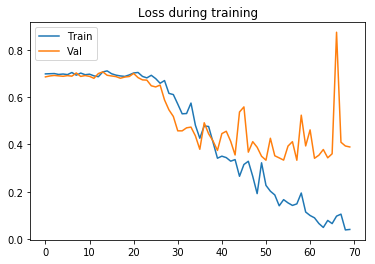

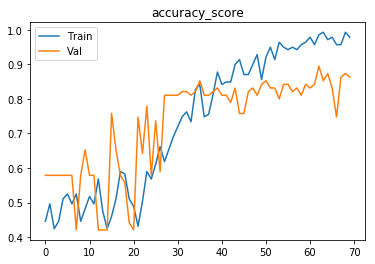

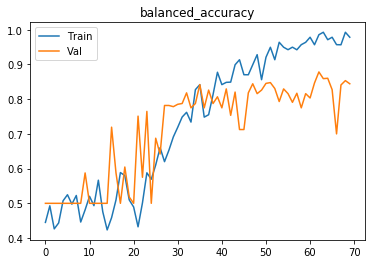

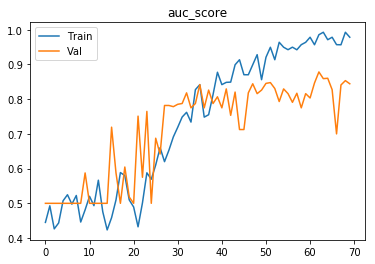

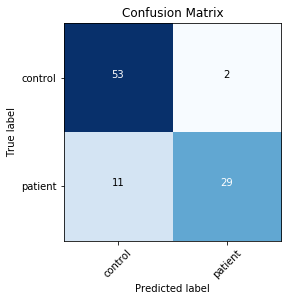

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.68972
[0,    20] loss: 0.70104
Time elapsed: 0h:0m:4s
train accuracy_score: 51.08 %
train balanced_accuracy: 51.34 %
train auc_score: 51.34 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.683202
[1,    10] loss: 0.69466
[1,    20] loss: 0.72207
Time elapsed: 0h:0m:10s
train accuracy_score: 53.96 %
train balanced_accuracy: 53.83 %
train auc_score: 53.83 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.736646
[2,    10] loss: 0.72094
[2,    20] loss: 0.69310
Time elapsed: 0h:0m:16s
train accuracy_score: 45.32 %
train balanced_accuracy: 45.38 %
train auc_score: 45.38 %
val accuracy_score: 40.00 %
val balanced_accuracy: 47.50 %
val auc_score: 47.50 %
Val loss: 0.693308
[3,    10] loss: 0.70159
[3,    20] loss: 0.69662
Time elapsed: 0h:0m:23s
train a

val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.707649
[31,    10] loss: 0.69922
[31,    20] loss: 0.69675
Time elapsed: 0h:3m:17s
train accuracy_score: 51.08 %
train balanced_accuracy: 51.16 %
train auc_score: 51.16 %
val accuracy_score: 72.63 %
val balanced_accuracy: 69.55 %
val auc_score: 69.55 %
Val loss: 0.679239
[32,    10] loss: 0.68452
[32,    20] loss: 0.69364
Time elapsed: 0h:3m:23s
train accuracy_score: 56.83 %
train balanced_accuracy: 56.54 %
train auc_score: 56.54 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.688867
[33,    10] loss: 0.67997
[33,    20] loss: 0.67559
Time elapsed: 0h:3m:29s
train accuracy_score: 59.71 %
train balanced_accuracy: 59.83 %
train auc_score: 59.83 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.667589
[34,    10] loss: 0.68288
[34,    20] loss: 0.67767
Time elapsed: 0h:3m:35s
train accuracy_score: 52.52 

val accuracy_score: 88.42 %
val balanced_accuracy: 86.25 %
val auc_score: 86.25 %
Val loss: 0.302520
[62,    10] loss: 0.34024
[62,    20] loss: 0.25098
Time elapsed: 0h:6m:29s
train accuracy_score: 87.05 %
train balanced_accuracy: 87.03 %
train auc_score: 87.03 %
val accuracy_score: 90.53 %
val balanced_accuracy: 89.09 %
val auc_score: 89.09 %
Val loss: 0.267102
[63,    10] loss: 0.19119
[63,    20] loss: 0.15581
Time elapsed: 0h:6m:35s
train accuracy_score: 92.09 %
train balanced_accuracy: 92.09 %
train auc_score: 92.09 %
val accuracy_score: 91.58 %
val balanced_accuracy: 90.68 %
val auc_score: 90.68 %
Val loss: 0.250400
[64,    10] loss: 0.19044
[64,    20] loss: 0.21744
Time elapsed: 0h:6m:41s
train accuracy_score: 92.09 %
train balanced_accuracy: 92.08 %
train auc_score: 92.08 %
val accuracy_score: 82.11 %
val balanced_accuracy: 83.18 %
val auc_score: 83.18 %
Val loss: 0.314962
[65,    10] loss: 0.13892
[65,    20] loss: 0.29360
Time elapsed: 0h:6m:47s
train accuracy_score: 93.53 

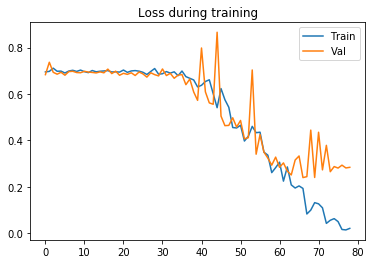

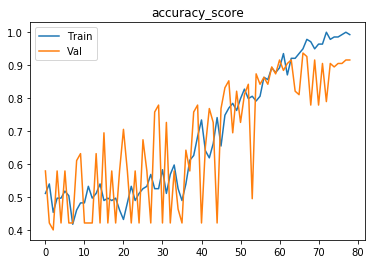

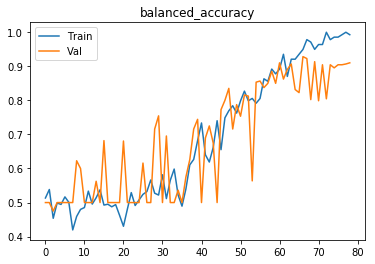

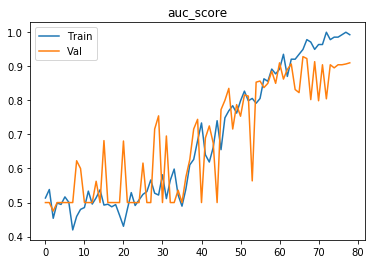

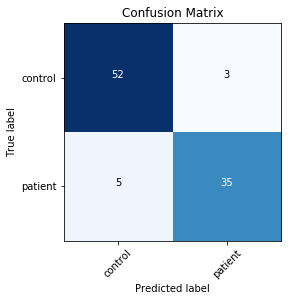

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69206
[0,    20] loss: 0.69399
[0,    30] loss: 0.69942
Time elapsed: 0h:0m:2s
train accuracy_score: 46.76 %
train balanced_accuracy: 46.76 %
train auc_score: 46.76 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691338
[1,    10] loss: 0.69516
[1,    20] loss: 0.69274
[1,    30] loss: 0.70493
Time elapsed: 0h:0m:6s
train accuracy_score: 46.04 %
train balanced_accuracy: 46.08 %
train auc_score: 46.08 %
val accuracy_score: 60.00 %
val balanced_accuracy: 52.84 %
val auc_score: 52.84 %
Val loss: 0.692688
[2,    10] loss: 0.69894
[2,    20] loss: 0.69296
[2,    30] loss: 0.69904
Time elapsed: 0h:0m:11s
train accuracy_score: 41.73 %
train balanced_accuracy: 41.65 %
train auc_score: 41.65 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.692040
[3,    1

[28,    10] loss: 0.68569
[28,    20] loss: 0.69160
[28,    30] loss: 0.69556
Time elapsed: 0h:2m:4s
train accuracy_score: 53.96 %
train balanced_accuracy: 53.64 %
train auc_score: 53.64 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.679054
[29,    10] loss: 0.67554
[29,    20] loss: 0.69301
[29,    30] loss: 0.68177
Time elapsed: 0h:2m:8s
train accuracy_score: 57.55 %
train balanced_accuracy: 57.37 %
train auc_score: 57.37 %
val accuracy_score: 65.26 %
val balanced_accuracy: 58.75 %
val auc_score: 58.75 %
Val loss: 0.678695
[30,    10] loss: 0.68008
[30,    20] loss: 0.67842
[30,    30] loss: 0.66003
Time elapsed: 0h:2m:13s
train accuracy_score: 66.19 %
train balanced_accuracy: 66.08 %
train auc_score: 66.08 %
val accuracy_score: 71.58 %
val balanced_accuracy: 72.05 %
val auc_score: 72.05 %
Val loss: 0.679131
[31,    10] loss: 0.69296
[31,    20] loss: 0.69384
[31,    30] loss: 0.69088
Time elapsed: 0h:2m:17s
train accuracy_score: 48.20

[56,    30] loss: 0.44798
Time elapsed: 0h:4m:4s
train accuracy_score: 74.10 %
train balanced_accuracy: 74.10 %
train auc_score: 74.10 %
val accuracy_score: 78.95 %
val balanced_accuracy: 78.07 %
val auc_score: 78.07 %
Val loss: 0.477491
[57,    10] loss: 0.52575
[57,    20] loss: 0.63889
[57,    30] loss: 0.40237
Time elapsed: 0h:4m:8s
train accuracy_score: 77.70 %
train balanced_accuracy: 77.69 %
train auc_score: 77.69 %
val accuracy_score: 82.11 %
val balanced_accuracy: 78.75 %
val auc_score: 78.75 %
Val loss: 0.460230
[58,    10] loss: 0.49026
[58,    20] loss: 0.42487
[58,    30] loss: 0.50435
Time elapsed: 0h:4m:12s
train accuracy_score: 78.42 %
train balanced_accuracy: 78.37 %
train auc_score: 78.37 %
val accuracy_score: 81.05 %
val balanced_accuracy: 79.55 %
val auc_score: 79.55 %
Val loss: 0.452695
[59,    10] loss: 0.46990
[59,    20] loss: 0.48973
[59,    30] loss: 0.57371
Time elapsed: 0h:4m:16s
train accuracy_score: 76.26 %
train balanced_accuracy: 76.29 %
train auc_score:

val accuracy_score: 84.21 %
val balanced_accuracy: 83.98 %
val auc_score: 83.98 %
Val loss: 0.378885
[85,    10] loss: 0.37823
[85,    20] loss: 0.40706
[85,    30] loss: 0.33758
Time elapsed: 0h:6m:6s
train accuracy_score: 84.89 %
train balanced_accuracy: 84.91 %
train auc_score: 84.91 %
val accuracy_score: 76.84 %
val balanced_accuracy: 72.50 %
val auc_score: 72.50 %
Val loss: 0.480970
[86,    10] loss: 0.37587
[86,    20] loss: 0.34634
[86,    30] loss: 0.48024
Time elapsed: 0h:6m:10s
train accuracy_score: 87.05 %
train balanced_accuracy: 87.05 %
train auc_score: 87.05 %
val accuracy_score: 84.21 %
val balanced_accuracy: 82.61 %
val auc_score: 82.61 %
Val loss: 0.355258
[87,    10] loss: 0.45463
[87,    20] loss: 0.28219
[87,    30] loss: 0.43631
Time elapsed: 0h:6m:15s
train accuracy_score: 82.73 %
train balanced_accuracy: 82.68 %
train auc_score: 82.68 %
val accuracy_score: 84.21 %
val balanced_accuracy: 83.98 %
val auc_score: 83.98 %
Val loss: 0.367923
[88,    10] loss: 0.47794
[

[113,    10] loss: 0.15158
[113,    20] loss: 0.39077
[113,    30] loss: 0.25050
Time elapsed: 0h:8m:4s
train accuracy_score: 91.37 %
train balanced_accuracy: 91.37 %
train auc_score: 91.37 %
val accuracy_score: 80.00 %
val balanced_accuracy: 77.27 %
val auc_score: 77.27 %
Val loss: 0.348051
[114,    10] loss: 0.42847
[114,    20] loss: 0.15716
[114,    30] loss: 0.28516
Time elapsed: 0h:8m:8s
train accuracy_score: 92.09 %
train balanced_accuracy: 92.06 %
train auc_score: 92.06 %
val accuracy_score: 82.11 %
val balanced_accuracy: 81.82 %
val auc_score: 81.82 %
Val loss: 0.313600
[115,    10] loss: 0.28422
[115,    20] loss: 0.31041
[115,    30] loss: 0.20892
Time elapsed: 0h:8m:12s
train accuracy_score: 87.77 %
train balanced_accuracy: 87.74 %
train auc_score: 87.74 %
val accuracy_score: 84.21 %
val balanced_accuracy: 82.61 %
val auc_score: 82.61 %
Val loss: 0.312620
[116,    10] loss: 0.34373
[116,    20] loss: 0.29882
[116,    30] loss: 0.17842
Time elapsed: 0h:8m:17s
train accuracy_

[141,    10] loss: 0.17693
[141,    20] loss: 0.22933
[141,    30] loss: 0.22578
Time elapsed: 0h:10m:6s
train accuracy_score: 93.53 %
train balanced_accuracy: 93.52 %
train auc_score: 93.52 %
val accuracy_score: 83.16 %
val balanced_accuracy: 81.70 %
val auc_score: 81.70 %
Val loss: 0.303566
[142,    10] loss: 0.13761
[142,    20] loss: 0.28477
[142,    30] loss: 0.16599
Time elapsed: 0h:10m:10s
train accuracy_score: 92.09 %
train balanced_accuracy: 92.09 %
train auc_score: 92.09 %
val accuracy_score: 80.00 %
val balanced_accuracy: 76.25 %
val auc_score: 76.25 %
Val loss: 0.411725
[143,    10] loss: 0.24346
[143,    20] loss: 0.15621
[143,    30] loss: 0.20427
Time elapsed: 0h:10m:14s
train accuracy_score: 90.65 %
train balanced_accuracy: 90.64 %
train auc_score: 90.64 %
val accuracy_score: 83.16 %
val balanced_accuracy: 81.70 %
val auc_score: 81.70 %
Val loss: 0.304866
[144,    10] loss: 0.31076
[144,    20] loss: 0.30562
[144,    30] loss: 0.15485
Time elapsed: 0h:10m:18s
train accu

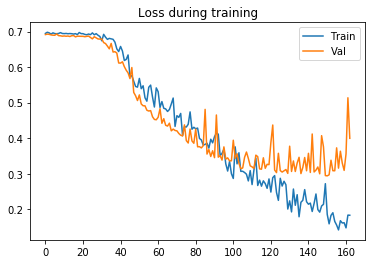

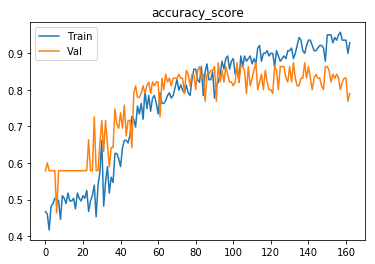

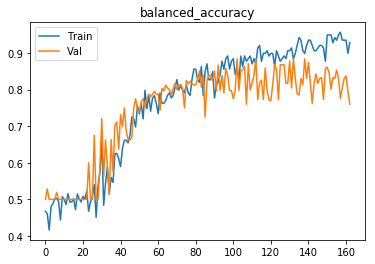

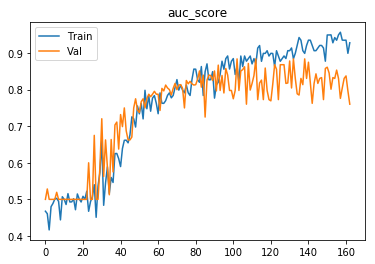

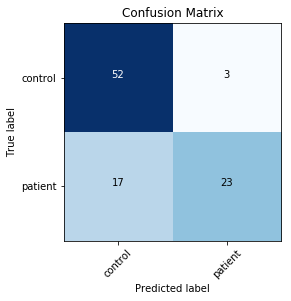

Finished outer fold.
{'final_acc': 0.9102272727272727, 'best_acc': 0.928409090909091, 'final_iter': 79, 'best_iter': 67, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 3}
###### Starting outer fold 2
# of patients 122, # of healthy controls 117
138
101
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69379
[0,    20] loss: 0.69164
[0,    30] loss: 0.68761
Time elapsed: 0h:0m:2s
train accuracy_score: 55.07 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698039
[1,    10] loss: 0.67396
[1,    20] loss: 0.71321
[1,    30] loss: 0.68290
Time elapsed: 0h:0m:7s
train accuracy_score: 55.07 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.7

[27,    10] loss: 0.71313
[27,    20] loss: 0.69765
[27,    30] loss: 0.68500
Time elapsed: 0h:1m:58s
train accuracy_score: 55.07 %
train balanced_accuracy: 53.42 %
train auc_score: 53.42 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700363
[28,    10] loss: 0.67320
[28,    20] loss: 0.67450
[28,    30] loss: 0.69980
Time elapsed: 0h:2m:3s
train accuracy_score: 57.25 %
train balanced_accuracy: 52.42 %
train auc_score: 52.42 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693853
[29,    10] loss: 0.67710
[29,    20] loss: 0.69301
[29,    30] loss: 0.69136
Time elapsed: 0h:2m:7s
train accuracy_score: 55.80 %
train balanced_accuracy: 53.03 %
train auc_score: 53.03 %
val accuracy_score: 53.47 %
val balanced_accuracy: 56.92 %
val auc_score: 56.92 %
Val loss: 0.691808
[30,    10] loss: 0.67566
[30,    20] loss: 0.67702
[30,    30] loss: 0.68393
Time elapsed: 0h:2m:11s
train accuracy_score: 63.77

[55,    30] loss: 0.54253
Time elapsed: 0h:3m:59s
train accuracy_score: 65.94 %
train balanced_accuracy: 64.33 %
train auc_score: 64.33 %
val accuracy_score: 58.42 %
val balanced_accuracy: 59.33 %
val auc_score: 59.33 %
Val loss: 0.634941
[56,    10] loss: 0.61405
[56,    20] loss: 0.52553
[56,    30] loss: 0.67263
Time elapsed: 0h:4m:3s
train accuracy_score: 67.39 %
train balanced_accuracy: 66.09 %
train auc_score: 66.09 %
val accuracy_score: 58.42 %
val balanced_accuracy: 58.79 %
val auc_score: 58.79 %
Val loss: 0.621965
[57,    10] loss: 0.58600
[57,    20] loss: 0.53889
[57,    30] loss: 0.62932
Time elapsed: 0h:4m:8s
train accuracy_score: 69.57 %
train balanced_accuracy: 68.36 %
train auc_score: 68.36 %
val accuracy_score: 63.37 %
val balanced_accuracy: 60.85 %
val auc_score: 60.85 %
Val loss: 0.625434
[58,    10] loss: 0.64769
[58,    20] loss: 0.72680
[58,    30] loss: 0.54826
Time elapsed: 0h:4m:12s
train accuracy_score: 65.94 %
train balanced_accuracy: 65.22 %
train auc_score:

val accuracy_score: 61.39 %
val balanced_accuracy: 62.94 %
val auc_score: 62.94 %
Val loss: 0.616676
[84,    10] loss: 0.39788
[84,    20] loss: 0.35115
[84,    30] loss: 0.41824
Time elapsed: 0h:6m:6s
train accuracy_score: 81.88 %
train balanced_accuracy: 81.32 %
train auc_score: 81.32 %
val accuracy_score: 64.36 %
val balanced_accuracy: 63.89 %
val auc_score: 63.89 %
Val loss: 0.565504
[85,    10] loss: 0.39445
[85,    20] loss: 0.41021
[85,    30] loss: 0.44541
Time elapsed: 0h:6m:10s
train accuracy_score: 84.78 %
train balanced_accuracy: 84.85 %
train auc_score: 84.85 %
val accuracy_score: 61.39 %
val balanced_accuracy: 61.88 %
val auc_score: 61.88 %
Val loss: 0.568241
[86,    10] loss: 0.36174
[86,    20] loss: 0.58234
[86,    30] loss: 0.33384
Time elapsed: 0h:6m:15s
train accuracy_score: 81.16 %
train balanced_accuracy: 80.96 %
train auc_score: 80.96 %
val accuracy_score: 60.40 %
val balanced_accuracy: 62.57 %
val auc_score: 62.57 %
Val loss: 0.628661
[87,    10] loss: 0.52613
[

[112,    10] loss: 0.34236
[112,    20] loss: 0.42166
[112,    30] loss: 0.35803
Time elapsed: 0h:8m:10s
train accuracy_score: 86.96 %
train balanced_accuracy: 86.82 %
train auc_score: 86.82 %
val accuracy_score: 66.34 %
val balanced_accuracy: 65.89 %
val auc_score: 65.89 %
Val loss: 0.508785
[113,    10] loss: 0.28299
[113,    20] loss: 0.39144
[113,    30] loss: 0.39479
Time elapsed: 0h:8m:15s
train accuracy_score: 89.13 %
train balanced_accuracy: 89.09 %
train auc_score: 89.09 %
val accuracy_score: 74.26 %
val balanced_accuracy: 72.98 %
val auc_score: 72.98 %
Val loss: 0.521311
[114,    10] loss: 0.31200
[114,    20] loss: 0.35379
[114,    30] loss: 0.42017
Time elapsed: 0h:8m:19s
train accuracy_score: 87.68 %
train balanced_accuracy: 87.33 %
train auc_score: 87.33 %
val accuracy_score: 68.32 %
val balanced_accuracy: 67.89 %
val auc_score: 67.89 %
Val loss: 0.503330
[115,    10] loss: 0.32614
[115,    20] loss: 0.44429
[115,    30] loss: 0.30714
Time elapsed: 0h:8m:23s
train accurac

[140,    10] loss: 0.24466
[140,    20] loss: 0.25923
[140,    30] loss: 0.26631
Time elapsed: 0h:10m:11s
train accuracy_score: 92.03 %
train balanced_accuracy: 91.87 %
train auc_score: 91.87 %
val accuracy_score: 78.22 %
val balanced_accuracy: 76.80 %
val auc_score: 76.80 %
Val loss: 0.487755
[141,    10] loss: 0.29338
[141,    20] loss: 0.36003
[141,    30] loss: 0.30825
Time elapsed: 0h:10m:16s
train accuracy_score: 89.13 %
train balanced_accuracy: 89.09 %
train auc_score: 89.09 %
val accuracy_score: 77.23 %
val balanced_accuracy: 75.71 %
val auc_score: 75.71 %
Val loss: 0.499496
[142,    10] loss: 0.32235
[142,    20] loss: 0.49242
[142,    30] loss: 0.20998
Time elapsed: 0h:10m:20s
train accuracy_score: 86.23 %
train balanced_accuracy: 86.16 %
train auc_score: 86.16 %
val accuracy_score: 78.22 %
val balanced_accuracy: 76.09 %
val auc_score: 76.09 %
Val loss: 0.513796
[143,    10] loss: 0.31029
[143,    20] loss: 0.22430
[143,    30] loss: 0.28401
Time elapsed: 0h:10m:24s
train acc

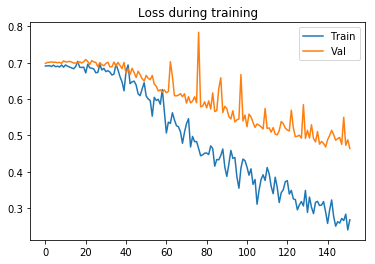

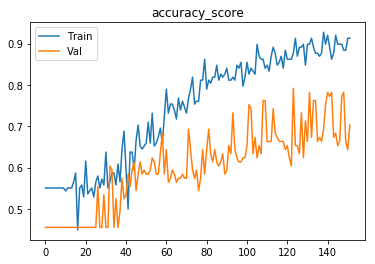

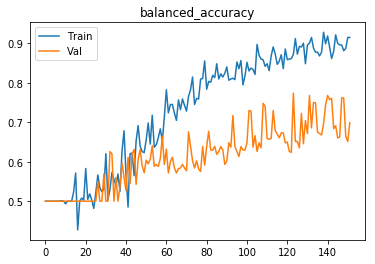

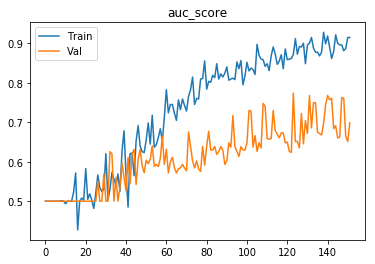

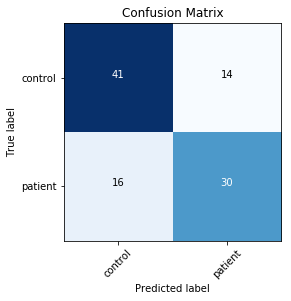

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    10] loss: 0.70702
[0,    20] loss: 0.70167
Time elapsed: 0h:0m:2s
train accuracy_score: 43.48 %
train balanced_accuracy: 47.94 %
train auc_score: 47.94 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691844
[1,    10] loss: 0.68672
[1,    20] loss: 0.69965
Time elapsed: 0h:0m:6s
train accuracy_score: 49.28 %
train balanced_accuracy: 45.48 %
train auc_score: 45.48 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.721396
[2,    10] loss: 0.68161
[2,    20] loss: 0.69570
Time elapsed: 0h:0m:10s
train accuracy_score: 52.17 %
train balanced_accuracy: 48.11 %
train auc_score: 48.11 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694025
[3,    10] loss: 0.69537
[3,    20] loss: 0.69415
Time elapsed: 0h:0m:14s
train ac

val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701004
[31,    10] loss: 0.68358
[31,    20] loss: 0.68124
Time elapsed: 0h:2m:9s
train accuracy_score: 55.80 %
train balanced_accuracy: 51.10 %
train auc_score: 51.10 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.703925
[32,    10] loss: 0.70532
[32,    20] loss: 0.68432
Time elapsed: 0h:2m:12s
train accuracy_score: 55.07 %
train balanced_accuracy: 51.78 %
train auc_score: 51.78 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705892
[33,    10] loss: 0.69804
[33,    20] loss: 0.68618
Time elapsed: 0h:2m:17s
train accuracy_score: 55.07 %
train balanced_accuracy: 50.59 %
train auc_score: 50.59 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705029
[34,    10] loss: 0.69865
[34,    20] loss: 0.70814
Time elapsed: 0h:2m:20s
train accuracy_score: 51.45 %

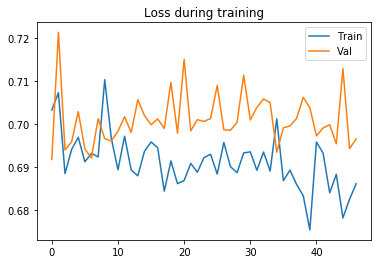

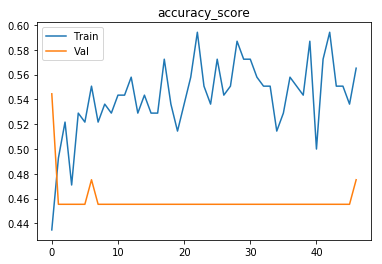

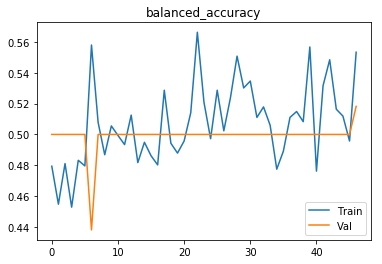

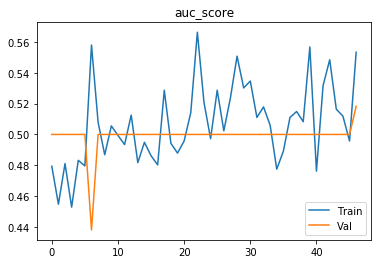

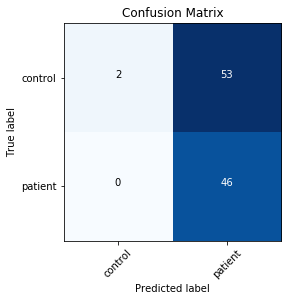

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.69947
[0,    20] loss: 0.70083
[0,    30] loss: 0.71255
Time elapsed: 0h:0m:4s
train accuracy_score: 52.17 %
train balanced_accuracy: 52.27 %
train auc_score: 52.27 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.689496
[1,    10] loss: 0.69988
[1,    20] loss: 0.71452
[1,    30] loss: 0.70783
Time elapsed: 0h:0m:11s
train accuracy_score: 44.20 %
train balanced_accuracy: 43.85 %
train auc_score: 43.85 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694896
[2,    10] loss: 0.69135
[2,    20] loss: 0.67933
[2,    30] loss: 0.68020
Time elapsed: 0h:0m:18s
train accuracy_score: 51.45 %
train balanced_accuracy: 47.45 %
train auc_score: 47.45 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.709487
[3,   

[28,    10] loss: 0.68241
[28,    20] loss: 0.68278
[28,    30] loss: 0.67417
Time elapsed: 0h:3m:13s
train accuracy_score: 61.59 %
train balanced_accuracy: 58.45 %
train auc_score: 58.45 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693570
[29,    10] loss: 0.66504
[29,    20] loss: 0.68837
[29,    30] loss: 0.66448
Time elapsed: 0h:3m:19s
train accuracy_score: 57.25 %
train balanced_accuracy: 53.01 %
train auc_score: 53.01 %
val accuracy_score: 57.43 %
val balanced_accuracy: 60.20 %
val auc_score: 60.20 %
Val loss: 0.678279
[30,    10] loss: 0.65666
[30,    20] loss: 0.67902
[30,    30] loss: 0.66714
Time elapsed: 0h:3m:26s
train accuracy_score: 59.42 %
train balanced_accuracy: 55.88 %
train auc_score: 55.88 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.692620
[31,    10] loss: 0.70268
[31,    20] loss: 0.65279
[31,    30] loss: 0.69992
Time elapsed: 0h:3m:33s
train accuracy_score: 54.

[56,    30] loss: 0.12443
Time elapsed: 0h:6m:20s
train accuracy_score: 96.38 %
train balanced_accuracy: 96.41 %
train auc_score: 96.41 %
val accuracy_score: 74.26 %
val balanced_accuracy: 74.05 %
val auc_score: 74.05 %
Val loss: 0.577899
[57,    10] loss: 0.16094
[57,    20] loss: 0.17180
[57,    30] loss: 0.13070
Time elapsed: 0h:6m:27s
train accuracy_score: 94.93 %
train balanced_accuracy: 94.95 %
train auc_score: 94.95 %
val accuracy_score: 65.35 %
val balanced_accuracy: 67.47 %
val auc_score: 67.47 %
Val loss: 0.935119
[58,    10] loss: 0.27609
[58,    20] loss: 0.16790
[58,    30] loss: 0.18990
Time elapsed: 0h:6m:34s
train accuracy_score: 91.30 %
train balanced_accuracy: 91.21 %
train auc_score: 91.21 %
val accuracy_score: 74.26 %
val balanced_accuracy: 73.52 %
val auc_score: 73.52 %
Val loss: 0.580784
[59,    10] loss: 0.11158
[59,    20] loss: 0.08546
[59,    30] loss: 0.13824
Time elapsed: 0h:6m:41s
train accuracy_score: 95.65 %
train balanced_accuracy: 95.46 %
train auc_scor

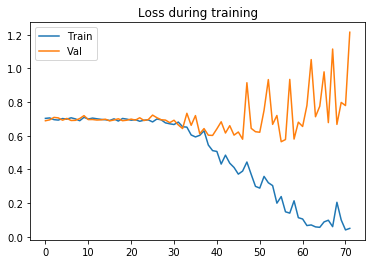

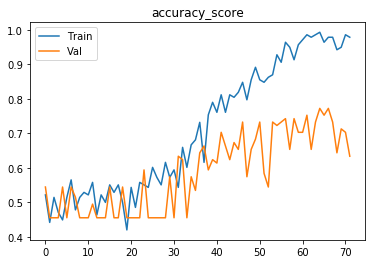

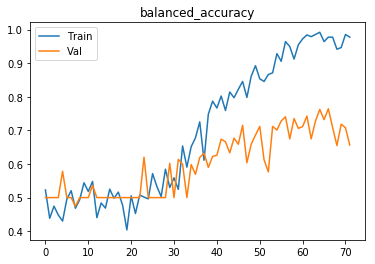

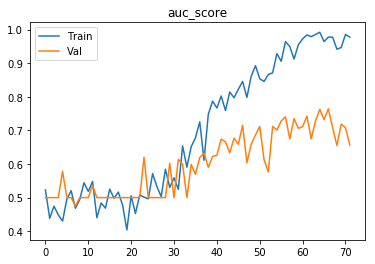

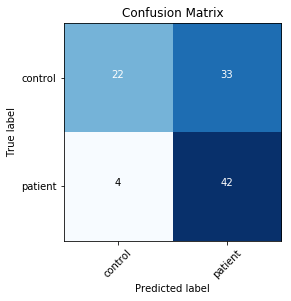

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.68434
[0,    20] loss: 0.71209
Time elapsed: 0h:0m:4s
train accuracy_score: 51.45 %
train balanced_accuracy: 47.75 %
train auc_score: 47.75 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697666
[1,    10] loss: 0.69593
[1,    20] loss: 0.69582
Time elapsed: 0h:0m:10s
train accuracy_score: 52.90 %
train balanced_accuracy: 48.77 %
train auc_score: 48.77 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695713
[2,    10] loss: 0.68673
[2,    20] loss: 0.68384
Time elapsed: 0h:0m:16s
train accuracy_score: 56.52 %
train balanced_accuracy: 51.61 %
train auc_score: 51.61 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705116
[3,    10] loss: 0.69892
[3,    20] loss: 0.69408
Time elapsed: 0h:0m:23s
train ac

val accuracy_score: 59.41 %
val balanced_accuracy: 60.77 %
val auc_score: 60.77 %
Val loss: 0.682557
[31,    10] loss: 0.67193
[31,    20] loss: 0.64663
Time elapsed: 0h:3m:15s
train accuracy_score: 62.32 %
train balanced_accuracy: 61.18 %
train auc_score: 61.18 %
val accuracy_score: 52.48 %
val balanced_accuracy: 55.83 %
val auc_score: 55.83 %
Val loss: 0.701330
[32,    10] loss: 0.58761
[32,    20] loss: 0.66539
Time elapsed: 0h:3m:22s
train accuracy_score: 61.59 %
train balanced_accuracy: 59.93 %
train auc_score: 59.93 %
val accuracy_score: 52.48 %
val balanced_accuracy: 48.54 %
val auc_score: 48.54 %
Val loss: 0.732581
[33,    10] loss: 0.69460
[33,    20] loss: 0.66993
Time elapsed: 0h:3m:28s
train accuracy_score: 55.80 %
train balanced_accuracy: 54.37 %
train auc_score: 54.37 %
val accuracy_score: 58.42 %
val balanced_accuracy: 58.44 %
val auc_score: 58.44 %
Val loss: 0.678081
[34,    10] loss: 0.65252
[34,    20] loss: 0.64661
Time elapsed: 0h:3m:34s
train accuracy_score: 65.22 

val accuracy_score: 67.33 %
val balanced_accuracy: 66.44 %
val auc_score: 66.44 %
Val loss: 0.578793
[62,    10] loss: 0.36485
[62,    20] loss: 0.42298
Time elapsed: 0h:6m:28s
train accuracy_score: 83.33 %
train balanced_accuracy: 83.38 %
train auc_score: 83.38 %
val accuracy_score: 60.40 %
val balanced_accuracy: 60.97 %
val auc_score: 60.97 %
Val loss: 0.627478
[63,    10] loss: 0.40927
[63,    20] loss: 0.43427
Time elapsed: 0h:6m:34s
train accuracy_score: 78.26 %
train balanced_accuracy: 77.59 %
train auc_score: 77.59 %
val accuracy_score: 61.39 %
val balanced_accuracy: 62.23 %
val auc_score: 62.23 %
Val loss: 0.582254
[64,    10] loss: 0.32304
[64,    20] loss: 0.45071
Time elapsed: 0h:6m:41s
train accuracy_score: 83.33 %
train balanced_accuracy: 83.68 %
train auc_score: 83.68 %
val accuracy_score: 58.42 %
val balanced_accuracy: 61.82 %
val auc_score: 61.82 %
Val loss: 0.795427
[65,    10] loss: 0.51247
[65,    20] loss: 0.36532
Time elapsed: 0h:6m:47s
train accuracy_score: 77.54 

val accuracy_score: 68.32 %
val balanced_accuracy: 68.77 %
val auc_score: 68.77 %
Val loss: 0.517910
[93,    10] loss: 0.26654
[93,    20] loss: 0.28936
Time elapsed: 0h:9m:41s
train accuracy_score: 89.86 %
train balanced_accuracy: 89.90 %
train auc_score: 89.90 %
val accuracy_score: 72.28 %
val balanced_accuracy: 70.81 %
val auc_score: 70.81 %
Val loss: 0.537538
[94,    10] loss: 0.25393
[94,    20] loss: 0.19367
Time elapsed: 0h:9m:47s
train accuracy_score: 89.13 %
train balanced_accuracy: 89.09 %
train auc_score: 89.09 %
val accuracy_score: 69.31 %
val balanced_accuracy: 68.08 %
val auc_score: 68.08 %
Val loss: 0.503591
[95,    10] loss: 0.27223
[95,    20] loss: 0.20345
Time elapsed: 0h:9m:54s
train accuracy_score: 90.58 %
train balanced_accuracy: 90.70 %
train auc_score: 90.70 %
val accuracy_score: 70.30 %
val balanced_accuracy: 69.17 %
val auc_score: 69.17 %
Val loss: 0.562570
[96,    10] loss: 0.26133
[96,    20] loss: 0.20103
Time elapsed: 0h:10m:0s
train accuracy_score: 88.41 

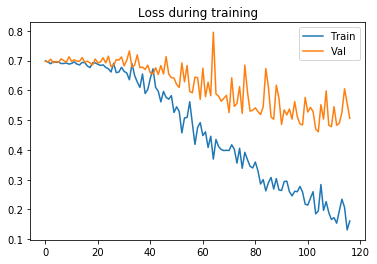

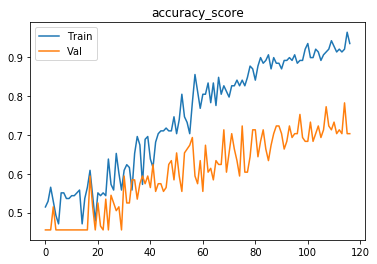

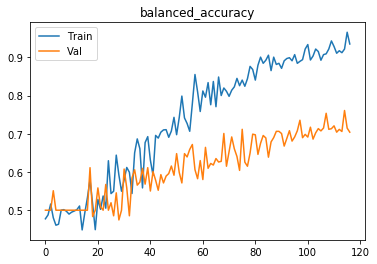

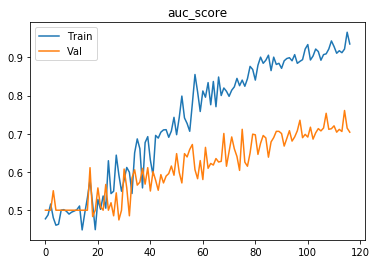

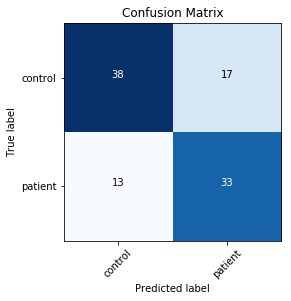

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69319
[0,    20] loss: 0.70826
Time elapsed: 0h:0m:2s
train accuracy_score: 47.10 %
train balanced_accuracy: 44.55 %
train auc_score: 44.55 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698006
[1,    10] loss: 0.69521
[1,    20] loss: 0.69203
Time elapsed: 0h:0m:6s
train accuracy_score: 55.07 %
train balanced_accuracy: 50.74 %
train auc_score: 50.74 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696592
[2,    10] loss: 0.69622
[2,    20] loss: 0.69516
Time elapsed: 0h:0m:10s
train accuracy_score: 54.35 %
train balanced_accuracy: 49.34 %
train auc_score: 49.34 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697577
[3,    10] loss: 0.68845
[3,    20] loss: 0.69459
Time elapsed: 0h:0m:14s
train acc

val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700925
[31,    10] loss: 0.68373
[31,    20] loss: 0.70571
Time elapsed: 0h:2m:7s
train accuracy_score: 53.62 %
train balanced_accuracy: 48.68 %
train auc_score: 48.68 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701896
[32,    10] loss: 0.69773
[32,    20] loss: 0.68254
Time elapsed: 0h:2m:11s
train accuracy_score: 57.97 %
train balanced_accuracy: 53.37 %
train auc_score: 53.37 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697201
[33,    10] loss: 0.69468
[33,    20] loss: 0.68233
Time elapsed: 0h:2m:15s
train accuracy_score: 52.90 %
train balanced_accuracy: 48.17 %
train auc_score: 48.17 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700181
[34,    10] loss: 0.67997
[34,    20] loss: 0.68626
Time elapsed: 0h:2m:19s
train accuracy_score: 54.35 %

val accuracy_score: 54.46 %
val balanced_accuracy: 54.09 %
val auc_score: 54.09 %
Val loss: 0.668072
[62,    10] loss: 0.64654
[62,    20] loss: 0.63858
Time elapsed: 0h:4m:12s
train accuracy_score: 65.22 %
train balanced_accuracy: 63.07 %
train auc_score: 63.07 %
val accuracy_score: 52.48 %
val balanced_accuracy: 52.45 %
val auc_score: 52.45 %
Val loss: 0.666109
[63,    10] loss: 0.65604
[63,    20] loss: 0.67843
Time elapsed: 0h:4m:16s
train accuracy_score: 55.07 %
train balanced_accuracy: 53.57 %
train auc_score: 53.57 %
val accuracy_score: 56.44 %
val balanced_accuracy: 54.31 %
val auc_score: 54.31 %
Val loss: 0.656772
[64,    10] loss: 0.63905
[64,    20] loss: 0.70279
Time elapsed: 0h:4m:20s
train accuracy_score: 58.70 %
train balanced_accuracy: 56.71 %
train auc_score: 56.71 %
val accuracy_score: 52.48 %
val balanced_accuracy: 56.01 %
val auc_score: 56.01 %
Val loss: 0.674433
[65,    10] loss: 0.64918
[65,    20] loss: 0.67346
Time elapsed: 0h:4m:24s
train accuracy_score: 60.87 

val accuracy_score: 53.47 %
val balanced_accuracy: 53.00 %
val auc_score: 53.00 %
Val loss: 0.636375
[93,    10] loss: 0.58694
[93,    20] loss: 0.60054
Time elapsed: 0h:6m:19s
train accuracy_score: 72.46 %
train balanced_accuracy: 72.62 %
train auc_score: 72.62 %
val accuracy_score: 55.45 %
val balanced_accuracy: 56.42 %
val auc_score: 56.42 %
Val loss: 0.661873
[94,    10] loss: 0.54845
[94,    20] loss: 0.64079
Time elapsed: 0h:6m:23s
train accuracy_score: 71.01 %
train balanced_accuracy: 70.42 %
train auc_score: 70.42 %
val accuracy_score: 56.44 %
val balanced_accuracy: 57.51 %
val auc_score: 57.51 %
Val loss: 0.661955
[95,    10] loss: 0.59604
[95,    20] loss: 0.50928
Time elapsed: 0h:6m:27s
train accuracy_score: 74.64 %
train balanced_accuracy: 73.85 %
train auc_score: 73.85 %
val accuracy_score: 53.47 %
val balanced_accuracy: 53.00 %
val auc_score: 53.00 %
Val loss: 0.640159
[96,    10] loss: 0.60605
[96,    20] loss: 0.59690
Time elapsed: 0h:6m:31s
train accuracy_score: 68.12 

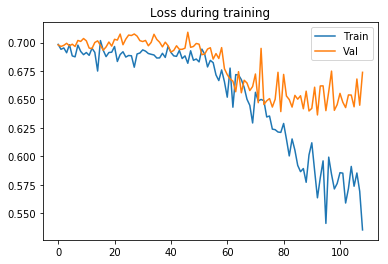

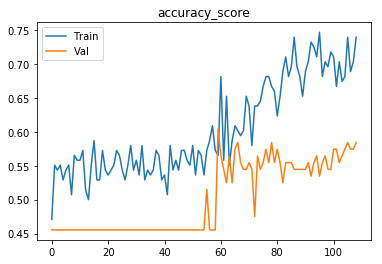

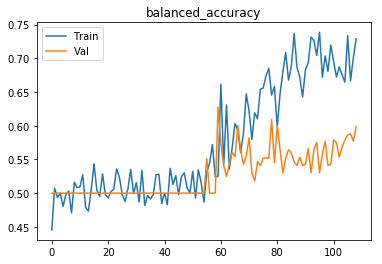

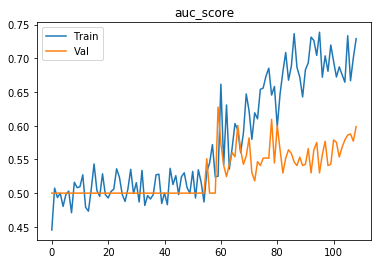

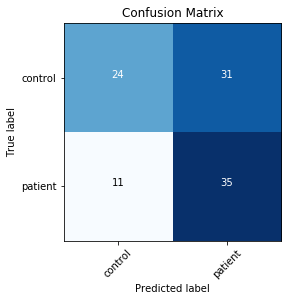

Finished outer fold.
{'final_acc': 0.7041501976284585, 'best_acc': 0.7608695652173914, 'final_iter': 117, 'best_iter': 115, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}
###### Starting outer fold 3
# of patients 98, # of healthy controls 141
141
98
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.68747
[0,    20] loss: 0.68826
Time elapsed: 0h:0m:2s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.677526
[1,    10] loss: 0.68685
[1,    20] loss: 0.68973
Time elapsed: 0h:0m:6s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.677750
[2,    10] loss: 0.68099
[2,    20] loss: 0.

val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.666809
[30,    10] loss: 0.66527
[30,    20] loss: 0.69028
Time elapsed: 0h:2m:4s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.667216
[31,    10] loss: 0.66245
[31,    20] loss: 0.70728
Time elapsed: 0h:2m:8s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.669659
[32,    10] loss: 0.68936
[32,    20] loss: 0.66103
Time elapsed: 0h:2m:12s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.668168
[33,    10] loss: 0.69280
[33,    20] loss: 0.67821
Time elapsed: 0h:2m:16s
train accuracy_score: 57.45 %


val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.645572
[61,    10] loss: 0.65098
[61,    20] loss: 0.66556
Time elapsed: 0h:4m:10s
train accuracy_score: 58.87 %
train balanced_accuracy: 51.67 %
train auc_score: 51.67 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.640127
[62,    10] loss: 0.63487
[62,    20] loss: 0.68224
Time elapsed: 0h:4m:14s
train accuracy_score: 63.12 %
train balanced_accuracy: 57.31 %
train auc_score: 57.31 %
val accuracy_score: 72.45 %
val balanced_accuracy: 65.92 %
val auc_score: 65.92 %
Val loss: 0.651035
[63,    10] loss: 0.63890
[63,    20] loss: 0.63964
Time elapsed: 0h:4m:19s
train accuracy_score: 63.83 %
train balanced_accuracy: 59.44 %
train auc_score: 59.44 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.626263
[64,    10] loss: 0.62950
[64,    20] loss: 0.64970
Time elapsed: 0h:4m:23s
train accuracy_score: 60.28 

val accuracy_score: 77.55 %
val balanced_accuracy: 75.88 %
val auc_score: 75.88 %
Val loss: 0.560106
[92,    10] loss: 0.60352
[92,    20] loss: 0.54954
Time elapsed: 0h:6m:17s
train accuracy_score: 69.50 %
train balanced_accuracy: 69.35 %
train auc_score: 69.35 %
val accuracy_score: 78.57 %
val balanced_accuracy: 76.23 %
val auc_score: 76.23 %
Val loss: 0.551997
[93,    10] loss: 0.54672
[93,    20] loss: 0.52440
Time elapsed: 0h:6m:21s
train accuracy_score: 73.76 %
train balanced_accuracy: 72.19 %
train auc_score: 72.19 %
val accuracy_score: 77.55 %
val balanced_accuracy: 72.50 %
val auc_score: 72.50 %
Val loss: 0.542541
[94,    10] loss: 0.60909
[94,    20] loss: 0.52553
Time elapsed: 0h:6m:25s
train accuracy_score: 70.92 %
train balanced_accuracy: 68.86 %
train auc_score: 68.86 %
val accuracy_score: 74.49 %
val balanced_accuracy: 73.38 %
val auc_score: 73.38 %
Val loss: 0.548078
[95,    10] loss: 0.58926
[95,    20] loss: 0.55079
Time elapsed: 0h:6m:29s
train accuracy_score: 70.92 

val accuracy_score: 66.33 %
val balanced_accuracy: 65.75 %
val auc_score: 65.75 %
Val loss: 0.522134
[123,    10] loss: 0.51485
[123,    20] loss: 0.42409
Time elapsed: 0h:8m:24s
train accuracy_score: 78.72 %
train balanced_accuracy: 77.38 %
train auc_score: 77.38 %
val accuracy_score: 66.33 %
val balanced_accuracy: 65.75 %
val auc_score: 65.75 %
Val loss: 0.522354
[124,    10] loss: 0.56387
[124,    20] loss: 0.44480
Time elapsed: 0h:8m:28s
train accuracy_score: 78.01 %
train balanced_accuracy: 77.41 %
train auc_score: 77.41 %
val accuracy_score: 72.45 %
val balanced_accuracy: 70.26 %
val auc_score: 70.26 %
Val loss: 0.511002
[125,    10] loss: 0.46683
[125,    20] loss: 0.50928
Time elapsed: 0h:8m:32s
train accuracy_score: 76.60 %
train balanced_accuracy: 75.52 %
train auc_score: 75.52 %
val accuracy_score: 70.41 %
val balanced_accuracy: 68.60 %
val auc_score: 68.60 %
Val loss: 0.509361
[126,    10] loss: 0.44234
[126,    20] loss: 0.47714
Time elapsed: 0h:8m:36s
train accuracy_score

val accuracy_score: 74.49 %
val balanced_accuracy: 71.45 %
val auc_score: 71.45 %
Val loss: 0.474612
[154,    10] loss: 0.39493
[154,    20] loss: 0.32131
Time elapsed: 0h:10m:31s
train accuracy_score: 87.23 %
train balanced_accuracy: 86.51 %
train auc_score: 86.51 %
val accuracy_score: 72.45 %
val balanced_accuracy: 70.75 %
val auc_score: 70.75 %
Val loss: 0.471545
[155,    10] loss: 0.28318
[155,    20] loss: 0.42757
Time elapsed: 0h:10m:35s
train accuracy_score: 87.23 %
train balanced_accuracy: 86.08 %
train auc_score: 86.08 %
val accuracy_score: 72.45 %
val balanced_accuracy: 76.05 %
val auc_score: 76.05 %
Val loss: 0.549488
[156,    10] loss: 0.34222
[156,    20] loss: 0.32839
Time elapsed: 0h:10m:39s
train accuracy_score: 89.36 %
train balanced_accuracy: 89.01 %
train auc_score: 89.01 %
val accuracy_score: 73.47 %
val balanced_accuracy: 71.58 %
val auc_score: 71.58 %
Val loss: 0.467570
[157,    10] loss: 0.31697
[157,    20] loss: 0.40362
Time elapsed: 0h:10m:44s
train accuracy_s

val accuracy_score: 74.49 %
val balanced_accuracy: 72.89 %
val auc_score: 72.89 %
Val loss: 0.449848
[185,    10] loss: 0.20954
[185,    20] loss: 0.24661
Time elapsed: 0h:12m:39s
train accuracy_score: 92.20 %
train balanced_accuracy: 91.91 %
train auc_score: 91.91 %
val accuracy_score: 75.51 %
val balanced_accuracy: 72.76 %
val auc_score: 72.76 %
Val loss: 0.442068
[186,    10] loss: 0.25029
[186,    20] loss: 0.20919
Time elapsed: 0h:12m:43s
train accuracy_score: 91.49 %
train balanced_accuracy: 90.65 %
train auc_score: 90.65 %
val accuracy_score: 75.51 %
val balanced_accuracy: 72.76 %
val auc_score: 72.76 %
Val loss: 0.441774
[187,    10] loss: 0.22400
[187,    20] loss: 0.21869
Time elapsed: 0h:12m:47s
train accuracy_score: 91.49 %
train balanced_accuracy: 90.86 %
train auc_score: 90.86 %
val accuracy_score: 77.55 %
val balanced_accuracy: 75.39 %
val auc_score: 75.39 %
Val loss: 0.446544
[188,    10] loss: 0.23755
[188,    20] loss: 0.24533
Time elapsed: 0h:12m:51s
train accuracy_s

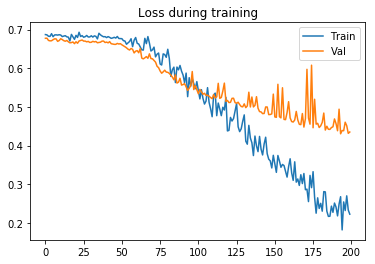

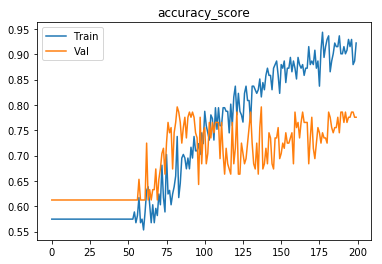

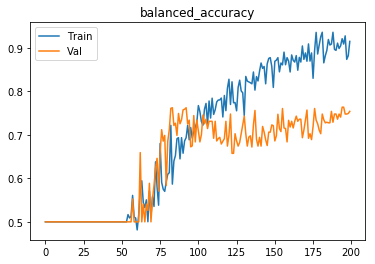

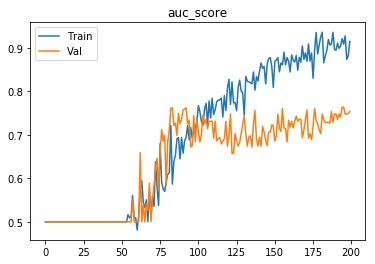

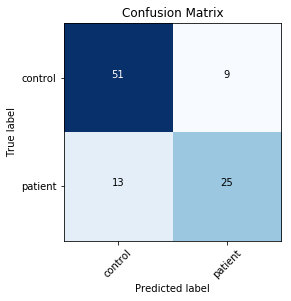

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69828
[0,    20] loss: 0.69558
[0,    30] loss: 0.69045
Time elapsed: 0h:0m:2s
train accuracy_score: 46.81 %
train balanced_accuracy: 47.01 %
train auc_score: 47.01 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.686099
[1,    10] loss: 0.67794
[1,    20] loss: 0.69808
[1,    30] loss: 0.67526
Time elapsed: 0h:0m:7s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.671912
[2,    10] loss: 0.69864
[2,    20] loss: 0.70250
[2,    30] loss: 0.66001
Time elapsed: 0h:0m:11s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.672624
[3,    1

[28,    10] loss: 0.61592
[28,    20] loss: 0.69658
[28,    30] loss: 0.70723
Time elapsed: 0h:2m:6s
train accuracy_score: 60.28 %
train balanced_accuracy: 53.55 %
train auc_score: 53.55 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.639812
[29,    10] loss: 0.64425
[29,    20] loss: 0.65910
[29,    30] loss: 0.67922
Time elapsed: 0h:2m:11s
train accuracy_score: 59.57 %
train balanced_accuracy: 52.72 %
train auc_score: 52.72 %
val accuracy_score: 64.29 %
val balanced_accuracy: 54.43 %
val auc_score: 54.43 %
Val loss: 0.640619
[30,    10] loss: 0.66314
[30,    20] loss: 0.69810
[30,    30] loss: 0.66702
Time elapsed: 0h:2m:15s
train accuracy_score: 59.57 %
train balanced_accuracy: 56.39 %
train auc_score: 56.39 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.636822
[31,    10] loss: 0.67592
[31,    20] loss: 0.66440
[31,    30] loss: 0.64146
Time elapsed: 0h:2m:19s
train accuracy_score: 57.4

[56,    30] loss: 0.51252
Time elapsed: 0h:4m:11s
train accuracy_score: 70.21 %
train balanced_accuracy: 67.16 %
train auc_score: 67.16 %
val accuracy_score: 69.39 %
val balanced_accuracy: 61.97 %
val auc_score: 61.97 %
Val loss: 0.574051
[57,    10] loss: 0.55724
[57,    20] loss: 0.59209
[57,    30] loss: 0.64968
Time elapsed: 0h:4m:15s
train accuracy_score: 66.67 %
train balanced_accuracy: 63.86 %
train auc_score: 63.86 %
val accuracy_score: 61.22 %
val balanced_accuracy: 64.96 %
val auc_score: 64.96 %
Val loss: 0.626755
[58,    10] loss: 0.60044
[58,    20] loss: 0.63295
[58,    30] loss: 0.61070
Time elapsed: 0h:4m:19s
train accuracy_score: 68.09 %
train balanced_accuracy: 66.17 %
train auc_score: 66.17 %
val accuracy_score: 77.55 %
val balanced_accuracy: 74.43 %
val auc_score: 74.43 %
Val loss: 0.583398
[59,    10] loss: 0.55356
[59,    20] loss: 0.60394
[59,    30] loss: 0.56393
Time elapsed: 0h:4m:24s
train accuracy_score: 70.92 %
train balanced_accuracy: 67.13 %
train auc_scor

val accuracy_score: 67.35 %
val balanced_accuracy: 68.03 %
val auc_score: 68.03 %
Val loss: 0.549287
[85,    10] loss: 0.53279
[85,    20] loss: 0.42299
[85,    30] loss: 0.48683
Time elapsed: 0h:6m:20s
train accuracy_score: 75.18 %
train balanced_accuracy: 73.86 %
train auc_score: 73.86 %
val accuracy_score: 74.49 %
val balanced_accuracy: 70.48 %
val auc_score: 70.48 %
Val loss: 0.518278
[86,    10] loss: 0.49293
[86,    20] loss: 0.40196
[86,    30] loss: 0.52077
Time elapsed: 0h:6m:24s
train accuracy_score: 77.30 %
train balanced_accuracy: 75.93 %
train auc_score: 75.93 %
val accuracy_score: 69.39 %
val balanced_accuracy: 66.80 %
val auc_score: 66.80 %
Val loss: 0.522933
[87,    10] loss: 0.46306
[87,    20] loss: 0.53502
[87,    30] loss: 0.55216
Time elapsed: 0h:6m:29s
train accuracy_score: 80.14 %
train balanced_accuracy: 79.26 %
train auc_score: 79.26 %
val accuracy_score: 73.47 %
val balanced_accuracy: 69.65 %
val auc_score: 69.65 %
Val loss: 0.519277
[88,    10] loss: 0.56352


[113,    10] loss: 0.33366
[113,    20] loss: 0.35575
[113,    30] loss: 0.38880
Time elapsed: 0h:8m:23s
train accuracy_score: 86.52 %
train balanced_accuracy: 86.11 %
train auc_score: 86.11 %
val accuracy_score: 67.35 %
val balanced_accuracy: 65.61 %
val auc_score: 65.61 %
Val loss: 0.514754
[114,    10] loss: 0.30903
[114,    20] loss: 0.40466
[114,    30] loss: 0.50368
Time elapsed: 0h:8m:28s
train accuracy_score: 89.36 %
train balanced_accuracy: 88.36 %
train auc_score: 88.36 %
val accuracy_score: 66.33 %
val balanced_accuracy: 66.71 %
val auc_score: 66.71 %
Val loss: 0.544650
[115,    10] loss: 0.42842
[115,    20] loss: 0.29321
[115,    30] loss: 0.38365
Time elapsed: 0h:8m:32s
train accuracy_score: 85.82 %
train balanced_accuracy: 84.63 %
train auc_score: 84.63 %
val accuracy_score: 67.35 %
val balanced_accuracy: 68.03 %
val auc_score: 68.03 %
Val loss: 0.553108
[116,    10] loss: 0.40975
[116,    20] loss: 0.34757
[116,    30] loss: 0.30391
Time elapsed: 0h:8m:37s
train accurac

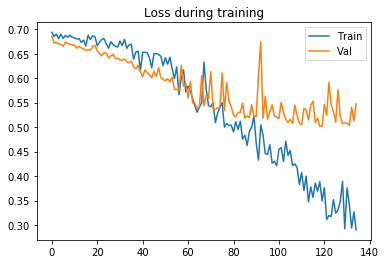

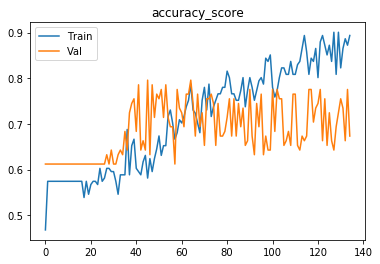

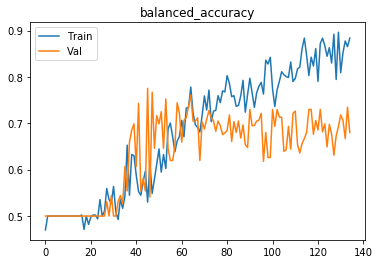

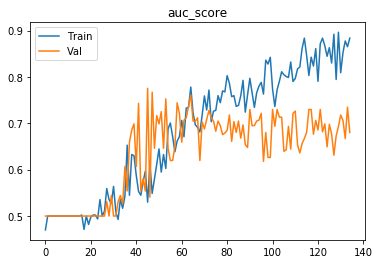

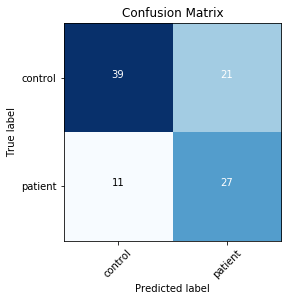

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.68752
Time elapsed: 0h:0m:4s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.680016
[1,    10] loss: 0.68324
Time elapsed: 0h:0m:10s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.672014
[2,    10] loss: 0.67336
Time elapsed: 0h:0m:16s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.665090
[3,    10] loss: 0.69204
Time elapsed: 0h:0m:22s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score:

[34,    10] loss: 0.62630
Time elapsed: 0h:3m:30s
train accuracy_score: 58.16 %
train balanced_accuracy: 51.05 %
train auc_score: 51.05 %
val accuracy_score: 62.24 %
val balanced_accuracy: 51.32 %
val auc_score: 51.32 %
Val loss: 0.622741
[35,    10] loss: 0.65872
Time elapsed: 0h:3m:36s
train accuracy_score: 60.28 %
train balanced_accuracy: 58.09 %
train auc_score: 58.09 %
val accuracy_score: 75.51 %
val balanced_accuracy: 70.35 %
val auc_score: 70.35 %
Val loss: 0.631849
[36,    10] loss: 0.61952
Time elapsed: 0h:3m:42s
train accuracy_score: 60.99 %
train balanced_accuracy: 55.03 %
train auc_score: 55.03 %
val accuracy_score: 62.24 %
val balanced_accuracy: 51.32 %
val auc_score: 51.32 %
Val loss: 0.610482
[37,    10] loss: 0.64895
Time elapsed: 0h:3m:48s
train accuracy_score: 58.16 %
train balanced_accuracy: 58.61 %
train auc_score: 58.61 %
val accuracy_score: 73.47 %
val balanced_accuracy: 67.24 %
val auc_score: 67.24 %
Val loss: 0.607499
[38,    10] loss: 0.62005
Time elapsed: 0h:3

val accuracy_score: 69.39 %
val balanced_accuracy: 70.18 %
val auc_score: 70.18 %
Val loss: 0.532500
[69,    10] loss: 0.37758
Time elapsed: 0h:7m:0s
train accuracy_score: 82.98 %
train balanced_accuracy: 82.16 %
train auc_score: 82.16 %
val accuracy_score: 76.53 %
val balanced_accuracy: 73.11 %
val auc_score: 73.11 %
Val loss: 0.500052
[70,    10] loss: 0.41615
Time elapsed: 0h:7m:6s
train accuracy_score: 82.27 %
train balanced_accuracy: 80.68 %
train auc_score: 80.68 %
val accuracy_score: 71.43 %
val balanced_accuracy: 69.91 %
val auc_score: 69.91 %
Val loss: 0.508418
[71,    10] loss: 0.38457
Time elapsed: 0h:7m:12s
train accuracy_score: 82.98 %
train balanced_accuracy: 82.38 %
train auc_score: 82.38 %
val accuracy_score: 73.47 %
val balanced_accuracy: 69.65 %
val auc_score: 69.65 %
Val loss: 0.499556
[72,    10] loss: 0.42290
Time elapsed: 0h:7m:18s
train accuracy_score: 81.56 %
train balanced_accuracy: 80.93 %
train auc_score: 80.93 %
val accuracy_score: 74.49 %
val balanced_accur

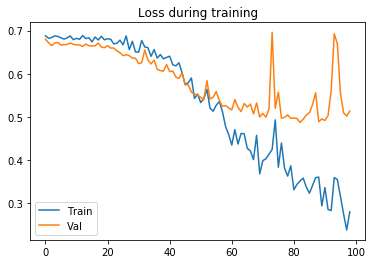

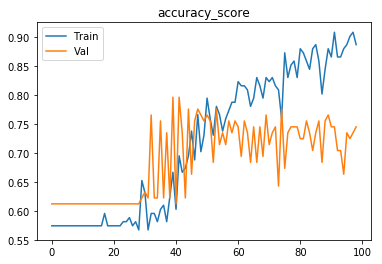

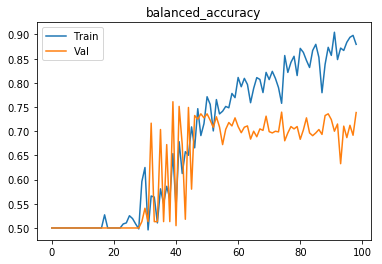

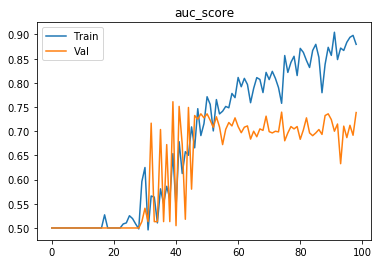

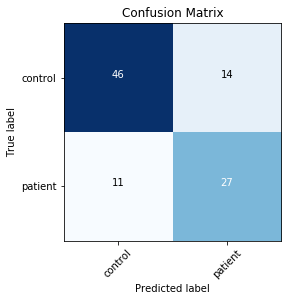

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.69001
Time elapsed: 0h:0m:4s
train accuracy_score: 50.35 %
train balanced_accuracy: 46.64 %
train auc_score: 46.64 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.665010
[1,    10] loss: 0.69503
Time elapsed: 0h:0m:10s
train accuracy_score: 58.16 %
train balanced_accuracy: 50.83 %
train auc_score: 50.83 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.678992
[2,    10] loss: 0.68084
Time elapsed: 0h:0m:16s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.663630
[3,    10] loss: 0.69218
Time elapsed: 0h:0m:22s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score

[34,    10] loss: 0.52972
Time elapsed: 0h:3m:27s
train accuracy_score: 72.34 %
train balanced_accuracy: 69.88 %
train auc_score: 69.88 %
val accuracy_score: 66.33 %
val balanced_accuracy: 69.61 %
val auc_score: 69.61 %
Val loss: 0.621764
[35,    10] loss: 0.58418
Time elapsed: 0h:3m:33s
train accuracy_score: 75.89 %
train balanced_accuracy: 75.34 %
train auc_score: 75.34 %
val accuracy_score: 72.45 %
val balanced_accuracy: 68.33 %
val auc_score: 68.33 %
Val loss: 0.539005
[36,    10] loss: 0.57479
Time elapsed: 0h:3m:39s
train accuracy_score: 73.05 %
train balanced_accuracy: 72.65 %
train auc_score: 72.65 %
val accuracy_score: 68.37 %
val balanced_accuracy: 68.38 %
val auc_score: 68.38 %
Val loss: 0.545209
[37,    10] loss: 0.53147
Time elapsed: 0h:3m:45s
train accuracy_score: 79.43 %
train balanced_accuracy: 78.43 %
train auc_score: 78.43 %
val accuracy_score: 79.59 %
val balanced_accuracy: 75.61 %
val auc_score: 75.61 %
Val loss: 0.515865
[38,    10] loss: 0.54216
Time elapsed: 0h:3

val accuracy_score: 84.69 %
val balanced_accuracy: 84.61 %
val auc_score: 84.61 %
Val loss: 0.386584
[69,    10] loss: 0.23833
Time elapsed: 0h:6m:57s
train accuracy_score: 92.91 %
train balanced_accuracy: 92.53 %
train auc_score: 92.53 %
val accuracy_score: 83.67 %
val balanced_accuracy: 85.22 %
val auc_score: 85.22 %
Val loss: 0.409660
[70,    10] loss: 0.21181
Time elapsed: 0h:7m:3s
train accuracy_score: 91.49 %
train balanced_accuracy: 90.65 %
train auc_score: 90.65 %
val accuracy_score: 83.67 %
val balanced_accuracy: 82.32 %
val auc_score: 82.32 %
Val loss: 0.368089
[71,    10] loss: 0.28423
Time elapsed: 0h:7m:9s
train accuracy_score: 89.36 %
train balanced_accuracy: 89.01 %
train auc_score: 89.01 %
val accuracy_score: 77.55 %
val balanced_accuracy: 73.46 %
val auc_score: 73.46 %
Val loss: 0.442875
[72,    10] loss: 0.23366
Time elapsed: 0h:7m:15s
train accuracy_score: 92.91 %
train balanced_accuracy: 92.53 %
train auc_score: 92.53 %
val accuracy_score: 79.59 %
val balanced_accur

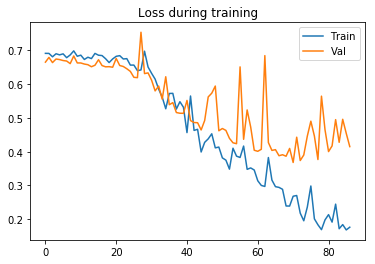

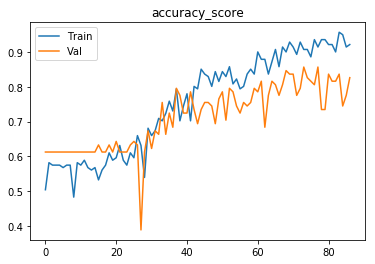

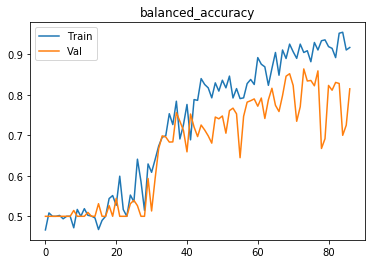

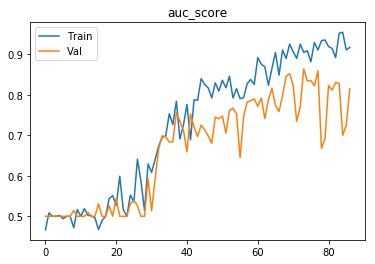

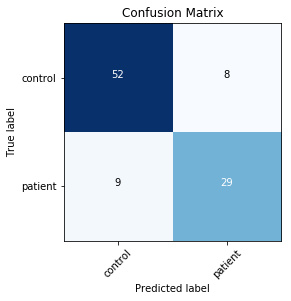

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.68684
[0,    20] loss: 0.68473
[0,    30] loss: 0.69326
Time elapsed: 0h:0m:4s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.667848
[1,    10] loss: 0.70683
[1,    20] loss: 0.67737
[1,    30] loss: 0.67965
Time elapsed: 0h:0m:11s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.666949
[2,    10] loss: 0.66439
[2,    20] loss: 0.70028
[2,    30] loss: 0.65416
Time elapsed: 0h:0m:18s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.671576
[3,    

[28,    10] loss: 0.60458
[28,    20] loss: 0.65885
[28,    30] loss: 0.64359
Time elapsed: 0h:3m:14s
train accuracy_score: 60.28 %
train balanced_accuracy: 53.55 %
train auc_score: 53.55 %
val accuracy_score: 70.41 %
val balanced_accuracy: 71.49 %
val auc_score: 71.49 %
Val loss: 0.642089
[29,    10] loss: 0.65312
[29,    20] loss: 0.62998
[29,    30] loss: 0.69709
Time elapsed: 0h:3m:21s
train accuracy_score: 60.28 %
train balanced_accuracy: 56.14 %
train auc_score: 56.14 %
val accuracy_score: 79.59 %
val balanced_accuracy: 75.61 %
val auc_score: 75.61 %
Val loss: 0.628265
[30,    10] loss: 0.62542
[30,    20] loss: 0.62990
[30,    30] loss: 0.67716
Time elapsed: 0h:3m:28s
train accuracy_score: 68.79 %
train balanced_accuracy: 64.41 %
train auc_score: 64.41 %
val accuracy_score: 67.35 %
val balanced_accuracy: 68.99 %
val auc_score: 68.99 %
Val loss: 0.624400
[31,    10] loss: 0.59680
[31,    20] loss: 0.57072
[31,    30] loss: 0.57644
Time elapsed: 0h:3m:35s
train accuracy_score: 71.

[56,    30] loss: 0.36050
Time elapsed: 0h:6m:25s
train accuracy_score: 83.69 %
train balanced_accuracy: 83.21 %
train auc_score: 83.21 %
val accuracy_score: 79.59 %
val balanced_accuracy: 74.65 %
val auc_score: 74.65 %
Val loss: 0.467210
[57,    10] loss: 0.34421
[57,    20] loss: 0.40866
[57,    30] loss: 0.23846
Time elapsed: 0h:6m:32s
train accuracy_score: 83.69 %
train balanced_accuracy: 82.56 %
train auc_score: 82.56 %
val accuracy_score: 78.57 %
val balanced_accuracy: 75.26 %
val auc_score: 75.26 %
Val loss: 0.454867
[58,    10] loss: 0.47014
[58,    20] loss: 0.40505
[58,    30] loss: 0.31932
Time elapsed: 0h:6m:39s
train accuracy_score: 82.98 %
train balanced_accuracy: 82.16 %
train auc_score: 82.16 %
val accuracy_score: 70.41 %
val balanced_accuracy: 70.04 %
val auc_score: 70.04 %
Val loss: 0.441345
[59,    10] loss: 0.39854
[59,    20] loss: 0.36108
[59,    30] loss: 0.55501
Time elapsed: 0h:6m:46s
train accuracy_score: 85.11 %
train balanced_accuracy: 84.66 %
train auc_scor

val accuracy_score: 79.59 %
val balanced_accuracy: 78.03 %
val auc_score: 78.03 %
Val loss: 0.366063
[85,    10] loss: 0.08384
[85,    20] loss: 0.10136
[85,    30] loss: 0.15565
Time elapsed: 0h:9m:43s
train accuracy_score: 95.74 %
train balanced_accuracy: 95.22 %
train auc_score: 95.22 %
val accuracy_score: 84.69 %
val balanced_accuracy: 84.61 %
val auc_score: 84.61 %
Val loss: 0.385192
[86,    10] loss: 0.09364
[86,    20] loss: 0.12730
[86,    30] loss: 0.17326
Time elapsed: 0h:9m:50s
train accuracy_score: 95.74 %
train balanced_accuracy: 95.65 %
train auc_score: 95.65 %
val accuracy_score: 81.63 %
val balanced_accuracy: 80.18 %
val auc_score: 80.18 %
Val loss: 0.364907
[87,    10] loss: 0.10533
[87,    20] loss: 0.11013
[87,    30] loss: 0.09402
Time elapsed: 0h:9m:57s
train accuracy_score: 95.74 %
train balanced_accuracy: 95.22 %
train auc_score: 95.22 %
val accuracy_score: 79.59 %
val balanced_accuracy: 77.54 %
val auc_score: 77.54 %
Val loss: 0.391193
[88,    10] loss: 0.19348


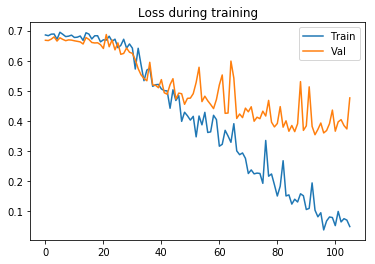

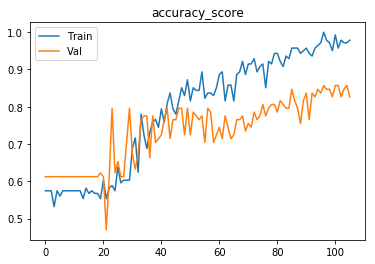

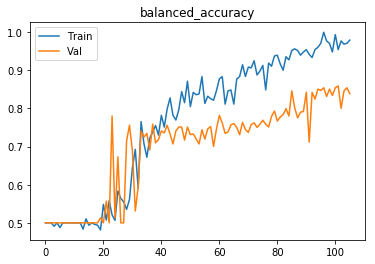

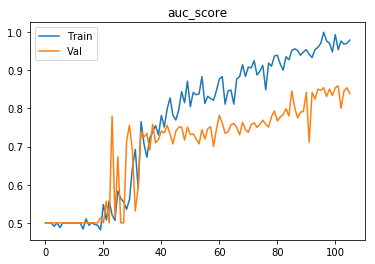

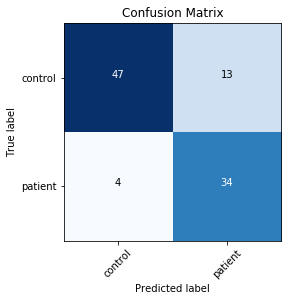

Finished outer fold.
{'final_acc': 0.8390350877192982, 'best_acc': 0.8592105263157894, 'final_iter': 106, 'best_iter': 102, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 4}
###### Starting outer fold 4
# of patients 117, # of healthy controls 126
139
104
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69452
Time elapsed: 0h:0m:2s
train accuracy_score: 49.64 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.690831
[1,    10] loss: 0.69512
Time elapsed: 0h:0m:5s
train accuracy_score: 51.08 %
train balanced_accuracy: 51.37 %
train auc_score: 51.37 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691882
[2,    10] loss: 0.69238
Time elapsed: 0h:0m:9s
train accuracy_score: 52.52 %
train balance

val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.688726
[33,    10] loss: 0.68425
Time elapsed: 0h:2m:8s
train accuracy_score: 55.40 %
train balanced_accuracy: 55.46 %
train auc_score: 55.46 %
val accuracy_score: 54.81 %
val balanced_accuracy: 52.43 %
val auc_score: 52.43 %
Val loss: 0.690291
[34,    10] loss: 0.69961
Time elapsed: 0h:2m:12s
train accuracy_score: 44.60 %
train balanced_accuracy: 44.53 %
train auc_score: 44.53 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693468
[35,    10] loss: 0.69978
Time elapsed: 0h:2m:16s
train accuracy_score: 46.04 %
train balanced_accuracy: 45.94 %
train auc_score: 45.94 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693796
[36,    10] loss: 0.69041
Time elapsed: 0h:2m:20s
train accuracy_score: 53.96 %
train balanced_accuracy: 53.74 %
train auc_score: 53.74 %
val accuracy_score: 45.19 %
val balanced_accu

[67,    10] loss: 0.67915
Time elapsed: 0h:4m:19s
train accuracy_score: 55.40 %
train balanced_accuracy: 55.29 %
train auc_score: 55.29 %
val accuracy_score: 56.73 %
val balanced_accuracy: 55.30 %
val auc_score: 55.30 %
Val loss: 0.682785
[68,    10] loss: 0.68726
Time elapsed: 0h:4m:23s
train accuracy_score: 48.92 %
train balanced_accuracy: 48.92 %
train auc_score: 48.92 %
val accuracy_score: 55.77 %
val balanced_accuracy: 53.68 %
val auc_score: 53.68 %
Val loss: 0.681244
[69,    10] loss: 0.69328
Time elapsed: 0h:4m:26s
train accuracy_score: 55.40 %
train balanced_accuracy: 55.37 %
train auc_score: 55.37 %
val accuracy_score: 56.73 %
val balanced_accuracy: 54.74 %
val auc_score: 54.74 %
Val loss: 0.682277
[70,    10] loss: 0.67882
Time elapsed: 0h:4m:30s
train accuracy_score: 57.55 %
train balanced_accuracy: 57.46 %
train auc_score: 57.46 %
val accuracy_score: 59.62 %
val balanced_accuracy: 59.24 %
val auc_score: 59.24 %
Val loss: 0.683859
[71,    10] loss: 0.68156
Time elapsed: 0h:4

val accuracy_score: 58.65 %
val balanced_accuracy: 55.94 %
val auc_score: 55.94 %
Val loss: 0.652745
[102,    10] loss: 0.65533
Time elapsed: 0h:6m:34s
train accuracy_score: 59.71 %
train balanced_accuracy: 59.93 %
train auc_score: 59.93 %
val accuracy_score: 57.69 %
val balanced_accuracy: 54.87 %
val auc_score: 54.87 %
Val loss: 0.654261
[103,    10] loss: 0.66189
Time elapsed: 0h:6m:38s
train accuracy_score: 64.75 %
train balanced_accuracy: 64.73 %
train auc_score: 64.73 %
val accuracy_score: 69.23 %
val balanced_accuracy: 68.38 %
val auc_score: 68.38 %
Val loss: 0.656768
[104,    10] loss: 0.62949
Time elapsed: 0h:6m:42s
train accuracy_score: 70.50 %
train balanced_accuracy: 70.48 %
train auc_score: 70.48 %
val accuracy_score: 68.27 %
val balanced_accuracy: 66.76 %
val auc_score: 66.76 %
Val loss: 0.651160
[105,    10] loss: 0.67838
Time elapsed: 0h:6m:46s
train accuracy_score: 58.99 %
train balanced_accuracy: 58.96 %
train auc_score: 58.96 %
val accuracy_score: 68.27 %
val balanced

[136,    10] loss: 0.57023
Time elapsed: 0h:8m:45s
train accuracy_score: 71.94 %
train balanced_accuracy: 71.96 %
train auc_score: 71.96 %
val accuracy_score: 71.15 %
val balanced_accuracy: 70.14 %
val auc_score: 70.14 %
Val loss: 0.607172
[137,    10] loss: 0.58397
Time elapsed: 0h:8m:49s
train accuracy_score: 67.63 %
train balanced_accuracy: 67.62 %
train auc_score: 67.62 %
val accuracy_score: 74.04 %
val balanced_accuracy: 73.89 %
val auc_score: 73.89 %
Val loss: 0.609931
[138,    10] loss: 0.60351
Time elapsed: 0h:8m:53s
train accuracy_score: 69.78 %
train balanced_accuracy: 69.76 %
train auc_score: 69.76 %
val accuracy_score: 65.38 %
val balanced_accuracy: 63.57 %
val auc_score: 63.57 %
Val loss: 0.607339
[139,    10] loss: 0.58283
Time elapsed: 0h:8m:57s
train accuracy_score: 66.19 %
train balanced_accuracy: 66.20 %
train auc_score: 66.20 %
val accuracy_score: 71.15 %
val balanced_accuracy: 70.14 %
val auc_score: 70.14 %
Val loss: 0.596790
[140,    10] loss: 0.62510
Time elapsed:

Time elapsed: 0h:10m:57s
train accuracy_score: 77.70 %
train balanced_accuracy: 77.73 %
train auc_score: 77.73 %
val accuracy_score: 78.85 %
val balanced_accuracy: 78.46 %
val auc_score: 78.46 %
Val loss: 0.500260
[171,    10] loss: 0.54859
Time elapsed: 0h:11m:1s
train accuracy_score: 71.22 %
train balanced_accuracy: 71.19 %
train auc_score: 71.19 %
val accuracy_score: 78.85 %
val balanced_accuracy: 78.84 %
val auc_score: 78.84 %
Val loss: 0.496975
[172,    10] loss: 0.53296
Time elapsed: 0h:11m:5s
train accuracy_score: 70.50 %
train balanced_accuracy: 70.51 %
train auc_score: 70.51 %
val accuracy_score: 80.77 %
val balanced_accuracy: 81.15 %
val auc_score: 81.15 %
Val loss: 0.494981
[173,    10] loss: 0.55742
Time elapsed: 0h:11m:9s
train accuracy_score: 71.94 %
train balanced_accuracy: 71.94 %
train auc_score: 71.94 %
val accuracy_score: 77.88 %
val balanced_accuracy: 77.96 %
val auc_score: 77.96 %
Val loss: 0.495939
[174,    10] loss: 0.50769
Time elapsed: 0h:11m:13s
train accuracy

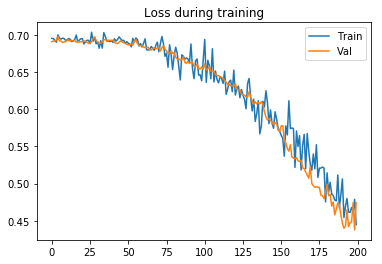

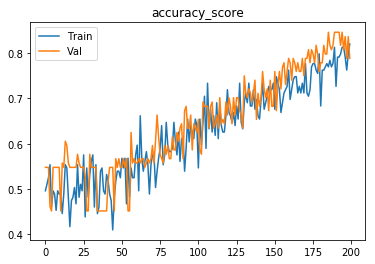

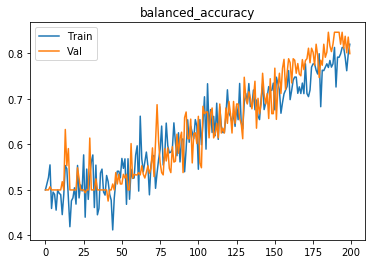

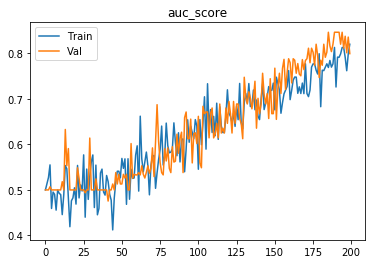

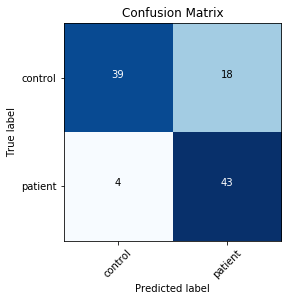

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69436
Time elapsed: 0h:0m:2s
train accuracy_score: 50.36 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697298
[1,    10] loss: 0.69471
Time elapsed: 0h:0m:6s
train accuracy_score: 50.36 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696986
[2,    10] loss: 0.69586
Time elapsed: 0h:0m:9s
train accuracy_score: 49.64 %
train balanced_accuracy: 49.36 %
train auc_score: 49.36 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694024
[3,    10] loss: 0.69191
Time elapsed: 0h:0m:13s
train accuracy_score: 56.12 %
train balanced_accuracy: 55.94 %
train auc_score: 55.94 %
val accuracy_score: 4

[34,    10] loss: 0.62612
Time elapsed: 0h:2m:12s
train accuracy_score: 65.47 %
train balanced_accuracy: 65.52 %
train auc_score: 65.52 %
val accuracy_score: 62.50 %
val balanced_accuracy: 61.31 %
val auc_score: 61.31 %
Val loss: 0.618415
[35,    10] loss: 0.59184
Time elapsed: 0h:2m:16s
train accuracy_score: 63.31 %
train balanced_accuracy: 63.29 %
train auc_score: 63.29 %
val accuracy_score: 64.42 %
val balanced_accuracy: 62.50 %
val auc_score: 62.50 %
Val loss: 0.615856
[36,    10] loss: 0.60955
Time elapsed: 0h:2m:20s
train accuracy_score: 70.50 %
train balanced_accuracy: 70.49 %
train auc_score: 70.49 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.25 %
val auc_score: 60.25 %
Val loss: 0.611823
[37,    10] loss: 0.60582
Time elapsed: 0h:2m:24s
train accuracy_score: 66.19 %
train balanced_accuracy: 66.20 %
train auc_score: 66.20 %
val accuracy_score: 63.46 %
val balanced_accuracy: 61.81 %
val auc_score: 61.81 %
Val loss: 0.610930
[38,    10] loss: 0.61289
Time elapsed: 0h:2

val accuracy_score: 69.23 %
val balanced_accuracy: 68.38 %
val auc_score: 68.38 %
Val loss: 0.560841
[69,    10] loss: 0.54168
Time elapsed: 0h:4m:26s
train accuracy_score: 72.66 %
train balanced_accuracy: 72.64 %
train auc_score: 72.64 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.64 %
val auc_score: 67.64 %
Val loss: 0.559920
[70,    10] loss: 0.54331
Time elapsed: 0h:4m:30s
train accuracy_score: 71.94 %
train balanced_accuracy: 71.97 %
train auc_score: 71.97 %
val accuracy_score: 70.19 %
val balanced_accuracy: 67.95 %
val auc_score: 67.95 %
Val loss: 0.567926
[71,    10] loss: 0.57632
Time elapsed: 0h:4m:34s
train accuracy_score: 76.26 %
train balanced_accuracy: 76.29 %
train auc_score: 76.29 %
val accuracy_score: 66.35 %
val balanced_accuracy: 65.94 %
val auc_score: 65.94 %
Val loss: 0.555051
[72,    10] loss: 0.53805
Time elapsed: 0h:4m:38s
train accuracy_score: 72.66 %
train balanced_accuracy: 72.58 %
train auc_score: 72.58 %
val accuracy_score: 69.23 %
val balanced_acc

[103,    10] loss: 0.52329
Time elapsed: 0h:6m:37s
train accuracy_score: 75.54 %
train balanced_accuracy: 75.47 %
train auc_score: 75.47 %
val accuracy_score: 77.88 %
val balanced_accuracy: 76.47 %
val auc_score: 76.47 %
Val loss: 0.503063
[104,    10] loss: 0.52983
Time elapsed: 0h:6m:41s
train accuracy_score: 76.26 %
train balanced_accuracy: 76.29 %
train auc_score: 76.29 %
val accuracy_score: 78.85 %
val balanced_accuracy: 77.53 %
val auc_score: 77.53 %
Val loss: 0.499315
[105,    10] loss: 0.52548
Time elapsed: 0h:6m:45s
train accuracy_score: 75.54 %
train balanced_accuracy: 75.50 %
train auc_score: 75.50 %
val accuracy_score: 72.12 %
val balanced_accuracy: 72.32 %
val auc_score: 72.32 %
Val loss: 0.494259
[106,    10] loss: 0.52586
Time elapsed: 0h:6m:49s
train accuracy_score: 75.54 %
train balanced_accuracy: 75.56 %
train auc_score: 75.56 %
val accuracy_score: 73.08 %
val balanced_accuracy: 71.15 %
val auc_score: 71.15 %
Val loss: 0.509076
[107,    10] loss: 0.50201
Time elapsed:

val accuracy_score: 80.77 %
val balanced_accuracy: 80.78 %
val auc_score: 80.78 %
Val loss: 0.430329
[138,    10] loss: 0.43312
Time elapsed: 0h:8m:52s
train accuracy_score: 82.01 %
train balanced_accuracy: 81.98 %
train auc_score: 81.98 %
val accuracy_score: 82.69 %
val balanced_accuracy: 81.78 %
val auc_score: 81.78 %
Val loss: 0.429707
[139,    10] loss: 0.40835
Time elapsed: 0h:8m:56s
train accuracy_score: 85.61 %
train balanced_accuracy: 85.60 %
train auc_score: 85.60 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.91 %
val auc_score: 83.91 %
Val loss: 0.423336
[140,    10] loss: 0.40460
Time elapsed: 0h:8m:59s
train accuracy_score: 80.58 %
train balanced_accuracy: 80.57 %
train auc_score: 80.57 %
val accuracy_score: 80.77 %
val balanced_accuracy: 79.66 %
val auc_score: 79.66 %
Val loss: 0.435452
[141,    10] loss: 0.40916
Time elapsed: 0h:9m:3s
train accuracy_score: 87.77 %
train balanced_accuracy: 87.81 %
train auc_score: 87.81 %
val accuracy_score: 84.62 %
val balanced_

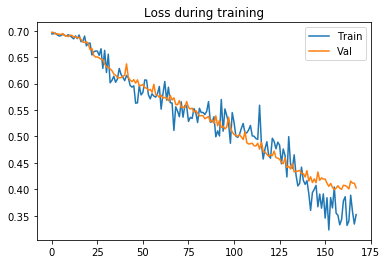

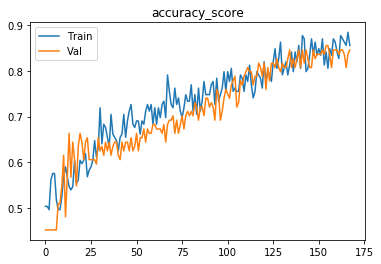

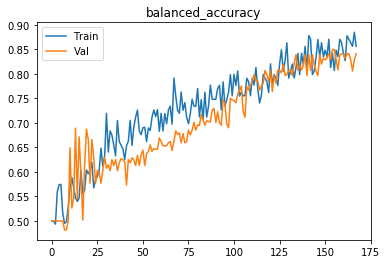

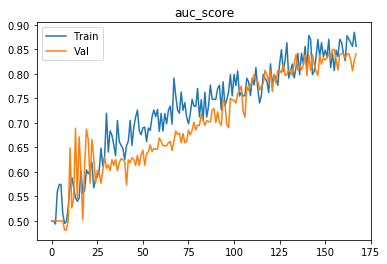

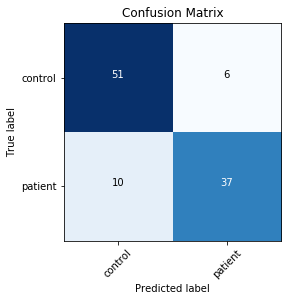

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.69772
[0,    20] loss: 0.69341
[0,    30] loss: 0.69759
Time elapsed: 0h:0m:5s
train accuracy_score: 46.76 %
train balanced_accuracy: 46.80 %
train auc_score: 46.80 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.689971
[1,    10] loss: 0.69596
[1,    20] loss: 0.69228
[1,    30] loss: 0.69576
Time elapsed: 0h:0m:11s
train accuracy_score: 44.60 %
train balanced_accuracy: 44.86 %
train auc_score: 44.86 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.692192
[2,    10] loss: 0.69780
[2,    20] loss: 0.70173
[2,    30] loss: 0.69381
Time elapsed: 0h:0m:18s
train accuracy_score: 43.17 %
train balanced_accuracy: 43.37 %
train auc_score: 43.37 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.689365
[3,    

[28,    10] loss: 0.67192
[28,    20] loss: 0.59185
[28,    30] loss: 0.62696
Time elapsed: 0h:3m:17s
train accuracy_score: 69.06 %
train balanced_accuracy: 69.04 %
train auc_score: 69.04 %
val accuracy_score: 63.46 %
val balanced_accuracy: 60.51 %
val auc_score: 60.51 %
Val loss: 0.601501
[29,    10] loss: 0.54551
[29,    20] loss: 0.67898
[29,    30] loss: 0.56427
Time elapsed: 0h:3m:24s
train accuracy_score: 69.06 %
train balanced_accuracy: 69.10 %
train auc_score: 69.10 %
val accuracy_score: 73.08 %
val balanced_accuracy: 71.52 %
val auc_score: 71.52 %
Val loss: 0.561893
[30,    10] loss: 0.58188
[30,    20] loss: 0.64062
[30,    30] loss: 0.56633
Time elapsed: 0h:3m:31s
train accuracy_score: 69.06 %
train balanced_accuracy: 69.03 %
train auc_score: 69.03 %
val accuracy_score: 73.08 %
val balanced_accuracy: 74.32 %
val auc_score: 74.32 %
Val loss: 0.564930
[31,    10] loss: 0.56113
[31,    20] loss: 0.64863
[31,    30] loss: 0.44137
Time elapsed: 0h:3m:38s
train accuracy_score: 76.

[56,    30] loss: 0.31038
Time elapsed: 0h:6m:30s
train accuracy_score: 89.21 %
train balanced_accuracy: 89.22 %
train auc_score: 89.22 %
val accuracy_score: 82.69 %
val balanced_accuracy: 81.22 %
val auc_score: 81.22 %
Val loss: 0.442662
[57,    10] loss: 0.22284
[57,    20] loss: 0.30248
[57,    30] loss: 0.43457
Time elapsed: 0h:6m:37s
train accuracy_score: 88.49 %
train balanced_accuracy: 88.48 %
train auc_score: 88.48 %
val accuracy_score: 77.88 %
val balanced_accuracy: 77.96 %
val auc_score: 77.96 %
Val loss: 0.364446
[58,    10] loss: 0.30708
[58,    20] loss: 0.36501
[58,    30] loss: 0.31872
Time elapsed: 0h:6m:44s
train accuracy_score: 89.21 %
train balanced_accuracy: 89.21 %
train auc_score: 89.21 %
val accuracy_score: 83.65 %
val balanced_accuracy: 82.29 %
val auc_score: 82.29 %
Val loss: 0.431875
[59,    10] loss: 0.33636
[59,    20] loss: 0.36388
[59,    30] loss: 0.24990
Time elapsed: 0h:6m:51s
train accuracy_score: 89.21 %
train balanced_accuracy: 89.21 %
train auc_scor

val accuracy_score: 83.65 %
val balanced_accuracy: 84.15 %
val auc_score: 84.15 %
Val loss: 0.389050
[85,    10] loss: 0.06730
[85,    20] loss: 0.12364
[85,    30] loss: 0.09367
Time elapsed: 0h:9m:51s
train accuracy_score: 97.12 %
train balanced_accuracy: 97.11 %
train auc_score: 97.11 %
val accuracy_score: 83.65 %
val balanced_accuracy: 83.03 %
val auc_score: 83.03 %
Val loss: 0.389381
[86,    10] loss: 0.07396
[86,    20] loss: 0.04728
[86,    30] loss: 0.02974
Time elapsed: 0h:9m:57s
train accuracy_score: 99.28 %
train balanced_accuracy: 99.28 %
train auc_score: 99.28 %
val accuracy_score: 81.73 %
val balanced_accuracy: 81.09 %
val auc_score: 81.09 %
Val loss: 0.436913
[87,    10] loss: 0.04602
[87,    20] loss: 0.03084
[87,    30] loss: 0.06790
Time elapsed: 0h:10m:4s
train accuracy_score: 98.56 %
train balanced_accuracy: 98.55 %
train auc_score: 98.55 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.35 %
val auc_score: 83.35 %
Val loss: 0.567609
[88,    10] loss: 0.06529


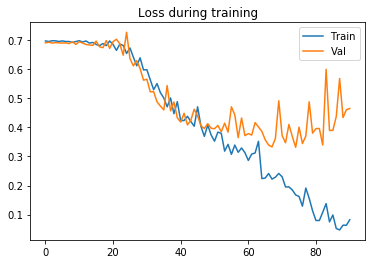

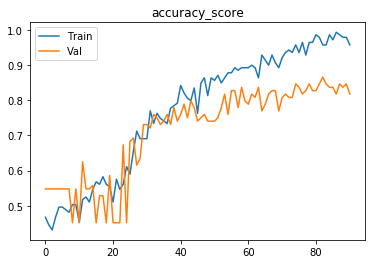

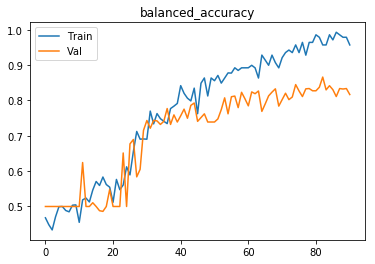

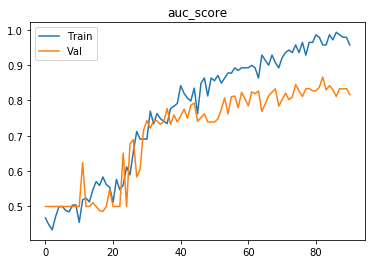

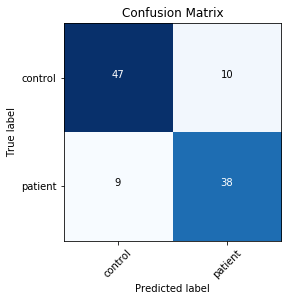

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.69244
[0,    20] loss: 0.69934
[0,    30] loss: 0.69733
Time elapsed: 0h:0m:4s
train accuracy_score: 48.92 %
train balanced_accuracy: 48.85 %
train auc_score: 48.85 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693495
[1,    10] loss: 0.69947
[1,    20] loss: 0.69328
[1,    30] loss: 0.69624
Time elapsed: 0h:0m:11s
train accuracy_score: 41.73 %
train balanced_accuracy: 41.87 %
train auc_score: 41.87 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691415
[2,    10] loss: 0.69884
[2,    20] loss: 0.69365
[2,    30] loss: 0.69383
Time elapsed: 0h:0m:18s
train accuracy_score: 48.20 %
train balanced_accuracy: 48.27 %
train auc_score: 48.27 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.690911
[3,    

[28,    10] loss: 0.69406
[28,    20] loss: 0.67465
[28,    30] loss: 0.67366
Time elapsed: 0h:3m:17s
train accuracy_score: 57.55 %
train balanced_accuracy: 57.77 %
train auc_score: 57.77 %
val accuracy_score: 59.62 %
val balanced_accuracy: 55.32 %
val auc_score: 55.32 %
Val loss: 0.670930
[29,    10] loss: 0.68130
[29,    20] loss: 0.68288
[29,    30] loss: 0.69420
Time elapsed: 0h:3m:24s
train accuracy_score: 54.68 %
train balanced_accuracy: 54.84 %
train auc_score: 54.84 %
val accuracy_score: 58.65 %
val balanced_accuracy: 54.44 %
val auc_score: 54.44 %
Val loss: 0.665520
[30,    10] loss: 0.68466
[30,    20] loss: 0.66355
[30,    30] loss: 0.67805
Time elapsed: 0h:3m:31s
train accuracy_score: 64.03 %
train balanced_accuracy: 64.13 %
train auc_score: 64.13 %
val accuracy_score: 68.27 %
val balanced_accuracy: 69.37 %
val auc_score: 69.37 %
Val loss: 0.667820
[31,    10] loss: 0.64773
[31,    20] loss: 0.67278
[31,    30] loss: 0.68294
Time elapsed: 0h:3m:38s
train accuracy_score: 64.

[56,    30] loss: 0.34210
Time elapsed: 0h:6m:29s
train accuracy_score: 81.29 %
train balanced_accuracy: 81.29 %
train auc_score: 81.29 %
val accuracy_score: 79.81 %
val balanced_accuracy: 77.85 %
val auc_score: 77.85 %
Val loss: 0.449715
[57,    10] loss: 0.40545
[57,    20] loss: 0.35633
[57,    30] loss: 0.36308
Time elapsed: 0h:6m:36s
train accuracy_score: 82.73 %
train balanced_accuracy: 82.76 %
train auc_score: 82.76 %
val accuracy_score: 75.96 %
val balanced_accuracy: 76.02 %
val auc_score: 76.02 %
Val loss: 0.385709
[58,    10] loss: 0.33409
[58,    20] loss: 0.46717
[58,    30] loss: 0.47093
Time elapsed: 0h:6m:43s
train accuracy_score: 85.61 %
train balanced_accuracy: 85.61 %
train auc_score: 85.61 %
val accuracy_score: 77.88 %
val balanced_accuracy: 79.08 %
val auc_score: 79.08 %
Val loss: 0.432705
[59,    10] loss: 0.21527
[59,    20] loss: 0.40594
[59,    30] loss: 0.52949
Time elapsed: 0h:6m:50s
train accuracy_score: 82.01 %
train balanced_accuracy: 82.03 %
train auc_scor

val accuracy_score: 86.54 %
val balanced_accuracy: 86.79 %
val auc_score: 86.79 %
Val loss: 0.268253
[85,    10] loss: 0.16367
[85,    20] loss: 0.12662
[85,    30] loss: 0.14603
Time elapsed: 0h:9m:49s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.95 %
train auc_score: 94.95 %
val accuracy_score: 91.35 %
val balanced_accuracy: 90.61 %
val auc_score: 90.61 %
Val loss: 0.317574
[86,    10] loss: 0.09135
[86,    20] loss: 0.12012
[86,    30] loss: 0.03655
Time elapsed: 0h:9m:56s
train accuracy_score: 97.12 %
train balanced_accuracy: 97.13 %
train auc_score: 97.13 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.68 %
val auc_score: 91.68 %
Val loss: 0.205924
[87,    10] loss: 0.11271
[87,    20] loss: 0.04562
[87,    30] loss: 0.06082
Time elapsed: 0h:10m:2s
train accuracy_score: 97.84 %
train balanced_accuracy: 97.85 %
train auc_score: 97.85 %
val accuracy_score: 91.35 %
val balanced_accuracy: 90.61 %
val auc_score: 90.61 %
Val loss: 0.292527
[88,    10] loss: 0.06468


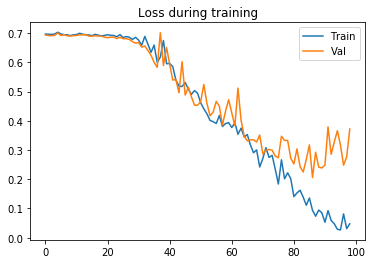

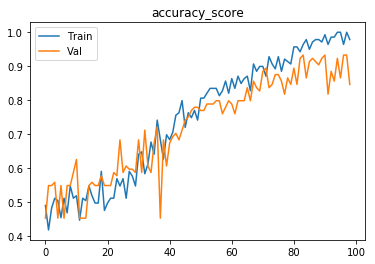

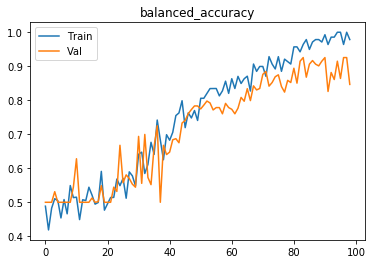

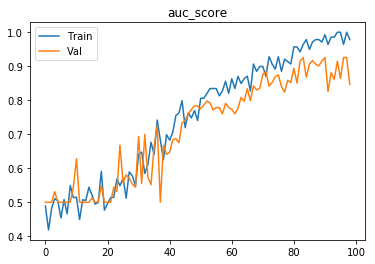

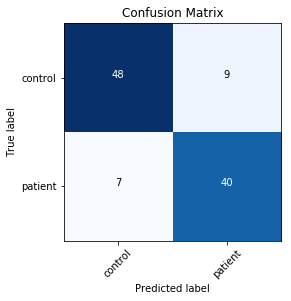

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.69923
[0,    20] loss: 0.68799
[0,    30] loss: 0.72473
Time elapsed: 0h:0m:4s
train accuracy_score: 52.52 %
train balanced_accuracy: 52.49 %
train auc_score: 52.49 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.689684
[1,    10] loss: 0.70298
[1,    20] loss: 0.68841
[1,    30] loss: 0.70027
Time elapsed: 0h:0m:11s
train accuracy_score: 51.08 %
train balanced_accuracy: 51.11 %
train auc_score: 51.11 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.688385
[2,    10] loss: 0.68199
[2,    20] loss: 0.69674
[2,    30] loss: 0.70353
Time elapsed: 0h:0m:18s
train accuracy_score: 51.80 %
train balanced_accuracy: 51.81 %
train auc_score: 51.81 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.699118
[3,   

[28,    10] loss: 0.48511
[28,    20] loss: 0.44133
[28,    30] loss: 0.67771
Time elapsed: 0h:3m:17s
train accuracy_score: 78.42 %
train balanced_accuracy: 78.37 %
train auc_score: 78.37 %
val accuracy_score: 73.08 %
val balanced_accuracy: 73.20 %
val auc_score: 73.20 %
Val loss: 0.492892
[29,    10] loss: 0.45335
[29,    20] loss: 0.78891
[29,    30] loss: 0.47465
Time elapsed: 0h:3m:24s
train accuracy_score: 69.78 %
train balanced_accuracy: 69.77 %
train auc_score: 69.77 %
val accuracy_score: 72.12 %
val balanced_accuracy: 72.32 %
val auc_score: 72.32 %
Val loss: 0.503642
[30,    10] loss: 0.52481
[30,    20] loss: 0.51715
[30,    30] loss: 0.43475
Time elapsed: 0h:3m:31s
train accuracy_score: 80.58 %
train balanced_accuracy: 80.56 %
train auc_score: 80.56 %
val accuracy_score: 73.08 %
val balanced_accuracy: 72.83 %
val auc_score: 72.83 %
Val loss: 0.469452
[31,    10] loss: 0.41360
[31,    20] loss: 0.58773
[31,    30] loss: 0.47891
Time elapsed: 0h:3m:38s
train accuracy_score: 79.

[56,    30] loss: 0.03024
Time elapsed: 0h:6m:29s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
train auc_score: 100.00 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.15 %
val auc_score: 76.15 %
Val loss: 0.617726
[57,    10] loss: 0.04347
[57,    20] loss: 0.06608
[57,    30] loss: 0.03455
Time elapsed: 0h:6m:36s
train accuracy_score: 99.28 %
train balanced_accuracy: 99.28 %
train auc_score: 99.28 %
val accuracy_score: 79.81 %
val balanced_accuracy: 79.15 %
val auc_score: 79.15 %
Val loss: 0.589911
[58,    10] loss: 0.17803
[58,    20] loss: 0.11366
[58,    30] loss: 0.10164
Time elapsed: 0h:6m:43s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.98 %
train auc_score: 94.98 %
val accuracy_score: 79.81 %
val balanced_accuracy: 80.65 %
val auc_score: 80.65 %
Val loss: 0.585426
Early stopping in epoch 59
Total time elapsed: 0h:6m:45s
Writing model to disk...
Best result during training: 0.84. Saving model..
Finished inner fold.


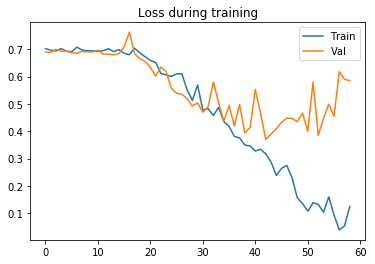

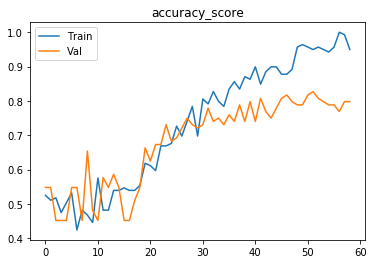

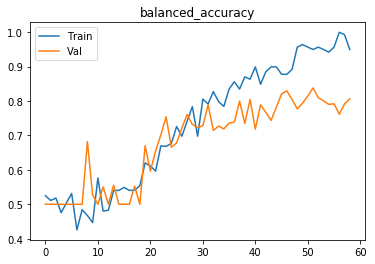

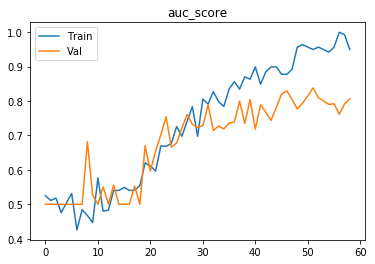

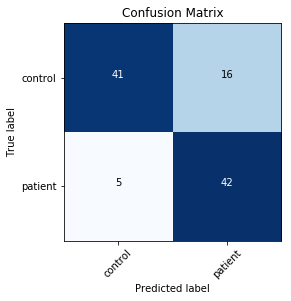

Finished outer fold.
{'final_acc': 0.8465845464725643, 'best_acc': 0.925531914893617, 'final_iter': 99, 'best_iter': 98, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}
###### Starting outer fold 5
# of patients 125, # of healthy controls 126
136
115
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69322
Time elapsed: 0h:0m:2s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.53 %
train auc_score: 50.53 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698072
[1,    10] loss: 0.69252
Time elapsed: 0h:0m:6s
train accuracy_score: 55.15 %
train balanced_accuracy: 49.34 %
train auc_score: 49.34 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.706134
[2,    10] loss: 0.68615
Time elapsed: 0h:0m:10s
train accuracy_score: 55.88 %
train balanced_

val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.699067
[33,    10] loss: 0.68870
Time elapsed: 0h:2m:12s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.35 %
train auc_score: 50.35 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691071
[34,    10] loss: 0.68165
Time elapsed: 0h:2m:16s
train accuracy_score: 58.09 %
train balanced_accuracy: 53.03 %
train auc_score: 53.03 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.690405
[35,    10] loss: 0.67535
Time elapsed: 0h:2m:20s
train accuracy_score: 55.15 %
train balanced_accuracy: 50.22 %
train auc_score: 50.22 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.699601
[36,    10] loss: 0.68589
Time elapsed: 0h:2m:23s
train accuracy_score: 53.68 %
train balanced_accuracy: 49.08 %
train auc_score: 49.08 %
val accuracy_score: 45.22 %
val balanced_acc

[67,    10] loss: 0.65347
Time elapsed: 0h:4m:25s
train accuracy_score: 64.71 %
train balanced_accuracy: 64.21 %
train auc_score: 64.21 %
val accuracy_score: 71.30 %
val balanced_accuracy: 71.58 %
val auc_score: 71.58 %
Val loss: 0.585574
[68,    10] loss: 0.66513
Time elapsed: 0h:4m:29s
train accuracy_score: 61.03 %
train balanced_accuracy: 58.82 %
train auc_score: 58.82 %
val accuracy_score: 76.52 %
val balanced_accuracy: 74.29 %
val auc_score: 74.29 %
Val loss: 0.580257
[69,    10] loss: 0.63494
Time elapsed: 0h:4m:33s
train accuracy_score: 60.29 %
train balanced_accuracy: 57.11 %
train auc_score: 57.11 %
val accuracy_score: 73.04 %
val balanced_accuracy: 74.15 %
val auc_score: 74.15 %
Val loss: 0.580628
[70,    10] loss: 0.64645
Time elapsed: 0h:4m:37s
train accuracy_score: 63.24 %
train balanced_accuracy: 63.25 %
train auc_score: 63.25 %
val accuracy_score: 76.52 %
val balanced_accuracy: 74.29 %
val auc_score: 74.29 %
Val loss: 0.572233
[71,    10] loss: 0.64654
Time elapsed: 0h:4

val accuracy_score: 73.91 %
val balanced_accuracy: 72.80 %
val auc_score: 72.80 %
Val loss: 0.461508
[102,    10] loss: 0.53125
Time elapsed: 0h:6m:44s
train accuracy_score: 74.26 %
train balanced_accuracy: 73.29 %
train auc_score: 73.29 %
val accuracy_score: 79.13 %
val balanced_accuracy: 79.19 %
val auc_score: 79.19 %
Val loss: 0.463486
[103,    10] loss: 0.52695
Time elapsed: 0h:6m:47s
train accuracy_score: 77.21 %
train balanced_accuracy: 76.62 %
train auc_score: 76.62 %
val accuracy_score: 75.65 %
val balanced_accuracy: 74.85 %
val auc_score: 74.85 %
Val loss: 0.448604
[104,    10] loss: 0.53296
Time elapsed: 0h:6m:51s
train accuracy_score: 73.53 %
train balanced_accuracy: 72.46 %
train auc_score: 72.46 %
val accuracy_score: 78.26 %
val balanced_accuracy: 78.96 %
val auc_score: 78.96 %
Val loss: 0.461860
[105,    10] loss: 0.54124
Time elapsed: 0h:6m:56s
train accuracy_score: 75.74 %
train balanced_accuracy: 74.61 %
train auc_score: 74.61 %
val accuracy_score: 76.52 %
val balanced

[136,    10] loss: 0.45173
Time elapsed: 0h:8m:58s
train accuracy_score: 80.15 %
train balanced_accuracy: 80.66 %
train auc_score: 80.66 %
val accuracy_score: 79.13 %
val balanced_accuracy: 77.88 %
val auc_score: 77.88 %
Val loss: 0.398464
[137,    10] loss: 0.43801
Time elapsed: 0h:9m:2s
train accuracy_score: 77.21 %
train balanced_accuracy: 76.10 %
train auc_score: 76.10 %
val accuracy_score: 82.61 %
val balanced_accuracy: 83.27 %
val auc_score: 83.27 %
Val loss: 0.423678
[138,    10] loss: 0.38824
Time elapsed: 0h:9m:6s
train accuracy_score: 83.82 %
train balanced_accuracy: 83.95 %
train auc_score: 83.95 %
val accuracy_score: 80.00 %
val balanced_accuracy: 79.95 %
val auc_score: 79.95 %
Val loss: 0.391964
[139,    10] loss: 0.44257
Time elapsed: 0h:9m:10s
train accuracy_score: 81.62 %
train balanced_accuracy: 80.92 %
train auc_score: 80.92 %
val accuracy_score: 82.61 %
val balanced_accuracy: 83.01 %
val auc_score: 83.01 %
Val loss: 0.405377
[140,    10] loss: 0.42583
Time elapsed: 0

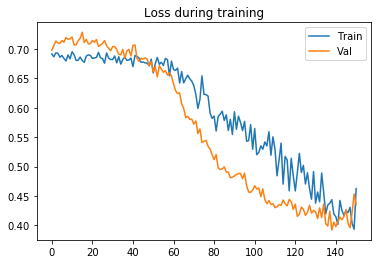

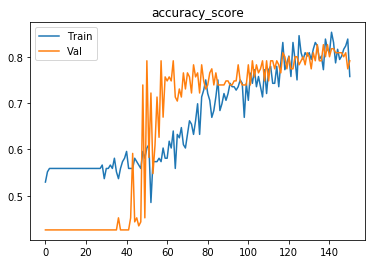

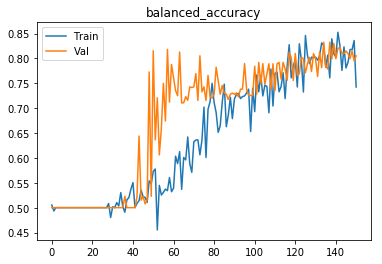

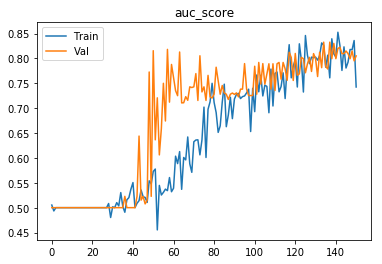

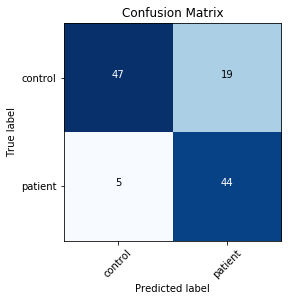

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    10] loss: 0.68877
Time elapsed: 0h:0m:2s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.712423
[1,    10] loss: 0.68687
Time elapsed: 0h:0m:6s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.736180
[2,    10] loss: 0.68624
Time elapsed: 0h:0m:10s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.707959
[3,    10] loss: 0.68581
Time elapsed: 0h:0m:14s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.35 %
train auc_score: 50.35 %
val accuracy_score:

[34,    10] loss: 0.69509
Time elapsed: 0h:2m:16s
train accuracy_score: 57.35 %
train balanced_accuracy: 51.67 %
train auc_score: 51.67 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701817
[35,    10] loss: 0.68959
Time elapsed: 0h:2m:20s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.709759
[36,    10] loss: 0.68896
Time elapsed: 0h:2m:24s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.708917
[37,    10] loss: 0.68556
Time elapsed: 0h:2m:27s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.720076
[38,    10] loss: 0.69156
Time elapsed: 0h:2

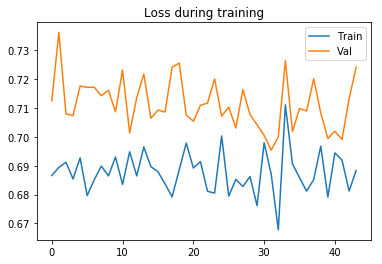

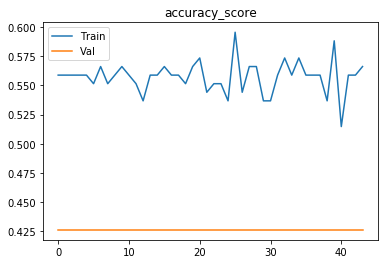

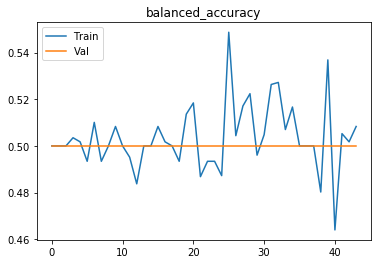

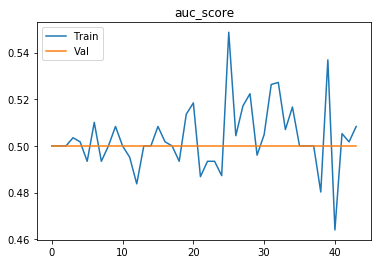

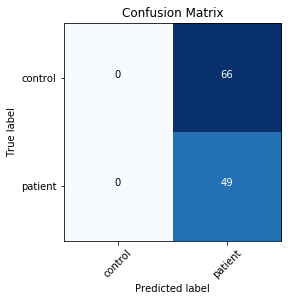

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.69759
[0,    20] loss: 0.68020
Time elapsed: 0h:0m:4s
train accuracy_score: 51.47 %
train balanced_accuracy: 49.74 %
train auc_score: 49.74 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.743851
[1,    10] loss: 0.69717
[1,    20] loss: 0.69909
Time elapsed: 0h:0m:10s
train accuracy_score: 51.47 %
train balanced_accuracy: 46.05 %
train auc_score: 46.05 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701119
[2,    10] loss: 0.69444
[2,    20] loss: 0.69256
Time elapsed: 0h:0m:17s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.53 %
train auc_score: 50.53 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.709662
[3,    10] loss: 0.68657
[3,    20] loss: 0.70542
Time elapsed: 0h:0m:23s
train a

val accuracy_score: 46.09 %
val balanced_accuracy: 53.03 %
val auc_score: 53.03 %
Val loss: 0.689098
[31,    10] loss: 0.68772
[31,    20] loss: 0.70091
Time elapsed: 0h:3m:25s
train accuracy_score: 55.15 %
train balanced_accuracy: 51.27 %
train auc_score: 51.27 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701283
[32,    10] loss: 0.68993
[32,    20] loss: 0.67620
Time elapsed: 0h:3m:31s
train accuracy_score: 57.35 %
train balanced_accuracy: 53.60 %
train auc_score: 53.60 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.723960
[33,    10] loss: 0.71420
[33,    20] loss: 0.67504
Time elapsed: 0h:3m:38s
train accuracy_score: 54.41 %
train balanced_accuracy: 49.39 %
train auc_score: 49.39 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704448
[34,    10] loss: 0.67993
[34,    20] loss: 0.69781
Time elapsed: 0h:3m:44s
train accuracy_score: 50.74 

val accuracy_score: 76.52 %
val balanced_accuracy: 79.55 %
val auc_score: 79.55 %
Val loss: 0.490709
[62,    10] loss: 0.41963
[62,    20] loss: 0.35569
Time elapsed: 0h:6m:45s
train accuracy_score: 81.62 %
train balanced_accuracy: 81.27 %
train auc_score: 81.27 %
val accuracy_score: 80.87 %
val balanced_accuracy: 80.97 %
val auc_score: 80.97 %
Val loss: 0.366321
[63,    10] loss: 0.35780
[63,    20] loss: 0.35797
Time elapsed: 0h:6m:51s
train accuracy_score: 86.03 %
train balanced_accuracy: 86.27 %
train auc_score: 86.27 %
val accuracy_score: 80.87 %
val balanced_accuracy: 82.54 %
val auc_score: 82.54 %
Val loss: 0.432709
[64,    10] loss: 0.31361
[64,    20] loss: 0.31473
Time elapsed: 0h:6m:58s
train accuracy_score: 86.76 %
train balanced_accuracy: 86.93 %
train auc_score: 86.93 %
val accuracy_score: 80.87 %
val balanced_accuracy: 79.39 %
val auc_score: 79.39 %
Val loss: 0.360827
[65,    10] loss: 0.33509
[65,    20] loss: 0.25216
Time elapsed: 0h:7m:4s
train accuracy_score: 87.50 %

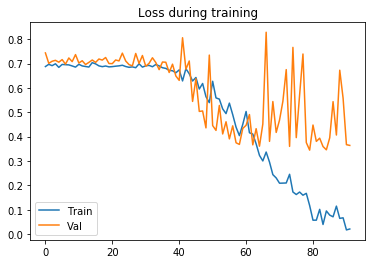

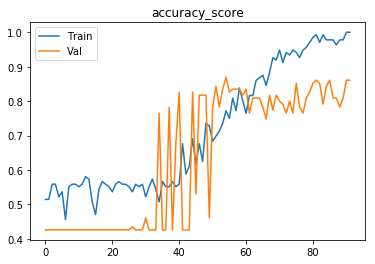

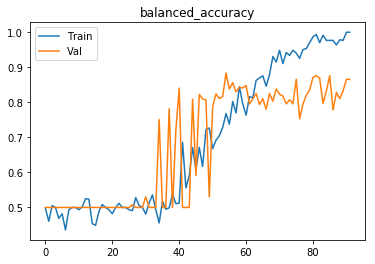

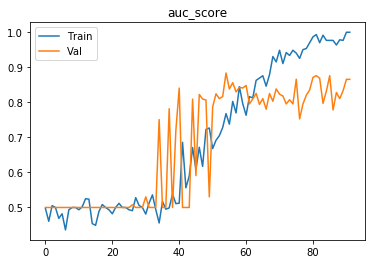

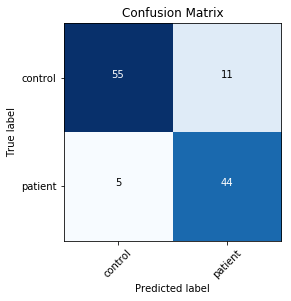

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.70350
[0,    20] loss: 0.68952
[0,    30] loss: 0.71704
Time elapsed: 0h:0m:4s
train accuracy_score: 50.74 %
train balanced_accuracy: 49.25 %
train auc_score: 49.25 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.699984
[1,    10] loss: 0.68026
[1,    20] loss: 0.72548
[1,    30] loss: 0.70248
Time elapsed: 0h:0m:11s
train accuracy_score: 49.26 %
train balanced_accuracy: 46.01 %
train auc_score: 46.01 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705063
[2,    10] loss: 0.70659
[2,    20] loss: 0.69308
[2,    30] loss: 0.70210
Time elapsed: 0h:0m:18s
train accuracy_score: 54.41 %
train balanced_accuracy: 50.61 %
train auc_score: 50.61 %
val accuracy_score: 57.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.690218
[3,   

[28,    10] loss: 0.70053
[28,    20] loss: 0.69072
[28,    30] loss: 0.68790
Time elapsed: 0h:3m:20s
train accuracy_score: 51.47 %
train balanced_accuracy: 46.23 %
train auc_score: 46.23 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705852
[29,    10] loss: 0.67016
[29,    20] loss: 0.73307
[29,    30] loss: 0.68225
Time elapsed: 0h:3m:27s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.699191
[30,    10] loss: 0.69908
[30,    20] loss: 0.68502
[30,    30] loss: 0.67074
Time elapsed: 0h:3m:34s
train accuracy_score: 54.41 %
train balanced_accuracy: 48.68 %
train auc_score: 48.68 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.720476
[31,    10] loss: 0.69287
[31,    20] loss: 0.68774
[31,    30] loss: 0.69422
Time elapsed: 0h:3m:41s
train accuracy_score: 55.

[56,    30] loss: 0.56798
Time elapsed: 0h:6m:35s
train accuracy_score: 77.21 %
train balanced_accuracy: 76.62 %
train auc_score: 76.62 %
val accuracy_score: 74.78 %
val balanced_accuracy: 76.98 %
val auc_score: 76.98 %
Val loss: 0.481209
[57,    10] loss: 0.49509
[57,    20] loss: 0.52474
[57,    30] loss: 0.40541
Time elapsed: 0h:6m:42s
train accuracy_score: 73.53 %
train balanced_accuracy: 72.98 %
train auc_score: 72.98 %
val accuracy_score: 77.39 %
val balanced_accuracy: 77.67 %
val auc_score: 77.67 %
Val loss: 0.445093
[58,    10] loss: 0.36403
[58,    20] loss: 0.48164
[58,    30] loss: 0.41995
Time elapsed: 0h:6m:49s
train accuracy_score: 83.09 %
train balanced_accuracy: 82.94 %
train auc_score: 82.94 %
val accuracy_score: 73.04 %
val balanced_accuracy: 75.73 %
val auc_score: 75.73 %
Val loss: 0.503297
[59,    10] loss: 0.43515
[59,    20] loss: 0.31272
[59,    30] loss: 0.47626
Time elapsed: 0h:6m:56s
train accuracy_score: 81.62 %
train balanced_accuracy: 81.62 %
train auc_scor

val accuracy_score: 78.26 %
val balanced_accuracy: 78.17 %
val auc_score: 78.17 %
Val loss: 0.564655
[85,    10] loss: 0.31327
[85,    20] loss: 0.25693
[85,    30] loss: 0.43861
Time elapsed: 0h:9m:57s
train accuracy_score: 83.82 %
train balanced_accuracy: 83.25 %
train auc_score: 83.25 %
val accuracy_score: 46.09 %
val balanced_accuracy: 53.03 %
val auc_score: 53.03 %
Val loss: 1.436139
[86,    10] loss: 0.21477
[86,    20] loss: 0.17018
[86,    30] loss: 0.07295
Time elapsed: 0h:10m:4s
train accuracy_score: 94.12 %
train balanced_accuracy: 93.86 %
train auc_score: 93.86 %
val accuracy_score: 73.04 %
val balanced_accuracy: 74.94 %
val auc_score: 74.94 %
Val loss: 0.611887
[87,    10] loss: 0.04435
[87,    20] loss: 0.05035
[87,    30] loss: 0.04449
Time elapsed: 0h:10m:11s
train accuracy_score: 97.06 %
train balanced_accuracy: 96.84 %
train auc_score: 96.84 %
val accuracy_score: 76.52 %
val balanced_accuracy: 77.71 %
val auc_score: 77.71 %
Val loss: 0.544601
[88,    10] loss: 0.17553

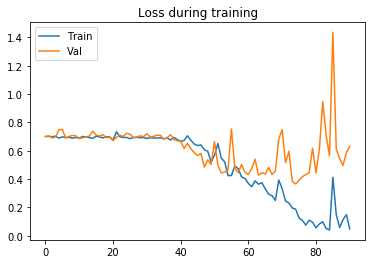

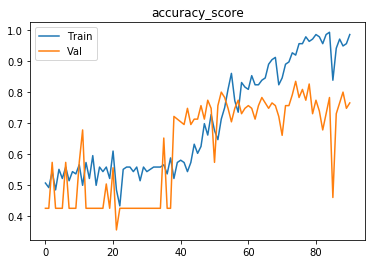

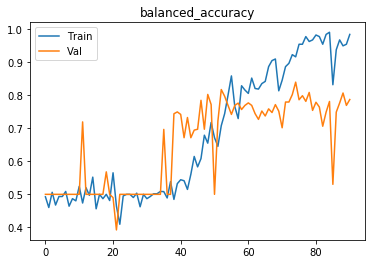

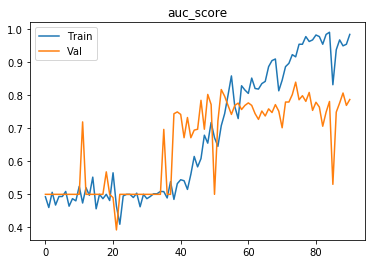

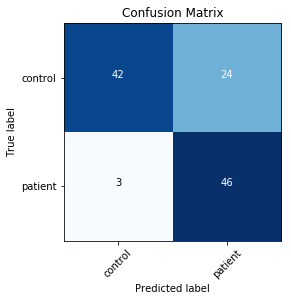

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.69213
Time elapsed: 0h:0m:4s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.702874
[1,    10] loss: 0.68774
Time elapsed: 0h:0m:10s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.714834
[2,    10] loss: 0.68671
Time elapsed: 0h:0m:16s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.726829
[3,    10] loss: 0.68521
Time elapsed: 0h:0m:22s
train accuracy_score: 55.15 %
train balanced_accuracy: 49.87 %
train auc_score: 49.87 %
val accuracy_score

[34,    10] loss: 0.68891
Time elapsed: 0h:3m:36s
train accuracy_score: 55.15 %
train balanced_accuracy: 49.34 %
train auc_score: 49.34 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717976
[35,    10] loss: 0.69567
Time elapsed: 0h:3m:42s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.708380
[36,    10] loss: 0.69238
Time elapsed: 0h:3m:48s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.706173
[37,    10] loss: 0.68667
Time elapsed: 0h:3m:54s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.18 %
train auc_score: 50.18 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697577
[38,    10] loss: 0.68515
Time elapsed: 0h:4

val accuracy_score: 70.43 %
val balanced_accuracy: 74.24 %
val auc_score: 74.24 %
Val loss: 0.632657
[69,    10] loss: 0.48628
Time elapsed: 0h:7m:15s
train accuracy_score: 77.94 %
train balanced_accuracy: 77.28 %
train auc_score: 77.28 %
val accuracy_score: 72.17 %
val balanced_accuracy: 74.18 %
val auc_score: 74.18 %
Val loss: 0.554642
[70,    10] loss: 0.48935
Time elapsed: 0h:7m:22s
train accuracy_score: 79.41 %
train balanced_accuracy: 78.07 %
train auc_score: 78.07 %
val accuracy_score: 68.70 %
val balanced_accuracy: 67.47 %
val auc_score: 67.47 %
Val loss: 0.520311
[71,    10] loss: 0.54371
Time elapsed: 0h:7m:28s
train accuracy_score: 69.12 %
train balanced_accuracy: 68.51 %
train auc_score: 68.51 %
val accuracy_score: 74.78 %
val balanced_accuracy: 71.72 %
val auc_score: 71.72 %
Val loss: 0.528811
[72,    10] loss: 0.51679
Time elapsed: 0h:7m:34s
train accuracy_score: 72.06 %
train balanced_accuracy: 71.49 %
train auc_score: 71.49 %
val accuracy_score: 73.91 %
val balanced_acc

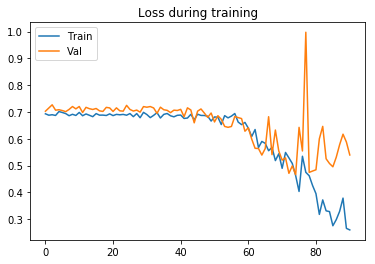

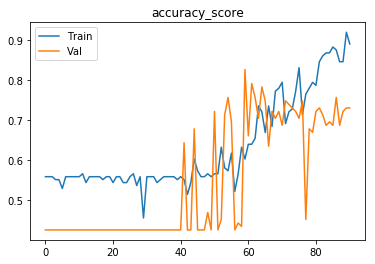

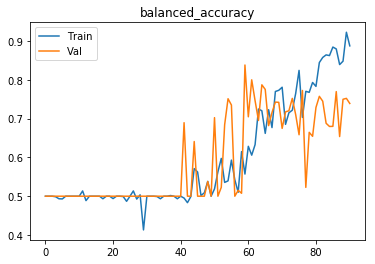

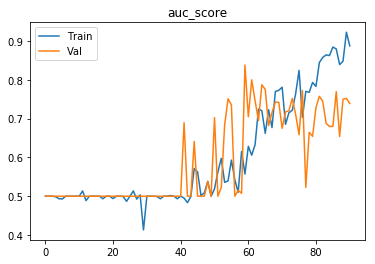

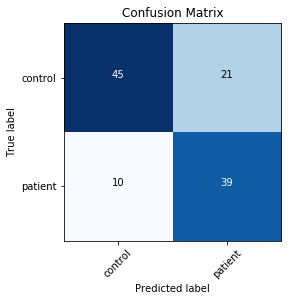

Finished outer fold.
{'final_acc': 0.8656462585034014, 'best_acc': 0.8837353123067409, 'final_iter': 92, 'best_iter': 55, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 2}
###### Starting outer fold 6
# of patients 112, # of healthy controls 132
141
103
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    10] loss: 0.69389
[0,    20] loss: 0.69345
Time elapsed: 0h:0m:2s
train accuracy_score: 51.06 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.710883
[1,    10] loss: 0.68790
[1,    20] loss: 0.71016
Time elapsed: 0h:0m:6s
train accuracy_score: 52.48 %
train balanced_accuracy: 51.63 %
train auc_score: 51.63 %
val accuracy_score: 65.05 %
val balanced_accuracy: 56.83 %
val auc_score: 56.83 %
Val loss: 0.691023
[2,    10] loss: 0.69779
[2,    20] loss: 

val accuracy_score: 70.87 %
val balanced_accuracy: 73.45 %
val auc_score: 73.45 %
Val loss: 0.598150
[30,    10] loss: 0.60775
[30,    20] loss: 0.53843
Time elapsed: 0h:2m:5s
train accuracy_score: 63.83 %
train balanced_accuracy: 63.71 %
train auc_score: 63.71 %
val accuracy_score: 74.76 %
val balanced_accuracy: 68.87 %
val auc_score: 68.87 %
Val loss: 0.530408
[31,    10] loss: 0.54660
[31,    20] loss: 0.50917
Time elapsed: 0h:2m:9s
train accuracy_score: 71.63 %
train balanced_accuracy: 71.68 %
train auc_score: 71.68 %
val accuracy_score: 80.58 %
val balanced_accuracy: 78.65 %
val auc_score: 78.65 %
Val loss: 0.525734
[32,    10] loss: 0.55632
[32,    20] loss: 0.53257
Time elapsed: 0h:2m:13s
train accuracy_score: 71.63 %
train balanced_accuracy: 71.50 %
train auc_score: 71.50 %
val accuracy_score: 48.54 %
val balanced_accuracy: 56.11 %
val auc_score: 56.11 %
Val loss: 0.708240
[33,    10] loss: 0.46372
[33,    20] loss: 0.56222
Time elapsed: 0h:2m:17s
train accuracy_score: 76.60 %


val accuracy_score: 77.67 %
val balanced_accuracy: 75.36 %
val auc_score: 75.36 %
Val loss: 0.433741
[61,    10] loss: 0.34466
[61,    20] loss: 0.28709
Time elapsed: 0h:4m:14s
train accuracy_score: 90.78 %
train balanced_accuracy: 90.85 %
train auc_score: 90.85 %
val accuracy_score: 76.70 %
val balanced_accuracy: 74.11 %
val auc_score: 74.11 %
Val loss: 0.430061
[62,    10] loss: 0.29166
[62,    20] loss: 0.27938
Time elapsed: 0h:4m:18s
train accuracy_score: 90.07 %
train balanced_accuracy: 90.13 %
train auc_score: 90.13 %
val accuracy_score: 79.61 %
val balanced_accuracy: 78.77 %
val auc_score: 78.77 %
Val loss: 0.440158
[63,    10] loss: 0.33604
[63,    20] loss: 0.25262
Time elapsed: 0h:4m:22s
train accuracy_score: 89.36 %
train balanced_accuracy: 89.49 %
train auc_score: 89.49 %
val accuracy_score: 76.70 %
val balanced_accuracy: 74.56 %
val auc_score: 74.56 %
Val loss: 0.432495
[64,    10] loss: 0.26183
[64,    20] loss: 0.29622
Time elapsed: 0h:4m:26s
train accuracy_score: 88.65 

val accuracy_score: 75.73 %
val balanced_accuracy: 74.68 %
val auc_score: 74.68 %
Val loss: 0.437670
[92,    10] loss: 0.20617
[92,    20] loss: 0.26462
Time elapsed: 0h:6m:22s
train accuracy_score: 93.62 %
train balanced_accuracy: 93.69 %
train auc_score: 93.69 %
val accuracy_score: 78.64 %
val balanced_accuracy: 77.06 %
val auc_score: 77.06 %
Val loss: 0.412779
[93,    10] loss: 0.29296
[93,    20] loss: 0.18506
Time elapsed: 0h:6m:26s
train accuracy_score: 90.78 %
train balanced_accuracy: 90.91 %
train auc_score: 90.91 %
val accuracy_score: 73.79 %
val balanced_accuracy: 74.92 %
val auc_score: 74.92 %
Val loss: 0.471328
[94,    10] loss: 0.19315
[94,    20] loss: 0.19379
Time elapsed: 0h:6m:31s
train accuracy_score: 94.33 %
train balanced_accuracy: 94.38 %
train auc_score: 94.38 %
val accuracy_score: 76.70 %
val balanced_accuracy: 75.48 %
val auc_score: 75.48 %
Val loss: 0.420202
[95,    10] loss: 0.20333
[95,    20] loss: 0.18972
Time elapsed: 0h:6m:35s
train accuracy_score: 92.91 

val accuracy_score: 81.55 %
val balanced_accuracy: 80.81 %
val auc_score: 80.81 %
Val loss: 0.427523
[123,    10] loss: 0.09602
[123,    20] loss: 0.33164
Time elapsed: 0h:8m:31s
train accuracy_score: 92.91 %
train balanced_accuracy: 92.93 %
train auc_score: 92.93 %
val accuracy_score: 76.70 %
val balanced_accuracy: 79.58 %
val auc_score: 79.58 %
Val loss: 0.620368
[124,    10] loss: 0.23135
[124,    20] loss: 0.15233
Time elapsed: 0h:8m:35s
train accuracy_score: 92.20 %
train balanced_accuracy: 92.18 %
train auc_score: 92.18 %
val accuracy_score: 79.61 %
val balanced_accuracy: 79.23 %
val auc_score: 79.23 %
Val loss: 0.393847
[125,    10] loss: 0.21480
[125,    20] loss: 0.09624
Time elapsed: 0h:8m:39s
train accuracy_score: 95.74 %
train balanced_accuracy: 95.77 %
train auc_score: 95.77 %
val accuracy_score: 74.76 %
val balanced_accuracy: 76.63 %
val auc_score: 76.63 %
Val loss: 0.445705
[126,    10] loss: 0.12389
[126,    20] loss: 0.08107
Time elapsed: 0h:8m:43s
train accuracy_score

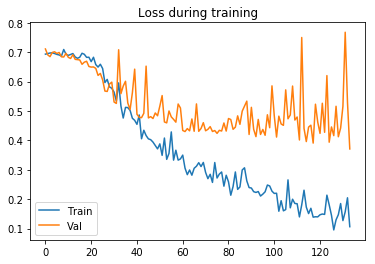

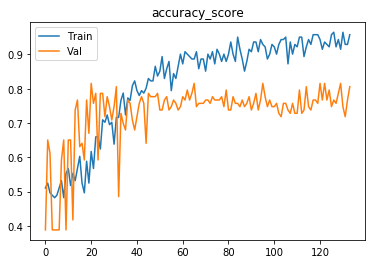

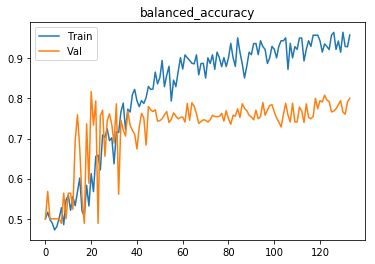

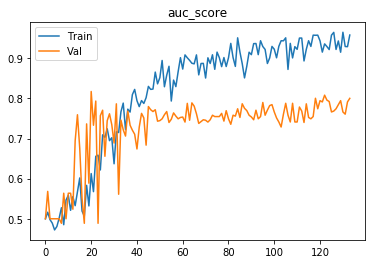

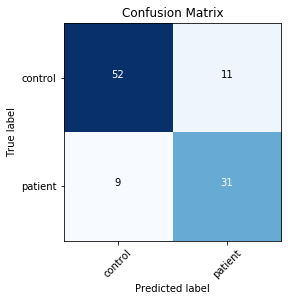

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69589
[0,    20] loss: 0.68191
[0,    30] loss: 0.70425
Time elapsed: 0h:0m:2s
train accuracy_score: 48.94 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.681725
[1,    10] loss: 0.68797
[1,    20] loss: 0.68864
[1,    30] loss: 0.71542
Time elapsed: 0h:0m:7s
train accuracy_score: 48.94 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.685019
[2,    10] loss: 0.69333
[2,    20] loss: 0.69534
[2,    30] loss: 0.69667
Time elapsed: 0h:0m:12s
train accuracy_score: 46.10 %
train balanced_accuracy: 46.20 %
train auc_score: 46.20 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697146
[3,    1

[28,    10] loss: 0.68691
[28,    20] loss: 0.67745
[28,    30] loss: 0.73890
Time elapsed: 0h:2m:9s
train accuracy_score: 51.77 %
train balanced_accuracy: 52.39 %
train auc_score: 52.39 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.672661
[29,    10] loss: 0.69850
[29,    20] loss: 0.69486
[29,    30] loss: 0.71124
Time elapsed: 0h:2m:14s
train accuracy_score: 50.35 %
train balanced_accuracy: 49.88 %
train auc_score: 49.88 %
val accuracy_score: 74.76 %
val balanced_accuracy: 71.15 %
val auc_score: 71.15 %
Val loss: 0.688498
[30,    10] loss: 0.69191
[30,    20] loss: 0.68496
[30,    30] loss: 0.69951
Time elapsed: 0h:2m:18s
train accuracy_score: 49.65 %
train balanced_accuracy: 49.12 %
train auc_score: 49.12 %
val accuracy_score: 66.02 %
val balanced_accuracy: 57.62 %
val auc_score: 57.62 %
Val loss: 0.686103
[31,    10] loss: 0.69153
[31,    20] loss: 0.69085
[31,    30] loss: 0.68900
Time elapsed: 0h:2m:22s
train accuracy_score: 49.6

[56,    30] loss: 0.66618
Time elapsed: 0h:4m:15s
train accuracy_score: 54.61 %
train balanced_accuracy: 54.23 %
train auc_score: 54.23 %
val accuracy_score: 73.79 %
val balanced_accuracy: 74.92 %
val auc_score: 74.92 %
Val loss: 0.655711
[57,    10] loss: 0.64030
[57,    20] loss: 0.62124
[57,    30] loss: 0.63730
Time elapsed: 0h:4m:20s
train accuracy_score: 71.63 %
train balanced_accuracy: 71.92 %
train auc_score: 71.92 %
val accuracy_score: 72.82 %
val balanced_accuracy: 67.74 %
val auc_score: 67.74 %
Val loss: 0.625386
[58,    10] loss: 0.68879
[58,    20] loss: 0.66159
[58,    30] loss: 0.67267
Time elapsed: 0h:4m:24s
train accuracy_score: 61.70 %
train balanced_accuracy: 61.65 %
train auc_score: 61.65 %
val accuracy_score: 74.76 %
val balanced_accuracy: 76.17 %
val auc_score: 76.17 %
Val loss: 0.647487
[59,    10] loss: 0.66095
[59,    20] loss: 0.66492
[59,    30] loss: 0.64347
Time elapsed: 0h:4m:29s
train accuracy_score: 62.41 %
train balanced_accuracy: 62.56 %
train auc_scor

val accuracy_score: 74.76 %
val balanced_accuracy: 75.26 %
val auc_score: 75.26 %
Val loss: 0.464265
[85,    10] loss: 0.45014
[85,    20] loss: 0.41814
[85,    30] loss: 0.46754
Time elapsed: 0h:6m:25s
train accuracy_score: 78.01 %
train balanced_accuracy: 77.99 %
train auc_score: 77.99 %
val accuracy_score: 70.87 %
val balanced_accuracy: 72.08 %
val auc_score: 72.08 %
Val loss: 0.480584
[86,    10] loss: 0.48070
[86,    20] loss: 0.44270
[86,    30] loss: 0.46767
Time elapsed: 0h:6m:30s
train accuracy_score: 80.14 %
train balanced_accuracy: 80.16 %
train auc_score: 80.16 %
val accuracy_score: 70.87 %
val balanced_accuracy: 72.08 %
val auc_score: 72.08 %
Val loss: 0.484897
[87,    10] loss: 0.50859
[87,    20] loss: 0.42697
[87,    30] loss: 0.44284
Time elapsed: 0h:6m:34s
train accuracy_score: 76.60 %
train balanced_accuracy: 76.69 %
train auc_score: 76.69 %
val accuracy_score: 70.87 %
val balanced_accuracy: 75.28 %
val auc_score: 75.28 %
Val loss: 0.577736
[88,    10] loss: 0.40325


[113,    10] loss: 0.33627
[113,    20] loss: 0.43059
[113,    30] loss: 0.32849
Time elapsed: 0h:8m:31s
train accuracy_score: 83.69 %
train balanced_accuracy: 83.76 %
train auc_score: 83.76 %
val accuracy_score: 69.90 %
val balanced_accuracy: 73.57 %
val auc_score: 73.57 %
Val loss: 0.517938
[114,    10] loss: 0.39441
[114,    20] loss: 0.33642
[114,    30] loss: 0.44802
Time elapsed: 0h:8m:36s
train accuracy_score: 83.69 %
train balanced_accuracy: 83.79 %
train auc_score: 83.79 %
val accuracy_score: 73.79 %
val balanced_accuracy: 76.29 %
val auc_score: 76.29 %
Val loss: 0.459023
[115,    10] loss: 0.38199
[115,    20] loss: 0.24160
[115,    30] loss: 0.43489
Time elapsed: 0h:8m:40s
train accuracy_score: 84.40 %
train balanced_accuracy: 84.39 %
train auc_score: 84.39 %
val accuracy_score: 70.87 %
val balanced_accuracy: 73.91 %
val auc_score: 73.91 %
Val loss: 0.485663
[116,    10] loss: 0.47185
[116,    20] loss: 0.33309
[116,    30] loss: 0.31084
Time elapsed: 0h:8m:45s
train accurac

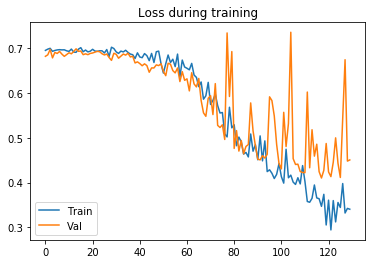

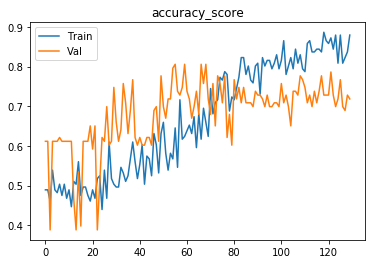

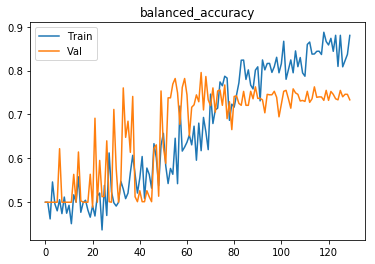

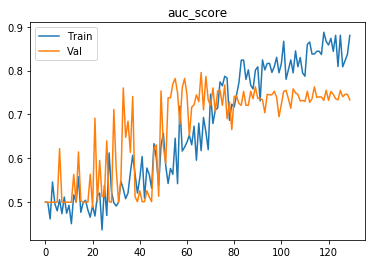

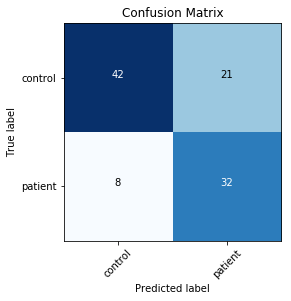

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.70873
[0,    20] loss: 0.69530
[0,    30] loss: 0.69583
Time elapsed: 0h:0m:5s
train accuracy_score: 46.10 %
train balanced_accuracy: 46.68 %
train auc_score: 46.68 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.685199
[1,    10] loss: 0.70009
[1,    20] loss: 0.69288
[1,    30] loss: 0.69861
Time elapsed: 0h:0m:12s
train accuracy_score: 44.68 %
train balanced_accuracy: 45.50 %
train auc_score: 45.50 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.687456
[2,    10] loss: 0.69350
[2,    20] loss: 0.70222
[2,    30] loss: 0.69222
Time elapsed: 0h:0m:18s
train accuracy_score: 48.23 %
train balanced_accuracy: 49.28 %
train auc_score: 49.28 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.686746
[3,    

[28,    10] loss: 0.62108
[28,    20] loss: 0.67335
[28,    30] loss: 0.62042
Time elapsed: 0h:3m:18s
train accuracy_score: 68.09 %
train balanced_accuracy: 68.21 %
train auc_score: 68.21 %
val accuracy_score: 72.82 %
val balanced_accuracy: 74.13 %
val auc_score: 74.13 %
Val loss: 0.608517
[29,    10] loss: 0.63653
[29,    20] loss: 0.59309
[29,    30] loss: 0.48148
Time elapsed: 0h:3m:25s
train accuracy_score: 72.34 %
train balanced_accuracy: 72.19 %
train auc_score: 72.19 %
val accuracy_score: 64.08 %
val balanced_accuracy: 55.12 %
val auc_score: 55.12 %
Val loss: 0.561485
[30,    10] loss: 0.51973
[30,    20] loss: 0.65024
[30,    30] loss: 0.59066
Time elapsed: 0h:3m:32s
train accuracy_score: 70.92 %
train balanced_accuracy: 71.04 %
train auc_score: 71.04 %
val accuracy_score: 75.73 %
val balanced_accuracy: 76.05 %
val auc_score: 76.05 %
Val loss: 0.546570
[31,    10] loss: 0.63440
[31,    20] loss: 0.55664
[31,    30] loss: 0.66000
Time elapsed: 0h:3m:39s
train accuracy_score: 68.

[56,    30] loss: 0.32933
Time elapsed: 0h:6m:32s
train accuracy_score: 89.36 %
train balanced_accuracy: 89.37 %
train auc_score: 89.37 %
val accuracy_score: 72.82 %
val balanced_accuracy: 75.95 %
val auc_score: 75.95 %
Val loss: 0.539375
[57,    10] loss: 0.32697
[57,    20] loss: 0.18302
[57,    30] loss: 0.33796
Time elapsed: 0h:6m:39s
train accuracy_score: 88.65 %
train balanced_accuracy: 88.71 %
train auc_score: 88.71 %
val accuracy_score: 69.90 %
val balanced_accuracy: 74.48 %
val auc_score: 74.48 %
Val loss: 0.643805
[58,    10] loss: 0.27589
[58,    20] loss: 0.26105
[58,    30] loss: 0.26134
Time elapsed: 0h:6m:46s
train accuracy_score: 87.23 %
train balanced_accuracy: 87.32 %
train auc_score: 87.32 %
val accuracy_score: 69.90 %
val balanced_accuracy: 74.03 %
val auc_score: 74.03 %
Val loss: 0.604376
[59,    10] loss: 0.36329
[59,    20] loss: 0.34821
[59,    30] loss: 0.23468
Time elapsed: 0h:6m:53s
train accuracy_score: 85.11 %
train balanced_accuracy: 85.08 %
train auc_scor

val accuracy_score: 82.52 %
val balanced_accuracy: 81.61 %
val auc_score: 81.61 %
Val loss: 0.318713
[85,    10] loss: 0.09074
[85,    20] loss: 0.07332
[85,    30] loss: 0.10191
Time elapsed: 0h:9m:54s
train accuracy_score: 97.16 %
train balanced_accuracy: 97.13 %
train auc_score: 97.13 %
val accuracy_score: 83.50 %
val balanced_accuracy: 80.58 %
val auc_score: 80.58 %
Val loss: 0.392885
[86,    10] loss: 0.23164
[86,    20] loss: 0.15576
[86,    30] loss: 0.23589
Time elapsed: 0h:10m:1s
train accuracy_score: 90.78 %
train balanced_accuracy: 90.76 %
train auc_score: 90.76 %
val accuracy_score: 85.44 %
val balanced_accuracy: 83.08 %
val auc_score: 83.08 %
Val loss: 0.328806
[87,    10] loss: 0.15380
[87,    20] loss: 0.06476
[87,    30] loss: 0.13899
Time elapsed: 0h:10m:8s
train accuracy_score: 96.45 %
train balanced_accuracy: 96.53 %
train auc_score: 96.53 %
val accuracy_score: 83.50 %
val balanced_accuracy: 84.23 %
val auc_score: 84.23 %
Val loss: 0.343514
[88,    10] loss: 0.13577


val accuracy_score: 84.47 %
val balanced_accuracy: 85.48 %
val auc_score: 85.48 %
Val loss: 0.322579
Early stopping in epoch 113
Total time elapsed: 0h:13m:3s
Writing model to disk...
Best result during training: 0.89. Saving model..
Finished inner fold.


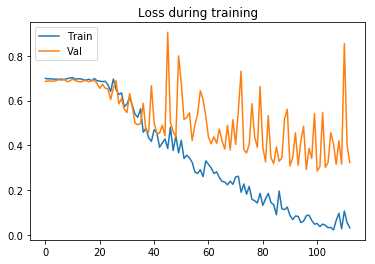

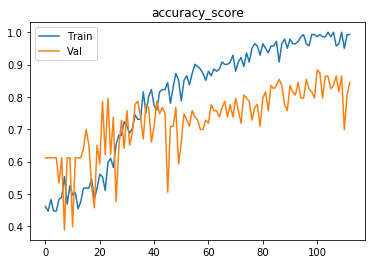

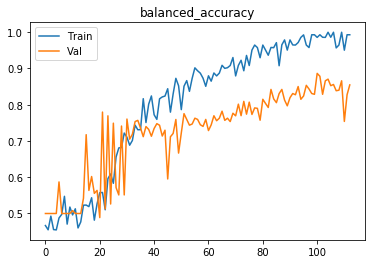

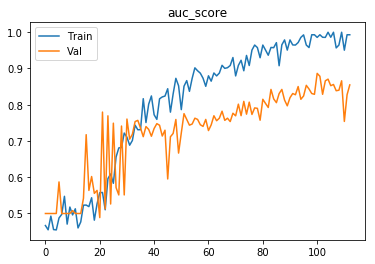

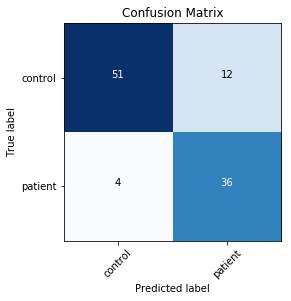

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.69792
[0,    20] loss: 0.69953
Time elapsed: 0h:0m:4s
train accuracy_score: 46.81 %
train balanced_accuracy: 46.92 %
train auc_score: 46.92 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697482
[1,    10] loss: 0.69873
[1,    20] loss: 0.69044
Time elapsed: 0h:0m:10s
train accuracy_score: 45.39 %
train balanced_accuracy: 44.81 %
train auc_score: 44.81 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698882
[2,    10] loss: 0.68823
[2,    20] loss: 0.69328
Time elapsed: 0h:0m:17s
train accuracy_score: 52.48 %
train balanced_accuracy: 51.81 %
train auc_score: 51.81 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.672864
[3,    10] loss: 0.70332
[3,    20] loss: 0.71207
Time elapsed: 0h:0m:23s
train a

val accuracy_score: 82.52 %
val balanced_accuracy: 81.61 %
val auc_score: 81.61 %
Val loss: 0.490373
[31,    10] loss: 0.55251
[31,    20] loss: 0.58411
Time elapsed: 0h:3m:22s
train accuracy_score: 68.09 %
train balanced_accuracy: 68.27 %
train auc_score: 68.27 %
val accuracy_score: 79.61 %
val balanced_accuracy: 76.49 %
val auc_score: 76.49 %
Val loss: 0.498173
[32,    10] loss: 0.49997
[32,    20] loss: 0.56483
Time elapsed: 0h:3m:29s
train accuracy_score: 75.89 %
train balanced_accuracy: 75.88 %
train auc_score: 75.88 %
val accuracy_score: 67.96 %
val balanced_accuracy: 71.98 %
val auc_score: 71.98 %
Val loss: 0.579999
[33,    10] loss: 0.53110
[33,    20] loss: 0.46606
Time elapsed: 0h:3m:35s
train accuracy_score: 78.72 %
train balanced_accuracy: 78.68 %
train auc_score: 78.68 %
val accuracy_score: 59.22 %
val balanced_accuracy: 65.30 %
val auc_score: 65.30 %
Val loss: 0.650992
[34,    10] loss: 0.55830
[34,    20] loss: 0.52182
Time elapsed: 0h:3m:42s
train accuracy_score: 73.76 

val accuracy_score: 81.55 %
val balanced_accuracy: 82.18 %
val auc_score: 82.18 %
Val loss: 0.518894
[62,    10] loss: 0.02697
[62,    20] loss: 0.02652
Time elapsed: 0h:6m:40s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
train auc_score: 100.00 %
val accuracy_score: 79.61 %
val balanced_accuracy: 78.77 %
val auc_score: 78.77 %
Val loss: 0.530342
[63,    10] loss: 0.05303
[63,    20] loss: 0.04966
Time elapsed: 0h:6m:46s
train accuracy_score: 98.58 %
train balanced_accuracy: 98.61 %
train auc_score: 98.61 %
val accuracy_score: 81.55 %
val balanced_accuracy: 82.64 %
val auc_score: 82.64 %
Val loss: 0.625909
[64,    10] loss: 0.03728
[64,    20] loss: 0.04855
Time elapsed: 0h:6m:52s
train accuracy_score: 97.16 %
train balanced_accuracy: 97.16 %
train auc_score: 97.16 %
val accuracy_score: 77.67 %
val balanced_accuracy: 76.27 %
val auc_score: 76.27 %
Val loss: 0.578438
[65,    10] loss: 0.03783
[65,    20] loss: 0.04432
Time elapsed: 0h:6m:59s
train accuracy_score: 97.

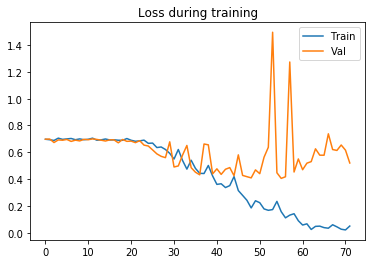

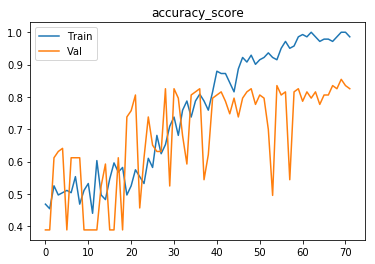

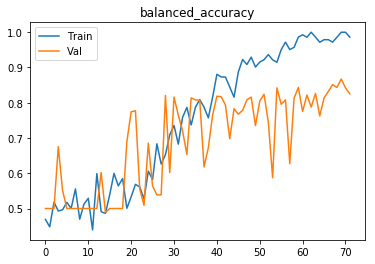

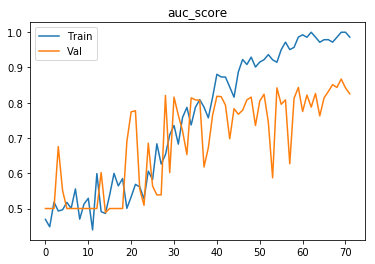

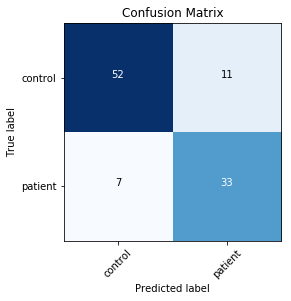

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.69443
Time elapsed: 0h:0m:4s
train accuracy_score: 49.65 %
train balanced_accuracy: 49.12 %
train auc_score: 49.12 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697635
[1,    10] loss: 0.69363
Time elapsed: 0h:0m:10s
train accuracy_score: 53.19 %
train balanced_accuracy: 52.48 %
train auc_score: 52.48 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695413
[2,    10] loss: 0.69616
Time elapsed: 0h:0m:16s
train accuracy_score: 51.06 %
train balanced_accuracy: 51.66 %
train auc_score: 51.66 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.688553
[3,    10] loss: 0.69285
Time elapsed: 0h:0m:22s
train accuracy_score: 50.35 %
train balanced_accuracy: 51.24 %
train auc_score: 51.24 %
val accuracy_score:

[34,    10] loss: 0.67681
Time elapsed: 0h:3m:32s
train accuracy_score: 59.57 %
train balanced_accuracy: 60.02 %
train auc_score: 60.02 %
val accuracy_score: 74.76 %
val balanced_accuracy: 71.15 %
val auc_score: 71.15 %
Val loss: 0.631014
[35,    10] loss: 0.64767
Time elapsed: 0h:3m:38s
train accuracy_score: 62.41 %
train balanced_accuracy: 62.11 %
train auc_score: 62.11 %
val accuracy_score: 67.96 %
val balanced_accuracy: 60.12 %
val auc_score: 60.12 %
Val loss: 0.615527
[36,    10] loss: 0.66935
Time elapsed: 0h:3m:44s
train accuracy_score: 63.12 %
train balanced_accuracy: 63.35 %
train auc_score: 63.35 %
val accuracy_score: 79.61 %
val balanced_accuracy: 79.68 %
val auc_score: 79.68 %
Val loss: 0.628038
[37,    10] loss: 0.64642
Time elapsed: 0h:3m:50s
train accuracy_score: 63.83 %
train balanced_accuracy: 64.07 %
train auc_score: 64.07 %
val accuracy_score: 76.70 %
val balanced_accuracy: 77.76 %
val auc_score: 77.76 %
Val loss: 0.624652
[38,    10] loss: 0.64203
Time elapsed: 0h:3

val accuracy_score: 76.70 %
val balanced_accuracy: 74.56 %
val auc_score: 74.56 %
Val loss: 0.448456
[69,    10] loss: 0.39339
Time elapsed: 0h:7m:8s
train accuracy_score: 85.11 %
train balanced_accuracy: 85.24 %
train auc_score: 85.24 %
val accuracy_score: 74.76 %
val balanced_accuracy: 73.89 %
val auc_score: 73.89 %
Val loss: 0.457168
[70,    10] loss: 0.41660
Time elapsed: 0h:7m:14s
train accuracy_score: 85.11 %
train balanced_accuracy: 85.08 %
train auc_score: 85.08 %
val accuracy_score: 73.79 %
val balanced_accuracy: 75.38 %
val auc_score: 75.38 %
Val loss: 0.480045
[71,    10] loss: 0.38354
Time elapsed: 0h:7m:20s
train accuracy_score: 84.40 %
train balanced_accuracy: 84.57 %
train auc_score: 84.57 %
val accuracy_score: 72.82 %
val balanced_accuracy: 75.50 %
val auc_score: 75.50 %
Val loss: 0.513110
[72,    10] loss: 0.36652
Time elapsed: 0h:7m:27s
train accuracy_score: 82.98 %
train balanced_accuracy: 83.03 %
train auc_score: 83.03 %
val accuracy_score: 80.58 %
val balanced_accu

[103,    10] loss: 0.29544
Time elapsed: 0h:10m:38s
train accuracy_score: 86.52 %
train balanced_accuracy: 86.50 %
train auc_score: 86.50 %
val accuracy_score: 77.67 %
val balanced_accuracy: 74.44 %
val auc_score: 74.44 %
Val loss: 0.418774
[104,    10] loss: 0.25361
Time elapsed: 0h:10m:44s
train accuracy_score: 89.36 %
train balanced_accuracy: 89.52 %
train auc_score: 89.52 %
val accuracy_score: 69.90 %
val balanced_accuracy: 74.03 %
val auc_score: 74.03 %
Val loss: 0.582878
[105,    10] loss: 0.25384
Time elapsed: 0h:10m:50s
train accuracy_score: 90.07 %
train balanced_accuracy: 90.10 %
train auc_score: 90.10 %
val accuracy_score: 76.70 %
val balanced_accuracy: 76.39 %
val auc_score: 76.39 %
Val loss: 0.402545
[106,    10] loss: 0.23029
Time elapsed: 0h:10m:56s
train accuracy_score: 92.20 %
train balanced_accuracy: 92.27 %
train auc_score: 92.27 %
val accuracy_score: 76.70 %
val balanced_accuracy: 76.39 %
val auc_score: 76.39 %
Val loss: 0.398072
[107,    10] loss: 0.23923
Time elap

Time elapsed: 0h:14m:6s
train accuracy_score: 95.04 %
train balanced_accuracy: 95.02 %
train auc_score: 95.02 %
val accuracy_score: 82.52 %
val balanced_accuracy: 81.15 %
val auc_score: 81.15 %
Val loss: 0.332210
[138,    10] loss: 0.21853
Time elapsed: 0h:14m:13s
train accuracy_score: 92.91 %
train balanced_accuracy: 92.90 %
train auc_score: 92.90 %
val accuracy_score: 84.47 %
val balanced_accuracy: 86.39 %
val auc_score: 86.39 %
Val loss: 0.403586
[139,    10] loss: 0.10623
Time elapsed: 0h:14m:19s
train accuracy_score: 96.45 %
train balanced_accuracy: 96.53 %
train auc_score: 96.53 %
val accuracy_score: 82.52 %
val balanced_accuracy: 85.71 %
val auc_score: 85.71 %
Val loss: 0.476978
[140,    10] loss: 0.09533
Time elapsed: 0h:14m:25s
train accuracy_score: 96.45 %
train balanced_accuracy: 96.44 %
train auc_score: 96.44 %
val accuracy_score: 80.58 %
val balanced_accuracy: 79.56 %
val auc_score: 79.56 %
Val loss: 0.353352
[141,    10] loss: 0.14850
Time elapsed: 0h:14m:31s
train accura

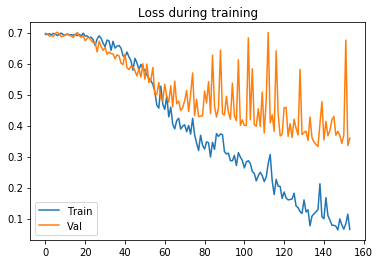

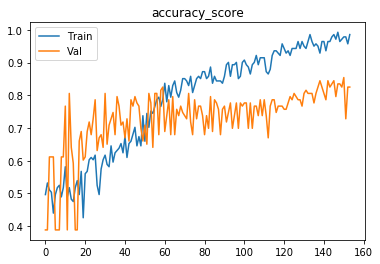

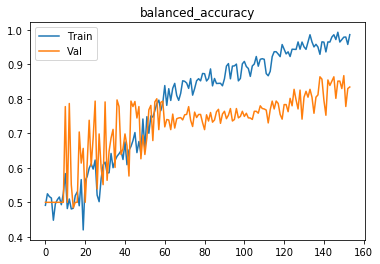

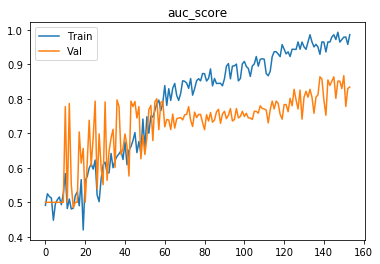

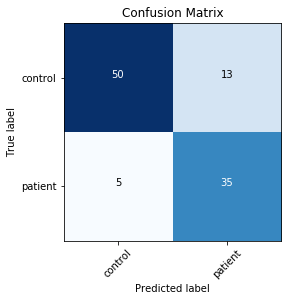

Finished outer fold.
{'final_acc': 0.8547619047619048, 'best_acc': 0.8865079365079364, 'final_iter': 113, 'best_iter': 101, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}
###### Starting outer fold 7
# of patients 116, # of healthy controls 118
140
94
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    10] loss: 0.69850
[0,    20] loss: 0.69179
Time elapsed: 0h:0m:2s
train accuracy_score: 52.14 %
train balanced_accuracy: 51.95 %
train auc_score: 51.95 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716645
[1,    10] loss: 0.68687
[1,    20] loss: 0.71528
Time elapsed: 0h:0m:6s
train accuracy_score: 52.86 %
train balanced_accuracy: 50.08 %
train auc_score: 50.08 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693014
[2,    10] loss: 0.68673
[2,    20] loss: 

val accuracy_score: 63.83 %
val balanced_accuracy: 61.36 %
val auc_score: 61.36 %
Val loss: 0.645860
[30,    10] loss: 0.60168
[30,    20] loss: 0.59670
Time elapsed: 0h:2m:3s
train accuracy_score: 62.86 %
train balanced_accuracy: 62.49 %
train auc_score: 62.49 %
val accuracy_score: 61.70 %
val balanced_accuracy: 57.14 %
val auc_score: 57.14 %
Val loss: 0.680258
[31,    10] loss: 0.71462
[31,    20] loss: 0.66382
Time elapsed: 0h:2m:7s
train accuracy_score: 58.57 %
train balanced_accuracy: 57.86 %
train auc_score: 57.86 %
val accuracy_score: 61.70 %
val balanced_accuracy: 57.14 %
val auc_score: 57.14 %
Val loss: 0.658922
[32,    10] loss: 0.62412
[32,    20] loss: 0.61213
Time elapsed: 0h:2m:11s
train accuracy_score: 67.14 %
train balanced_accuracy: 66.71 %
train auc_score: 66.71 %
val accuracy_score: 63.83 %
val balanced_accuracy: 62.27 %
val auc_score: 62.27 %
Val loss: 0.644504
[33,    10] loss: 0.58434
[33,    20] loss: 0.56962
Time elapsed: 0h:2m:15s
train accuracy_score: 65.71 %


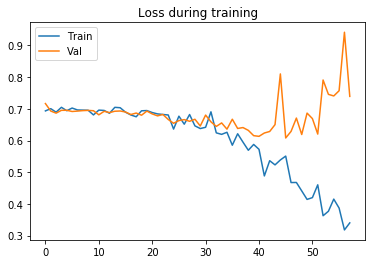

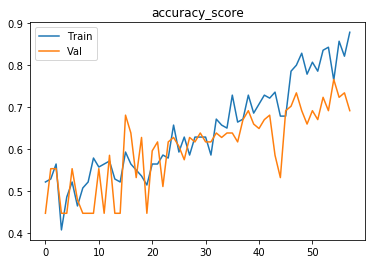

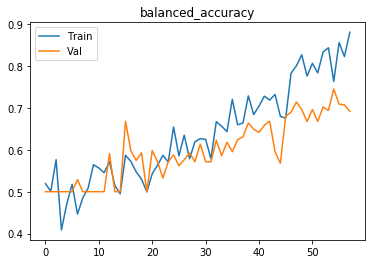

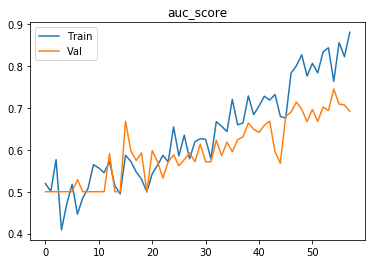

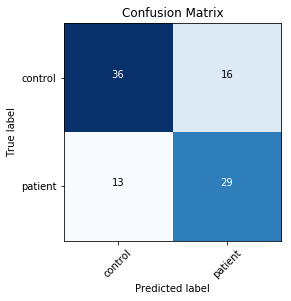

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.68972
[0,    20] loss: 0.68871
[0,    30] loss: 0.69297
Time elapsed: 0h:0m:2s
train accuracy_score: 55.71 %
train balanced_accuracy: 53.44 %
train auc_score: 53.44 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696938
[1,    10] loss: 0.69580
[1,    20] loss: 0.70470
[1,    30] loss: 0.69230
Time elapsed: 0h:0m:7s
train accuracy_score: 47.14 %
train balanced_accuracy: 47.05 %
train auc_score: 47.05 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.690389
[2,    10] loss: 0.68811
[2,    20] loss: 0.69804
[2,    30] loss: 0.69126
Time elapsed: 0h:0m:11s
train accuracy_score: 49.29 %
train balanced_accuracy: 47.85 %
train auc_score: 47.85 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698055
[3,    1

[28,    10] loss: 0.69116
[28,    20] loss: 0.66496
[28,    30] loss: 0.64680
Time elapsed: 0h:2m:4s
train accuracy_score: 60.71 %
train balanced_accuracy: 60.71 %
train auc_score: 60.71 %
val accuracy_score: 59.57 %
val balanced_accuracy: 54.76 %
val auc_score: 54.76 %
Val loss: 0.661603
[29,    10] loss: 0.69071
[29,    20] loss: 0.63869
[29,    30] loss: 0.68166
Time elapsed: 0h:2m:8s
train accuracy_score: 61.43 %
train balanced_accuracy: 61.38 %
train auc_score: 61.38 %
val accuracy_score: 70.21 %
val balanced_accuracy: 67.35 %
val auc_score: 67.35 %
Val loss: 0.660460
[30,    10] loss: 0.64710
[30,    20] loss: 0.63973
[30,    30] loss: 0.62061
Time elapsed: 0h:2m:13s
train accuracy_score: 63.57 %
train balanced_accuracy: 62.43 %
train auc_score: 62.43 %
val accuracy_score: 65.96 %
val balanced_accuracy: 66.03 %
val auc_score: 66.03 %
Val loss: 0.659070
[31,    10] loss: 0.67528
[31,    20] loss: 0.63827
[31,    30] loss: 0.64314
Time elapsed: 0h:2m:17s
train accuracy_score: 67.14

[56,    30] loss: 0.36256
Time elapsed: 0h:4m:6s
train accuracy_score: 82.14 %
train balanced_accuracy: 82.45 %
train auc_score: 82.45 %
val accuracy_score: 77.66 %
val balanced_accuracy: 76.83 %
val auc_score: 76.83 %
Val loss: 0.580804
[57,    10] loss: 0.39808
[57,    20] loss: 0.29074
[57,    30] loss: 0.46198
Time elapsed: 0h:4m:11s
train accuracy_score: 84.29 %
train balanced_accuracy: 84.15 %
train auc_score: 84.15 %
val accuracy_score: 76.60 %
val balanced_accuracy: 74.73 %
val auc_score: 74.73 %
Val loss: 0.643180
[58,    10] loss: 0.46400
[58,    20] loss: 0.44560
[58,    30] loss: 0.34430
Time elapsed: 0h:4m:15s
train accuracy_score: 82.14 %
train balanced_accuracy: 82.13 %
train auc_score: 82.13 %
val accuracy_score: 72.34 %
val balanced_accuracy: 72.02 %
val auc_score: 72.02 %
Val loss: 0.592363
[59,    10] loss: 0.28572
[59,    20] loss: 0.30400
[59,    30] loss: 0.46965
Time elapsed: 0h:4m:19s
train accuracy_score: 83.57 %
train balanced_accuracy: 83.89 %
train auc_score

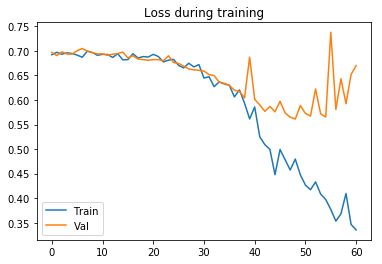

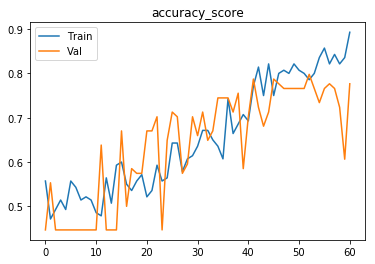

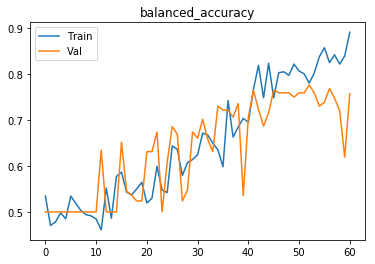

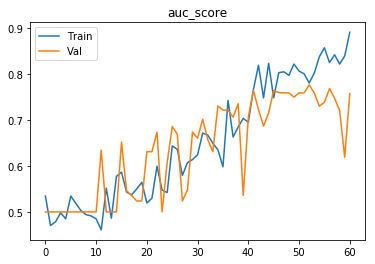

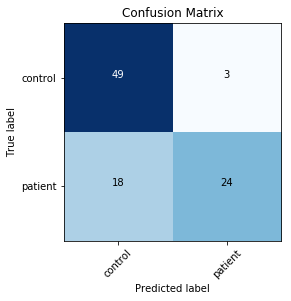

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.69750
[0,    20] loss: 0.70088
[0,    30] loss: 0.69752
Time elapsed: 0h:0m:5s
train accuracy_score: 44.29 %
train balanced_accuracy: 43.69 %
train auc_score: 43.69 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694949
[1,    10] loss: 0.69569
[1,    20] loss: 0.69176
[1,    30] loss: 0.69433
Time elapsed: 0h:0m:11s
train accuracy_score: 53.57 %
train balanced_accuracy: 51.00 %
train auc_score: 51.00 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697929
[2,    10] loss: 0.69588
[2,    20] loss: 0.69407
[2,    30] loss: 0.69233
Time elapsed: 0h:0m:18s
train accuracy_score: 47.86 %
train balanced_accuracy: 47.56 %
train auc_score: 47.56 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695786
[3,    

[28,    10] loss: 0.49461
[28,    20] loss: 0.45846
[28,    30] loss: 0.44510
Time elapsed: 0h:3m:13s
train accuracy_score: 77.86 %
train balanced_accuracy: 77.99 %
train auc_score: 77.99 %
val accuracy_score: 64.89 %
val balanced_accuracy: 65.29 %
val auc_score: 65.29 %
Val loss: 0.620919
[29,    10] loss: 0.50631
[29,    20] loss: 0.39693
[29,    30] loss: 0.52213
Time elapsed: 0h:3m:19s
train accuracy_score: 75.71 %
train balanced_accuracy: 75.39 %
train auc_score: 75.39 %
val accuracy_score: 67.02 %
val balanced_accuracy: 67.45 %
val auc_score: 67.45 %
Val loss: 0.596450
[30,    10] loss: 0.48468
[30,    20] loss: 0.34890
[30,    30] loss: 0.52855
Time elapsed: 0h:3m:26s
train accuracy_score: 77.14 %
train balanced_accuracy: 76.99 %
train auc_score: 76.99 %
val accuracy_score: 69.15 %
val balanced_accuracy: 69.37 %
val auc_score: 69.37 %
Val loss: 0.587296
[31,    10] loss: 0.38933
[31,    20] loss: 0.39563
[31,    30] loss: 0.43216
Time elapsed: 0h:3m:33s
train accuracy_score: 82.

[56,    30] loss: 0.16486
Time elapsed: 0h:6m:23s
train accuracy_score: 95.00 %
train balanced_accuracy: 95.11 %
train auc_score: 95.11 %
val accuracy_score: 76.60 %
val balanced_accuracy: 75.87 %
val auc_score: 75.87 %
Val loss: 0.657228
[57,    10] loss: 0.18358
[57,    20] loss: 0.14908
[57,    30] loss: 0.11503
Time elapsed: 0h:6m:30s
train accuracy_score: 94.29 %
train balanced_accuracy: 94.10 %
train auc_score: 94.10 %
val accuracy_score: 76.60 %
val balanced_accuracy: 75.87 %
val auc_score: 75.87 %
Val loss: 0.658545
[58,    10] loss: 0.19029
[58,    20] loss: 0.18114
[58,    30] loss: 0.17194
Time elapsed: 0h:6m:37s
train accuracy_score: 92.14 %
train balanced_accuracy: 92.08 %
train auc_score: 92.08 %
val accuracy_score: 78.72 %
val balanced_accuracy: 76.19 %
val auc_score: 76.19 %
Val loss: 1.107413
[59,    10] loss: 0.29235
[59,    20] loss: 0.18322
[59,    30] loss: 0.20802
Time elapsed: 0h:6m:44s
train accuracy_score: 90.71 %
train balanced_accuracy: 90.72 %
train auc_scor

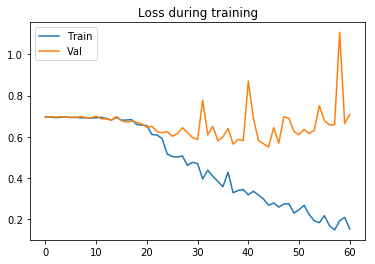

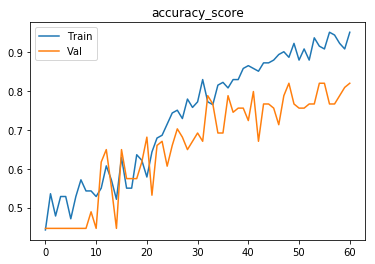

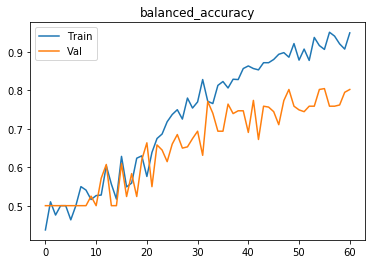

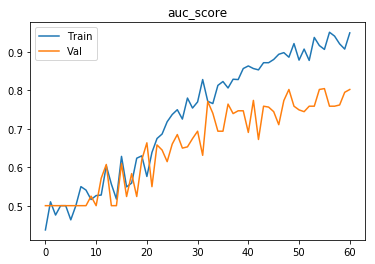

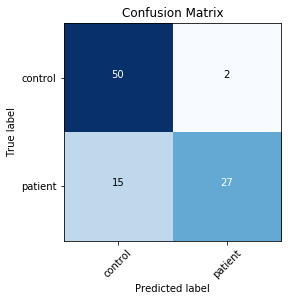

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.68921
Time elapsed: 0h:0m:4s
train accuracy_score: 52.86 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697704
[1,    10] loss: 0.68911
Time elapsed: 0h:0m:10s
train accuracy_score: 55.00 %
train balanced_accuracy: 53.09 %
train auc_score: 53.09 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693567
[2,    10] loss: 0.69567
Time elapsed: 0h:0m:16s
train accuracy_score: 49.29 %
train balanced_accuracy: 49.32 %
train auc_score: 49.32 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693746
[3,    10] loss: 0.69521
Time elapsed: 0h:0m:22s
train accuracy_score: 50.71 %
train balanced_accuracy: 48.30 %
train auc_score: 48.30 %
val accuracy_score:

[34,    10] loss: 0.63282
Time elapsed: 0h:3m:27s
train accuracy_score: 59.29 %
train balanced_accuracy: 58.95 %
train auc_score: 58.95 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704694
[35,    10] loss: 0.63704
Time elapsed: 0h:3m:33s
train accuracy_score: 59.29 %
train balanced_accuracy: 58.70 %
train auc_score: 58.70 %
val accuracy_score: 65.96 %
val balanced_accuracy: 62.36 %
val auc_score: 62.36 %
Val loss: 0.647094
[36,    10] loss: 0.66101
Time elapsed: 0h:3m:39s
train accuracy_score: 61.43 %
train balanced_accuracy: 60.32 %
train auc_score: 60.32 %
val accuracy_score: 58.51 %
val balanced_accuracy: 53.57 %
val auc_score: 53.57 %
Val loss: 0.671918
[37,    10] loss: 0.65996
Time elapsed: 0h:3m:45s
train accuracy_score: 57.86 %
train balanced_accuracy: 59.23 %
train auc_score: 59.23 %
val accuracy_score: 60.64 %
val balanced_accuracy: 60.76 %
val auc_score: 60.76 %
Val loss: 0.658899
[38,    10] loss: 0.62635
Time elapsed: 0h:3

val accuracy_score: 73.40 %
val balanced_accuracy: 72.30 %
val auc_score: 72.30 %
Val loss: 0.611569
[69,    10] loss: 0.33162
Time elapsed: 0h:6m:55s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.83 %
train auc_score: 85.83 %
val accuracy_score: 72.34 %
val balanced_accuracy: 71.34 %
val auc_score: 71.34 %
Val loss: 0.599824
[70,    10] loss: 0.37141
Time elapsed: 0h:7m:1s
train accuracy_score: 83.57 %
train balanced_accuracy: 83.64 %
train auc_score: 83.64 %
val accuracy_score: 79.79 %
val balanced_accuracy: 77.84 %
val auc_score: 77.84 %
Val loss: 0.652846
[71,    10] loss: 0.33528
Time elapsed: 0h:7m:7s
train accuracy_score: 84.29 %
train balanced_accuracy: 84.40 %
train auc_score: 84.40 %
val accuracy_score: 73.40 %
val balanced_accuracy: 73.21 %
val auc_score: 73.21 %
Val loss: 0.588795
[72,    10] loss: 0.32326
Time elapsed: 0h:7m:13s
train accuracy_score: 87.86 %
train balanced_accuracy: 88.10 %
train auc_score: 88.10 %
val accuracy_score: 76.60 %
val balanced_accur

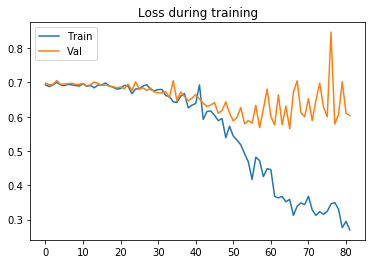

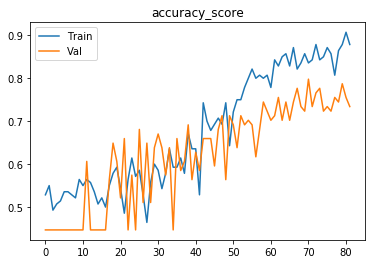

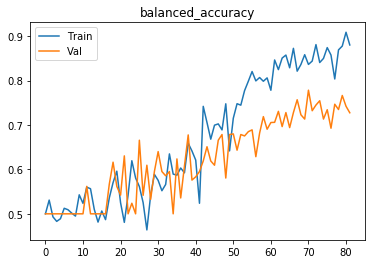

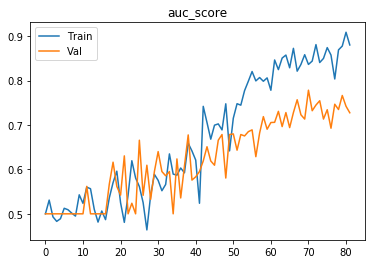

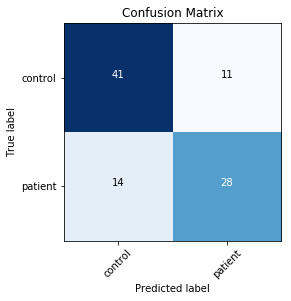

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    10] loss: 0.69337
Time elapsed: 0h:0m:2s
train accuracy_score: 51.43 %
train balanced_accuracy: 48.98 %
train auc_score: 48.98 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697173
[1,    10] loss: 0.69534
Time elapsed: 0h:0m:5s
train accuracy_score: 51.43 %
train balanced_accuracy: 48.65 %
train auc_score: 48.65 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701273
[2,    10] loss: 0.69110
Time elapsed: 0h:0m:9s
train accuracy_score: 52.86 %
train balanced_accuracy: 50.08 %
train auc_score: 50.08 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.702083
[3,    10] loss: 0.69757
Time elapsed: 0h:0m:13s
train accuracy_score: 52.86 %
train balanced_accuracy: 50.08 %
train auc_score: 50.08 %
val accuracy_score: 

[34,    10] loss: 0.64140
Time elapsed: 0h:2m:8s
train accuracy_score: 66.43 %
train balanced_accuracy: 65.62 %
train auc_score: 65.62 %
val accuracy_score: 63.83 %
val balanced_accuracy: 61.58 %
val auc_score: 61.58 %
Val loss: 0.644941
[35,    10] loss: 0.57093
Time elapsed: 0h:2m:11s
train accuracy_score: 65.71 %
train balanced_accuracy: 65.60 %
train auc_score: 65.60 %
val accuracy_score: 61.70 %
val balanced_accuracy: 58.06 %
val auc_score: 58.06 %
Val loss: 0.663862
[36,    10] loss: 0.58002
Time elapsed: 0h:2m:15s
train accuracy_score: 64.29 %
train balanced_accuracy: 64.00 %
train auc_score: 64.00 %
val accuracy_score: 61.70 %
val balanced_accuracy: 60.12 %
val auc_score: 60.12 %
Val loss: 0.651807
[37,    10] loss: 0.61093
Time elapsed: 0h:2m:19s
train accuracy_score: 66.43 %
train balanced_accuracy: 65.79 %
train auc_score: 65.79 %
val accuracy_score: 63.83 %
val balanced_accuracy: 59.52 %
val auc_score: 59.52 %
Val loss: 0.679016
[38,    10] loss: 0.58510
Time elapsed: 0h:2m

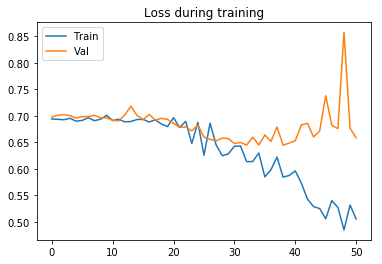

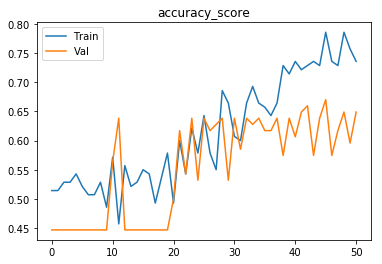

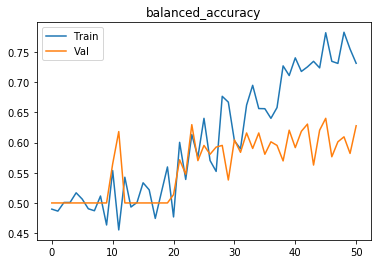

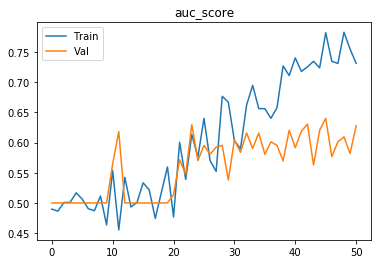

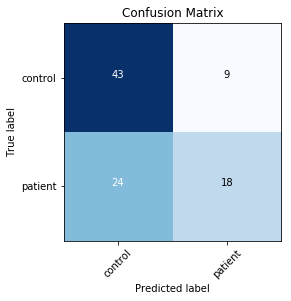

Finished outer fold.
{'final_acc': 0.8021978021978023, 'best_acc': 0.8044871794871795, 'final_iter': 61, 'best_iter': 56, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}
###### Starting outer fold 8
# of patients 118, # of healthy controls 119
138
99
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    10] loss: 0.68475
[0,    20] loss: 0.68178
[0,    30] loss: 0.71487
Time elapsed: 0h:0m:2s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704353
[1,    10] loss: 0.69412
[1,    20] loss: 0.69821
[1,    30] loss: 0.67950
Time elapsed: 0h:0m:6s
train accuracy_score: 55.80 %
train balanced_accuracy: 49.59 %
train auc_score: 49.59 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.7

[27,    10] loss: 0.68820
[27,    20] loss: 0.72462
[27,    30] loss: 0.69484
Time elapsed: 0h:2m:1s
train accuracy_score: 53.62 %
train balanced_accuracy: 49.84 %
train auc_score: 49.84 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.703070
[28,    10] loss: 0.64830
[28,    20] loss: 0.69189
[28,    30] loss: 0.70830
Time elapsed: 0h:2m:5s
train accuracy_score: 56.52 %
train balanced_accuracy: 49.37 %
train auc_score: 49.37 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.711736
[29,    10] loss: 0.67448
[29,    20] loss: 0.70925
[29,    30] loss: 0.68934
Time elapsed: 0h:2m:9s
train accuracy_score: 55.80 %
train balanced_accuracy: 50.45 %
train auc_score: 50.45 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.710246
[30,    10] loss: 0.71293
[30,    20] loss: 0.69438
[30,    30] loss: 0.66246
Time elapsed: 0h:2m:14s
train accuracy_score: 57.25 

[55,    30] loss: 0.61747
Time elapsed: 0h:4m:2s
train accuracy_score: 64.49 %
train balanced_accuracy: 60.62 %
train auc_score: 60.62 %
val accuracy_score: 68.69 %
val balanced_accuracy: 68.33 %
val auc_score: 68.33 %
Val loss: 0.633287
[56,    10] loss: 0.63713
[56,    20] loss: 0.55752
[56,    30] loss: 0.60294
Time elapsed: 0h:4m:6s
train accuracy_score: 71.01 %
train balanced_accuracy: 68.46 %
train auc_score: 68.46 %
val accuracy_score: 72.73 %
val balanced_accuracy: 73.46 %
val auc_score: 73.46 %
Val loss: 0.634655
[57,    10] loss: 0.55933
[57,    20] loss: 0.67307
[57,    30] loss: 0.63006
Time elapsed: 0h:4m:11s
train accuracy_score: 62.32 %
train balanced_accuracy: 58.72 %
train auc_score: 58.72 %
val accuracy_score: 67.68 %
val balanced_accuracy: 70.64 %
val auc_score: 70.64 %
Val loss: 0.656812
[58,    10] loss: 0.62554
[58,    20] loss: 0.68488
[58,    30] loss: 0.57363
Time elapsed: 0h:4m:15s
train accuracy_score: 69.57 %
train balanced_accuracy: 68.70 %
train auc_score:

val accuracy_score: 60.61 %
val balanced_accuracy: 67.50 %
val auc_score: 67.50 %
Val loss: 0.745056
[84,    10] loss: 0.54027
[84,    20] loss: 0.43694
[84,    30] loss: 0.34423
Time elapsed: 0h:6m:9s
train accuracy_score: 77.54 %
train balanced_accuracy: 76.52 %
train auc_score: 76.52 %
val accuracy_score: 79.80 %
val balanced_accuracy: 81.54 %
val auc_score: 81.54 %
Val loss: 0.513330
[85,    10] loss: 0.33692
[85,    20] loss: 0.32776
[85,    30] loss: 0.31357
Time elapsed: 0h:6m:13s
train accuracy_score: 84.06 %
train balanced_accuracy: 84.36 %
train auc_score: 84.36 %
val accuracy_score: 74.75 %
val balanced_accuracy: 78.27 %
val auc_score: 78.27 %
Val loss: 0.575696
[86,    10] loss: 0.37359
[86,    20] loss: 0.42137
[86,    30] loss: 0.21884
Time elapsed: 0h:6m:17s
train accuracy_score: 82.61 %
train balanced_accuracy: 81.38 %
train auc_score: 81.38 %
val accuracy_score: 50.51 %
val balanced_accuracy: 59.17 %
val auc_score: 59.17 %
Val loss: 0.931401
[87,    10] loss: 0.56187
[

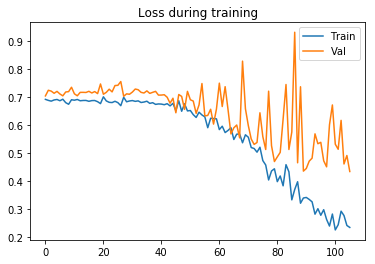

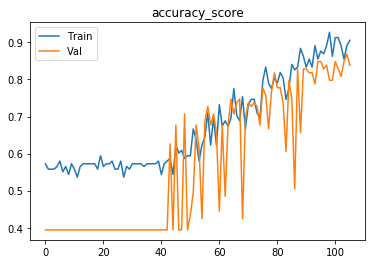

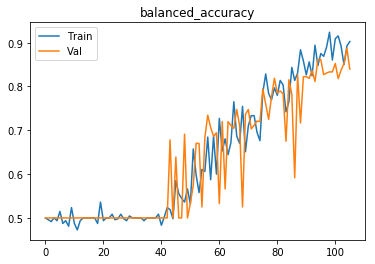

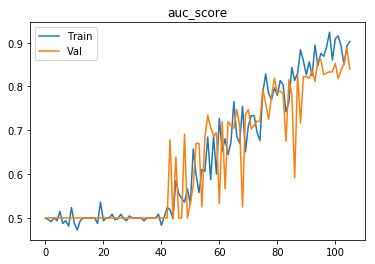

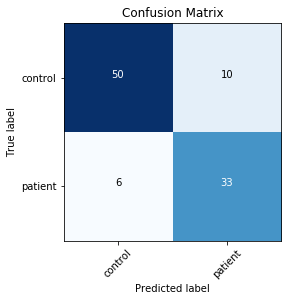

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 238997
[0,    10] loss: 0.69593
[0,    20] loss: 0.68485
[0,    30] loss: 0.69962
Time elapsed: 0h:0m:2s
train accuracy_score: 53.62 %
train balanced_accuracy: 48.34 %
train auc_score: 48.34 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.729727
[1,    10] loss: 0.71501
[1,    20] loss: 0.70957
[1,    30] loss: 0.68525
Time elapsed: 0h:0m:7s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704227
[2,    10] loss: 0.69239
[2,    20] loss: 0.71830
[2,    30] loss: 0.67853
Time elapsed: 0h:0m:11s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.21 %
train auc_score: 50.21 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.711361
[3,    

[28,    10] loss: 0.70415
[28,    20] loss: 0.65485
[28,    30] loss: 0.69342
Time elapsed: 0h:2m:5s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.723326
[29,    10] loss: 0.67066
[29,    20] loss: 0.70035
[29,    30] loss: 0.68330
Time elapsed: 0h:2m:9s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.715857
[30,    10] loss: 0.69646
[30,    20] loss: 0.68456
[30,    30] loss: 0.65454
Time elapsed: 0h:2m:14s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717920
[31,    10] loss: 0.66103
[31,    20] loss: 0.68347
[31,    30] loss: 0.65233
Time elapsed: 0h:2m:18s
train accuracy_score: 57.97

[56,    30] loss: 0.64565
Time elapsed: 0h:4m:7s
train accuracy_score: 73.19 %
train balanced_accuracy: 71.22 %
train auc_score: 71.22 %
val accuracy_score: 75.76 %
val balanced_accuracy: 76.86 %
val auc_score: 76.86 %
Val loss: 0.591310
[57,    10] loss: 0.56058
[57,    20] loss: 0.53898
[57,    30] loss: 0.60227
Time elapsed: 0h:4m:12s
train accuracy_score: 68.12 %
train balanced_accuracy: 66.79 %
train auc_score: 66.79 %
val accuracy_score: 62.63 %
val balanced_accuracy: 69.17 %
val auc_score: 69.17 %
Val loss: 0.680901
[58,    10] loss: 0.61101
[58,    20] loss: 0.59449
[58,    30] loss: 0.62220
Time elapsed: 0h:4m:17s
train accuracy_score: 67.39 %
train balanced_accuracy: 64.87 %
train auc_score: 64.87 %
val accuracy_score: 69.70 %
val balanced_accuracy: 75.00 %
val auc_score: 75.00 %
Val loss: 0.640883
[59,    10] loss: 0.51551
[59,    20] loss: 0.53844
[59,    30] loss: 0.57100
Time elapsed: 0h:4m:21s
train accuracy_score: 74.64 %
train balanced_accuracy: 72.06 %
train auc_score

val accuracy_score: 83.84 %
val balanced_accuracy: 83.53 %
val auc_score: 83.53 %
Val loss: 0.376160
[85,    10] loss: 0.30353
[85,    20] loss: 0.29247
[85,    30] loss: 0.31775
Time elapsed: 0h:6m:14s
train accuracy_score: 85.51 %
train balanced_accuracy: 84.77 %
train auc_score: 84.77 %
val accuracy_score: 78.79 %
val balanced_accuracy: 82.50 %
val auc_score: 82.50 %
Val loss: 0.565485
[86,    10] loss: 0.31237
[86,    20] loss: 0.31945
[86,    30] loss: 0.21787
Time elapsed: 0h:6m:19s
train accuracy_score: 88.41 %
train balanced_accuracy: 88.59 %
train auc_score: 88.59 %
val accuracy_score: 80.81 %
val balanced_accuracy: 83.27 %
val auc_score: 83.27 %
Val loss: 0.441127
[87,    10] loss: 0.35705
[87,    20] loss: 0.37365
[87,    30] loss: 0.33592
Time elapsed: 0h:6m:23s
train accuracy_score: 82.61 %
train balanced_accuracy: 82.02 %
train auc_score: 82.02 %
val accuracy_score: 81.82 %
val balanced_accuracy: 84.10 %
val auc_score: 84.10 %
Val loss: 0.436285
[88,    10] loss: 0.17360


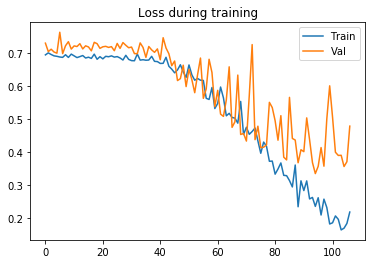

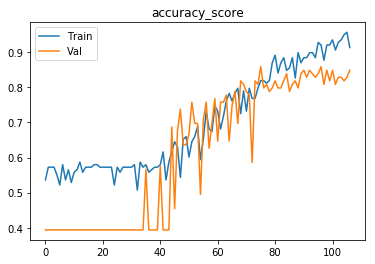

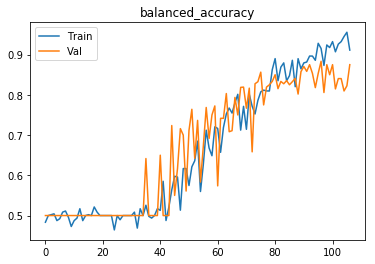

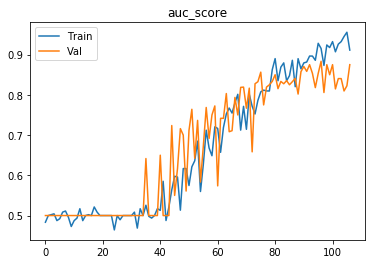

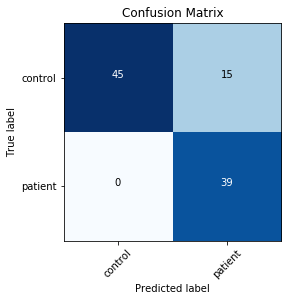

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.68883
[0,    20] loss: 0.68133
[0,    30] loss: 0.69465
Time elapsed: 0h:0m:4s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.730510
[1,    10] loss: 0.66548
[1,    20] loss: 0.71415
[1,    30] loss: 0.70736
Time elapsed: 0h:0m:11s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705470
[2,    10] loss: 0.69258
[2,    20] loss: 0.67130
[2,    30] loss: 0.69127
Time elapsed: 0h:0m:18s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.739426
[3,    

[28,    10] loss: 0.63553
[28,    20] loss: 0.63372
[28,    30] loss: 0.58054
Time elapsed: 0h:3m:15s
train accuracy_score: 61.59 %
train balanced_accuracy: 56.59 %
train auc_score: 56.59 %
val accuracy_score: 70.71 %
val balanced_accuracy: 65.51 %
val auc_score: 65.51 %
Val loss: 0.625224
[29,    10] loss: 0.69199
[29,    20] loss: 0.61922
[29,    30] loss: 0.67311
Time elapsed: 0h:3m:21s
train accuracy_score: 59.42 %
train balanced_accuracy: 57.05 %
train auc_score: 57.05 %
val accuracy_score: 66.67 %
val balanced_accuracy: 65.77 %
val auc_score: 65.77 %
Val loss: 0.656152
[30,    10] loss: 0.67455
[30,    20] loss: 0.63961
[30,    30] loss: 0.58767
Time elapsed: 0h:3m:28s
train accuracy_score: 63.04 %
train balanced_accuracy: 62.36 %
train auc_score: 62.36 %
val accuracy_score: 41.41 %
val balanced_accuracy: 51.67 %
val auc_score: 51.67 %
Val loss: 0.740545
[31,    10] loss: 0.61881
[31,    20] loss: 0.64232
[31,    30] loss: 0.68595
Time elapsed: 0h:3m:35s
train accuracy_score: 60.

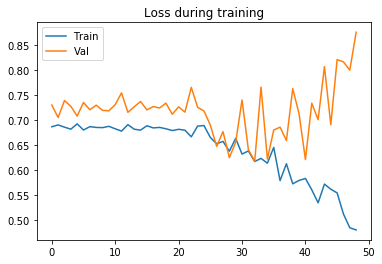

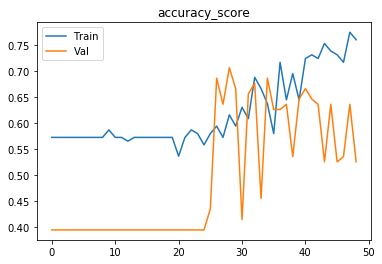

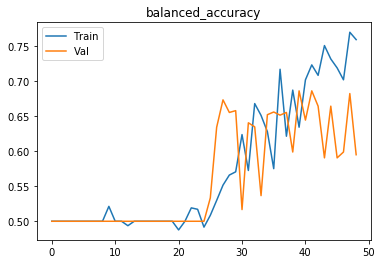

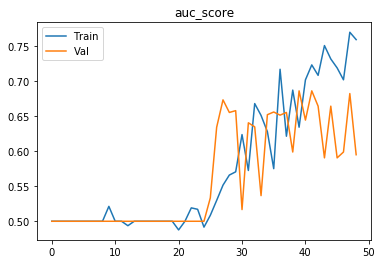

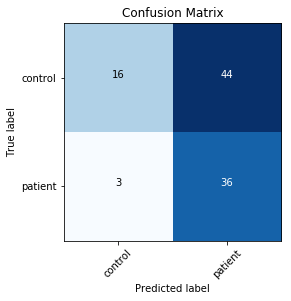

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.69023
[0,    20] loss: 0.65597
[0,    30] loss: 0.75755
Time elapsed: 0h:0m:4s
train accuracy_score: 53.62 %
train balanced_accuracy: 47.05 %
train auc_score: 47.05 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704951
[1,    10] loss: 0.69027
[1,    20] loss: 0.69511
[1,    30] loss: 0.68861
Time elapsed: 0h:0m:11s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700922
[2,    10] loss: 0.68296
[2,    20] loss: 0.69736
[2,    30] loss: 0.68785
Time elapsed: 0h:0m:18s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.724624
[3,    

[28,    10] loss: 0.66241
[28,    20] loss: 0.71481
[28,    30] loss: 0.70132
Time elapsed: 0h:3m:15s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700206
[29,    10] loss: 0.65678
[29,    20] loss: 0.69525
[29,    30] loss: 0.67371
Time elapsed: 0h:3m:22s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705667
[30,    10] loss: 0.66763
[30,    20] loss: 0.66950
[30,    30] loss: 0.68159
Time elapsed: 0h:3m:29s
train accuracy_score: 57.97 %
train balanced_accuracy: 50.85 %
train auc_score: 50.85 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704338
[31,    10] loss: 0.66488
[31,    20] loss: 0.69716
[31,    30] loss: 0.66744
Time elapsed: 0h:3m:35s
train accuracy_score: 57.

[56,    30] loss: 0.43801
Time elapsed: 0h:6m:24s
train accuracy_score: 83.33 %
train balanced_accuracy: 83.08 %
train auc_score: 83.08 %
val accuracy_score: 76.77 %
val balanced_accuracy: 79.49 %
val auc_score: 79.49 %
Val loss: 0.607453
[57,    10] loss: 0.53772
[57,    20] loss: 0.43999
[57,    30] loss: 0.43170
Time elapsed: 0h:6m:31s
train accuracy_score: 80.43 %
train balanced_accuracy: 79.91 %
train auc_score: 79.91 %
val accuracy_score: 78.79 %
val balanced_accuracy: 79.81 %
val auc_score: 79.81 %
Val loss: 0.453692
[58,    10] loss: 0.38740
[58,    20] loss: 0.34647
[58,    30] loss: 0.35019
Time elapsed: 0h:6m:38s
train accuracy_score: 81.88 %
train balanced_accuracy: 81.39 %
train auc_score: 81.39 %
val accuracy_score: 76.77 %
val balanced_accuracy: 79.49 %
val auc_score: 79.49 %
Val loss: 0.628015
[59,    10] loss: 0.31919
[59,    20] loss: 0.35345
[59,    30] loss: 0.36651
Time elapsed: 0h:6m:45s
train accuracy_score: 83.33 %
train balanced_accuracy: 82.87 %
train auc_scor

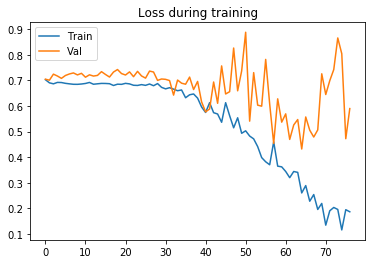

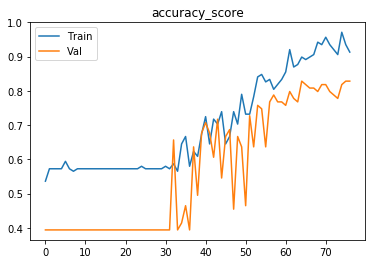

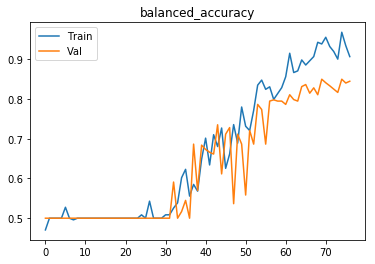

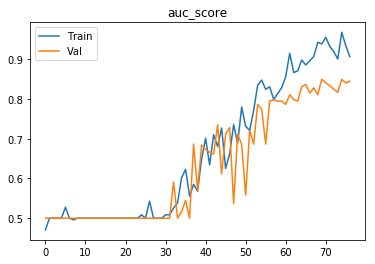

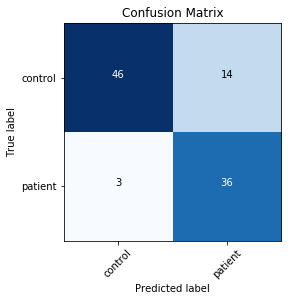

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.68781
Time elapsed: 0h:0m:4s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.735460
[1,    10] loss: 0.69804
Time elapsed: 0h:0m:10s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.712673
[2,    10] loss: 0.68719
Time elapsed: 0h:0m:16s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.721031
[3,    10] loss: 0.68576
Time elapsed: 0h:0m:22s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score

[34,    10] loss: 0.65014
Time elapsed: 0h:3m:29s
train accuracy_score: 63.04 %
train balanced_accuracy: 62.36 %
train auc_score: 62.36 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705487
[35,    10] loss: 0.66655
Time elapsed: 0h:3m:35s
train accuracy_score: 56.52 %
train balanced_accuracy: 49.37 %
train auc_score: 49.37 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.702942
[36,    10] loss: 0.65083
Time elapsed: 0h:3m:41s
train accuracy_score: 67.39 %
train balanced_accuracy: 66.80 %
train auc_score: 66.80 %
val accuracy_score: 58.59 %
val balanced_accuracy: 64.04 %
val auc_score: 64.04 %
Val loss: 0.677463
[37,    10] loss: 0.64933
Time elapsed: 0h:3m:47s
train accuracy_score: 59.42 %
train balanced_accuracy: 52.97 %
train auc_score: 52.97 %
val accuracy_score: 66.67 %
val balanced_accuracy: 66.22 %
val auc_score: 66.22 %
Val loss: 0.655514
[38,    10] loss: 0.64187
Time elapsed: 0h:3

val accuracy_score: 76.77 %
val balanced_accuracy: 79.04 %
val auc_score: 79.04 %
Val loss: 0.507974
[69,    10] loss: 0.21936
Time elapsed: 0h:6m:59s
train accuracy_score: 91.30 %
train balanced_accuracy: 91.12 %
train auc_score: 91.12 %
val accuracy_score: 77.78 %
val balanced_accuracy: 80.32 %
val auc_score: 80.32 %
Val loss: 0.677364
[70,    10] loss: 0.20526
Time elapsed: 0h:7m:5s
train accuracy_score: 91.30 %
train balanced_accuracy: 91.12 %
train auc_score: 91.12 %
val accuracy_score: 76.77 %
val balanced_accuracy: 79.49 %
val auc_score: 79.49 %
Val loss: 0.804026
[71,    10] loss: 0.20451
Time elapsed: 0h:7m:12s
train accuracy_score: 91.30 %
train balanced_accuracy: 90.90 %
train auc_score: 90.90 %
val accuracy_score: 80.81 %
val balanced_accuracy: 78.78 %
val auc_score: 78.78 %
Val loss: 0.386717
[72,    10] loss: 0.14432
Time elapsed: 0h:7m:18s
train accuracy_score: 95.65 %
train balanced_accuracy: 95.56 %
train auc_score: 95.56 %
val accuracy_score: 73.74 %
val balanced_accu

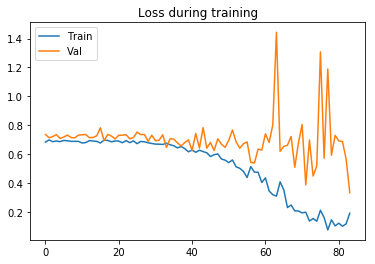

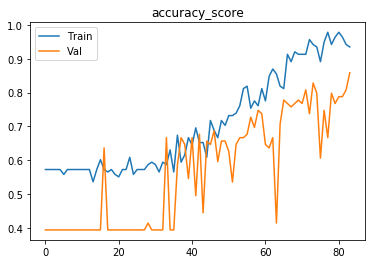

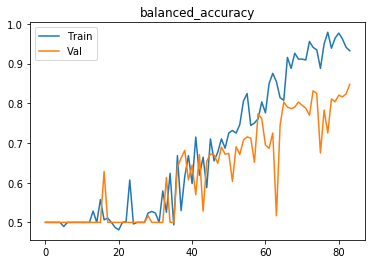

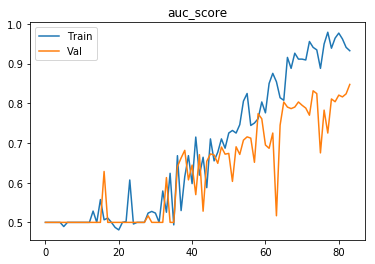

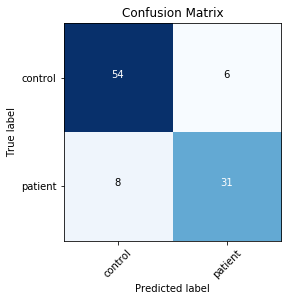

Finished outer fold.
{'final_acc': 0.875, 'best_acc': 0.8833333333333334, 'final_iter': 107, 'best_iter': 97, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1}
###### Starting outer fold 9
# of patients 121, # of healthy controls 128
137
112
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69658
[0,    20] loss: 0.69306
[0,    30] loss: 0.69634
Time elapsed: 0h:0m:2s
train accuracy_score: 45.26 %
train balanced_accuracy: 45.18 %
train auc_score: 45.18 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694285
[1,    10] loss: 0.69621
[1,    20] loss: 0.69742
[1,    30] loss: 0.69342
Time elapsed: 0h:0m:7s
train accuracy_score: 49.64 %
train balanced_accuracy: 48.57 %
train auc_score: 48.57 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696073
[2,  

[27,    10] loss: 0.69005
[27,    20] loss: 0.69155
[27,    30] loss: 0.69588
Time elapsed: 0h:2m:4s
train accuracy_score: 49.64 %
train balanced_accuracy: 48.76 %
train auc_score: 48.76 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.692993
[28,    10] loss: 0.69316
[28,    20] loss: 0.69042
[28,    30] loss: 0.68798
Time elapsed: 0h:2m:9s
train accuracy_score: 54.01 %
train balanced_accuracy: 53.14 %
train auc_score: 53.14 %
val accuracy_score: 65.18 %
val balanced_accuracy: 63.53 %
val auc_score: 63.53 %
Val loss: 0.690363
[29,    10] loss: 0.68597
[29,    20] loss: 0.69494
[29,    30] loss: 0.69209
Time elapsed: 0h:2m:13s
train accuracy_score: 51.09 %
train balanced_accuracy: 50.80 %
train auc_score: 50.80 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.692207
[30,    10] loss: 0.69637
[30,    20] loss: 0.69079
[30,    30] loss: 0.69404
Time elapsed: 0h:2m:18s
train accuracy_score: 49.64

[55,    30] loss: 0.65459
Time elapsed: 0h:4m:11s
train accuracy_score: 67.15 %
train balanced_accuracy: 67.31 %
train auc_score: 67.31 %
val accuracy_score: 68.75 %
val balanced_accuracy: 66.65 %
val auc_score: 66.65 %
Val loss: 0.657910
[56,    10] loss: 0.65691
[56,    20] loss: 0.61636
[56,    30] loss: 0.66907
Time elapsed: 0h:4m:16s
train accuracy_score: 60.58 %
train balanced_accuracy: 60.63 %
train auc_score: 60.63 %
val accuracy_score: 51.79 %
val balanced_accuracy: 54.13 %
val auc_score: 54.13 %
Val loss: 0.669308
[57,    10] loss: 0.62138
[57,    20] loss: 0.73828
[57,    30] loss: 0.61092
Time elapsed: 0h:4m:21s
train accuracy_score: 64.96 %
train balanced_accuracy: 64.82 %
train auc_score: 64.82 %
val accuracy_score: 66.07 %
val balanced_accuracy: 63.55 %
val auc_score: 63.55 %
Val loss: 0.651297
[58,    10] loss: 0.65965
[58,    20] loss: 0.60502
[58,    30] loss: 0.66018
Time elapsed: 0h:4m:25s
train accuracy_score: 70.80 %
train balanced_accuracy: 70.72 %
train auc_scor

val accuracy_score: 72.32 %
val balanced_accuracy: 71.22 %
val auc_score: 71.22 %
Val loss: 0.597879
[84,    10] loss: 0.43911
[84,    20] loss: 0.44916
[84,    30] loss: 0.39026
Time elapsed: 0h:6m:23s
train accuracy_score: 78.10 %
train balanced_accuracy: 78.03 %
train auc_score: 78.03 %
val accuracy_score: 75.00 %
val balanced_accuracy: 74.48 %
val auc_score: 74.48 %
Val loss: 0.589450
[85,    10] loss: 0.37503
[85,    20] loss: 0.38841
[85,    30] loss: 0.46772
Time elapsed: 0h:6m:28s
train accuracy_score: 80.29 %
train balanced_accuracy: 80.36 %
train auc_score: 80.36 %
val accuracy_score: 55.36 %
val balanced_accuracy: 58.05 %
val auc_score: 58.05 %
Val loss: 0.713445
[86,    10] loss: 0.38269
[86,    20] loss: 0.39911
[86,    30] loss: 0.43784
Time elapsed: 0h:6m:33s
train accuracy_score: 81.75 %
train balanced_accuracy: 81.66 %
train auc_score: 81.66 %
val accuracy_score: 72.32 %
val balanced_accuracy: 70.89 %
val auc_score: 70.89 %
Val loss: 0.596542
[87,    10] loss: 0.43423


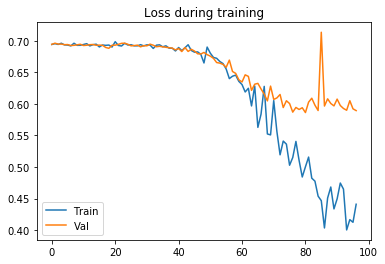

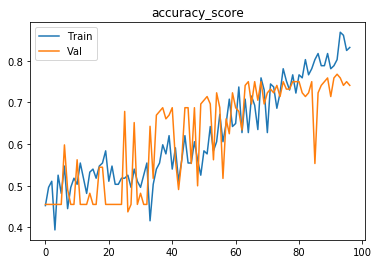

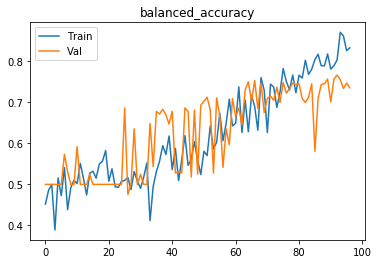

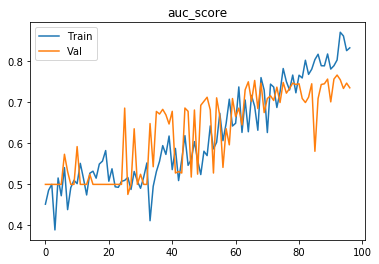

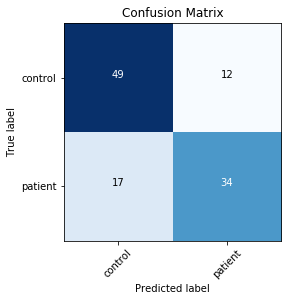

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 238997
[0,    10] loss: 0.69331
Time elapsed: 0h:0m:2s
train accuracy_score: 48.91 %
train balanced_accuracy: 48.24 %
train auc_score: 48.24 %
val accuracy_score: 53.57 %
val balanced_accuracy: 49.34 %
val auc_score: 49.34 %
Val loss: 0.693034
[1,    10] loss: 0.69276
Time elapsed: 0h:0m:6s
train accuracy_score: 53.28 %
train balanced_accuracy: 53.68 %
train auc_score: 53.68 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691853
[2,    10] loss: 0.69526
Time elapsed: 0h:0m:10s
train accuracy_score: 46.72 %
train balanced_accuracy: 47.19 %
train auc_score: 47.19 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691877
[3,    10] loss: 0.69246
Time elapsed: 0h:0m:13s
train accuracy_score: 51.82 %
train balanced_accuracy: 51.80 %
train auc_score: 51.80 %
val accuracy_score: 

[34,    10] loss: 0.68553
Time elapsed: 0h:2m:16s
train accuracy_score: 54.74 %
train balanced_accuracy: 54.21 %
train auc_score: 54.21 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696378
[35,    10] loss: 0.68975
Time elapsed: 0h:2m:20s
train accuracy_score: 52.55 %
train balanced_accuracy: 51.94 %
train auc_score: 51.94 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693101
[36,    10] loss: 0.69425
Time elapsed: 0h:2m:24s
train accuracy_score: 52.55 %
train balanced_accuracy: 52.48 %
train auc_score: 52.48 %
val accuracy_score: 66.96 %
val balanced_accuracy: 64.69 %
val auc_score: 64.69 %
Val loss: 0.689673
[37,    10] loss: 0.69355
Time elapsed: 0h:2m:28s
train accuracy_score: 52.55 %
train balanced_accuracy: 52.42 %
train auc_score: 52.42 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.692099
[38,    10] loss: 0.69364
Time elapsed: 0h:2

val accuracy_score: 58.93 %
val balanced_accuracy: 55.71 %
val auc_score: 55.71 %
Val loss: 0.661109
[69,    10] loss: 0.63348
Time elapsed: 0h:4m:34s
train accuracy_score: 63.50 %
train balanced_accuracy: 63.71 %
train auc_score: 63.71 %
val accuracy_score: 71.43 %
val balanced_accuracy: 70.56 %
val auc_score: 70.56 %
Val loss: 0.656781
[70,    10] loss: 0.62835
Time elapsed: 0h:4m:38s
train accuracy_score: 66.42 %
train balanced_accuracy: 66.41 %
train auc_score: 66.41 %
val accuracy_score: 67.86 %
val balanced_accuracy: 66.47 %
val auc_score: 66.47 %
Val loss: 0.651276
[71,    10] loss: 0.65911
Time elapsed: 0h:4m:42s
train accuracy_score: 61.31 %
train balanced_accuracy: 60.99 %
train auc_score: 60.99 %
val accuracy_score: 67.86 %
val balanced_accuracy: 65.99 %
val auc_score: 65.99 %
Val loss: 0.648979
[72,    10] loss: 0.66196
Time elapsed: 0h:4m:46s
train accuracy_score: 65.69 %
train balanced_accuracy: 65.92 %
train auc_score: 65.92 %
val accuracy_score: 67.86 %
val balanced_acc

[103,    10] loss: 0.47920
Time elapsed: 0h:6m:49s
train accuracy_score: 76.64 %
train balanced_accuracy: 76.57 %
train auc_score: 76.57 %
val accuracy_score: 73.21 %
val balanced_accuracy: 72.52 %
val auc_score: 72.52 %
Val loss: 0.575588
[104,    10] loss: 0.49240
Time elapsed: 0h:6m:53s
train accuracy_score: 76.64 %
train balanced_accuracy: 76.47 %
train auc_score: 76.47 %
val accuracy_score: 73.21 %
val balanced_accuracy: 71.39 %
val auc_score: 71.39 %
Val loss: 0.586648
[105,    10] loss: 0.46455
Time elapsed: 0h:6m:57s
train accuracy_score: 81.02 %
train balanced_accuracy: 81.01 %
train auc_score: 81.01 %
val accuracy_score: 73.21 %
val balanced_accuracy: 71.39 %
val auc_score: 71.39 %
Val loss: 0.583484
[106,    10] loss: 0.47058
Time elapsed: 0h:7m:1s
train accuracy_score: 74.45 %
train balanced_accuracy: 74.52 %
train auc_score: 74.52 %
val accuracy_score: 71.43 %
val balanced_accuracy: 70.72 %
val auc_score: 70.72 %
Val loss: 0.564382
[107,    10] loss: 0.47464
Time elapsed: 

val accuracy_score: 75.00 %
val balanced_accuracy: 73.35 %
val auc_score: 73.35 %
Val loss: 0.578603
[138,    10] loss: 0.33816
Time elapsed: 0h:9m:8s
train accuracy_score: 86.86 %
train balanced_accuracy: 86.89 %
train auc_score: 86.89 %
val accuracy_score: 77.68 %
val balanced_accuracy: 76.29 %
val auc_score: 76.29 %
Val loss: 0.541457
[139,    10] loss: 0.38673
Time elapsed: 0h:9m:12s
train accuracy_score: 83.94 %
train balanced_accuracy: 83.81 %
train auc_score: 83.81 %
val accuracy_score: 75.89 %
val balanced_accuracy: 74.33 %
val auc_score: 74.33 %
Val loss: 0.555470
[140,    10] loss: 0.38401
Time elapsed: 0h:9m:16s
train accuracy_score: 85.40 %
train balanced_accuracy: 85.55 %
train auc_score: 85.55 %
val accuracy_score: 77.68 %
val balanced_accuracy: 76.45 %
val auc_score: 76.45 %
Val loss: 0.534149
[141,    10] loss: 0.39636
Time elapsed: 0h:9m:20s
train accuracy_score: 83.94 %
train balanced_accuracy: 83.93 %
train auc_score: 83.93 %
val accuracy_score: 75.89 %
val balanced_

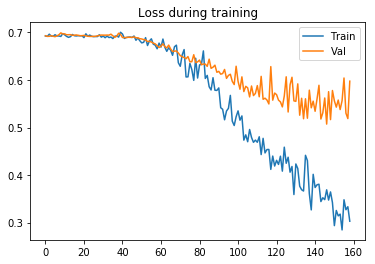

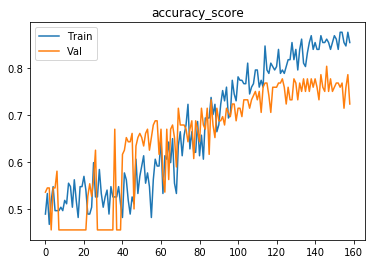

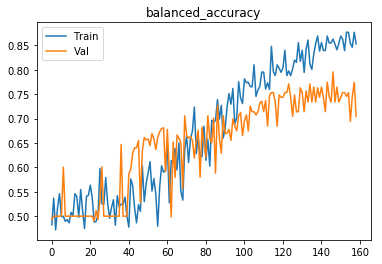

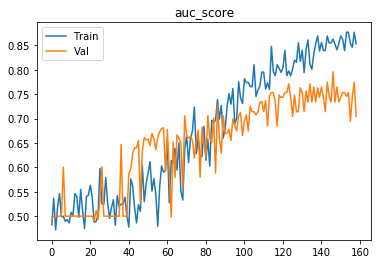

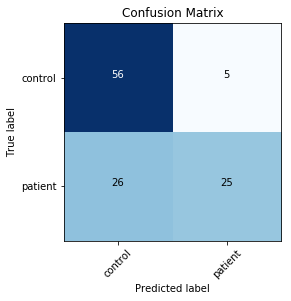

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 499845
[0,    10] loss: 0.69579
[0,    20] loss: 0.69750
Time elapsed: 0h:0m:4s
train accuracy_score: 45.26 %
train balanced_accuracy: 46.11 %
train auc_score: 46.11 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691087
[1,    10] loss: 0.69274
[1,    20] loss: 0.70109
Time elapsed: 0h:0m:10s
train accuracy_score: 49.64 %
train balanced_accuracy: 50.39 %
train auc_score: 50.39 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691419
[2,    10] loss: 0.69614
[2,    20] loss: 0.69804
Time elapsed: 0h:0m:17s
train accuracy_score: 47.45 %
train balanced_accuracy: 46.88 %
train auc_score: 46.88 %
val accuracy_score: 48.21 %
val balanced_accuracy: 52.30 %
val auc_score: 52.30 %
Val loss: 0.693342
[3,    10] loss: 0.69672
[3,    20] loss: 0.70071
Time elapsed: 0h:0m:23s
train ac

val accuracy_score: 72.32 %
val balanced_accuracy: 70.57 %
val auc_score: 70.57 %
Val loss: 0.669894
[31,    10] loss: 0.65530
[31,    20] loss: 0.66680
Time elapsed: 0h:3m:24s
train accuracy_score: 62.77 %
train balanced_accuracy: 63.35 %
train auc_score: 63.35 %
val accuracy_score: 66.07 %
val balanced_accuracy: 67.25 %
val auc_score: 67.25 %
Val loss: 0.667583
[32,    10] loss: 0.61533
[32,    20] loss: 0.62266
Time elapsed: 0h:3m:30s
train accuracy_score: 73.72 %
train balanced_accuracy: 73.39 %
train auc_score: 73.39 %
val accuracy_score: 72.32 %
val balanced_accuracy: 71.54 %
val auc_score: 71.54 %
Val loss: 0.638971
[33,    10] loss: 0.66321
[33,    20] loss: 0.69330
Time elapsed: 0h:3m:36s
train accuracy_score: 62.04 %
train balanced_accuracy: 62.03 %
train auc_score: 62.03 %
val accuracy_score: 74.11 %
val balanced_accuracy: 73.34 %
val auc_score: 73.34 %
Val loss: 0.636814
[34,    10] loss: 0.63457
[34,    20] loss: 0.67146
Time elapsed: 0h:3m:43s
train accuracy_score: 62.77 

val accuracy_score: 77.68 %
val balanced_accuracy: 77.26 %
val auc_score: 77.26 %
Val loss: 0.565303
[62,    10] loss: 0.25482
[62,    20] loss: 0.25775
Time elapsed: 0h:6m:43s
train accuracy_score: 91.24 %
train balanced_accuracy: 91.20 %
train auc_score: 91.20 %
val accuracy_score: 76.79 %
val balanced_accuracy: 76.12 %
val auc_score: 76.12 %
Val loss: 0.529757
[63,    10] loss: 0.24528
[63,    20] loss: 0.30882
Time elapsed: 0h:6m:49s
train accuracy_score: 86.13 %
train balanced_accuracy: 86.14 %
train auc_score: 86.14 %
val accuracy_score: 79.46 %
val balanced_accuracy: 79.06 %
val auc_score: 79.06 %
Val loss: 0.549572
[64,    10] loss: 0.29941
[64,    20] loss: 0.29828
Time elapsed: 0h:6m:56s
train accuracy_score: 86.86 %
train balanced_accuracy: 86.86 %
train auc_score: 86.86 %
val accuracy_score: 75.89 %
val balanced_accuracy: 74.49 %
val auc_score: 74.49 %
Val loss: 0.611698
Early stopping in epoch 65
Total time elapsed: 0h:6m:57s
Writing model to disk...
Best result during tra

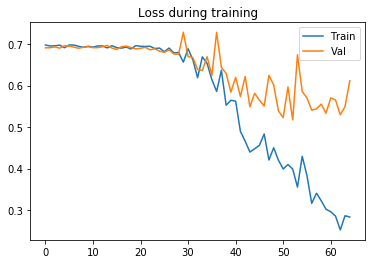

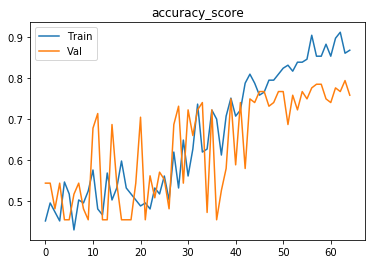

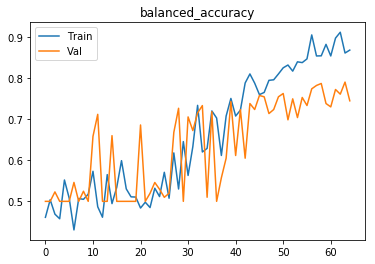

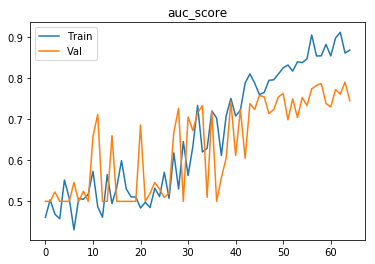

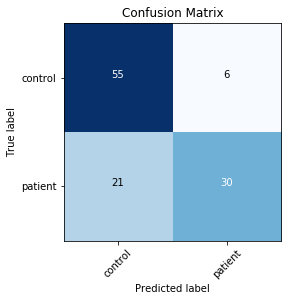

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.69544
Time elapsed: 0h:0m:4s
train accuracy_score: 50.36 %
train balanced_accuracy: 49.29 %
train auc_score: 49.29 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694050
[1,    10] loss: 0.69751
Time elapsed: 0h:0m:10s
train accuracy_score: 48.18 %
train balanced_accuracy: 48.58 %
train auc_score: 48.58 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694896
[2,    10] loss: 0.69335
Time elapsed: 0h:0m:16s
train accuracy_score: 55.47 %
train balanced_accuracy: 54.70 %
train auc_score: 54.70 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695920
[3,    10] loss: 0.69445
Time elapsed: 0h:0m:23s
train accuracy_score: 49.64 %
train balanced_accuracy: 49.18 %
train auc_score: 49.18 %
val accuracy_score

[34,    10] loss: 0.64012
Time elapsed: 0h:3m:35s
train accuracy_score: 59.85 %
train balanced_accuracy: 59.75 %
train auc_score: 59.75 %
val accuracy_score: 62.50 %
val balanced_accuracy: 59.63 %
val auc_score: 59.63 %
Val loss: 0.644726
[35,    10] loss: 0.60185
Time elapsed: 0h:3m:41s
train accuracy_score: 71.53 %
train balanced_accuracy: 71.66 %
train auc_score: 71.66 %
val accuracy_score: 53.57 %
val balanced_accuracy: 56.57 %
val auc_score: 56.57 %
Val loss: 0.671736
[36,    10] loss: 0.63300
Time elapsed: 0h:3m:47s
train accuracy_score: 63.50 %
train balanced_accuracy: 63.58 %
train auc_score: 63.58 %
val accuracy_score: 67.86 %
val balanced_accuracy: 66.31 %
val auc_score: 66.31 %
Val loss: 0.620719
[37,    10] loss: 0.57052
Time elapsed: 0h:3m:54s
train accuracy_score: 72.26 %
train balanced_accuracy: 72.19 %
train auc_score: 72.19 %
val accuracy_score: 64.29 %
val balanced_accuracy: 61.59 %
val auc_score: 61.59 %
Val loss: 0.682533
[38,    10] loss: 0.62511
Time elapsed: 0h:4

val accuracy_score: 76.79 %
val balanced_accuracy: 76.44 %
val auc_score: 76.44 %
Val loss: 0.613673
[69,    10] loss: 0.20184
Time elapsed: 0h:7m:13s
train accuracy_score: 89.78 %
train balanced_accuracy: 89.84 %
train auc_score: 89.84 %
val accuracy_score: 75.89 %
val balanced_accuracy: 74.82 %
val auc_score: 74.82 %
Val loss: 0.616265
[70,    10] loss: 0.15813
Time elapsed: 0h:7m:19s
train accuracy_score: 91.97 %
train balanced_accuracy: 92.01 %
train auc_score: 92.01 %
val accuracy_score: 79.46 %
val balanced_accuracy: 78.90 %
val auc_score: 78.90 %
Val loss: 0.596430
[71,    10] loss: 0.16840
Time elapsed: 0h:7m:25s
train accuracy_score: 94.16 %
train balanced_accuracy: 94.16 %
train auc_score: 94.16 %
val accuracy_score: 73.21 %
val balanced_accuracy: 71.39 %
val auc_score: 71.39 %
Val loss: 0.831348
Early stopping in epoch 72
Total time elapsed: 0h:7m:28s
Writing model to disk...
Best result during training: 0.79. Saving model..
Finished inner fold.


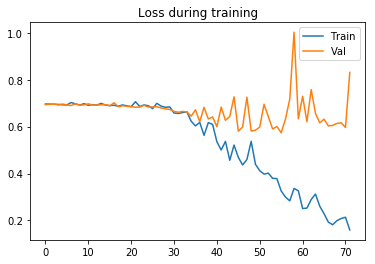

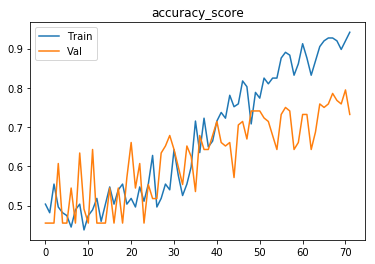

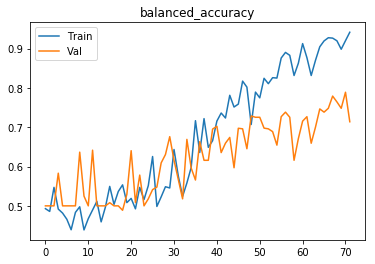

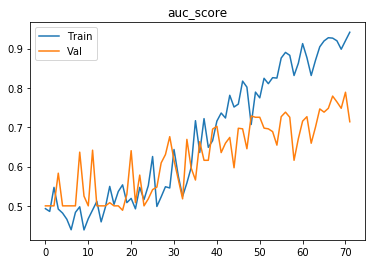

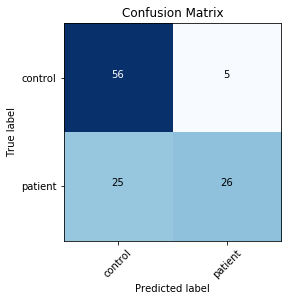

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 499845
[0,    10] loss: 0.69763
[0,    20] loss: 0.69806
Time elapsed: 0h:0m:4s
train accuracy_score: 45.99 %
train balanced_accuracy: 46.09 %
train auc_score: 46.09 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697154
[1,    10] loss: 0.70120
[1,    20] loss: 0.69485
Time elapsed: 0h:0m:10s
train accuracy_score: 45.99 %
train balanced_accuracy: 45.26 %
train auc_score: 45.26 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.699240
[2,    10] loss: 0.68554
[2,    20] loss: 0.70786
Time elapsed: 0h:0m:17s
train accuracy_score: 51.09 %
train balanced_accuracy: 50.22 %
train auc_score: 50.22 %
val accuracy_score: 54.46 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691187
[3,    10] loss: 0.69795
[3,    20] loss: 0.69293
Time elapsed: 0h:0m:23s
train a

val accuracy_score: 58.04 %
val balanced_accuracy: 59.71 %
val auc_score: 59.71 %
Val loss: 0.645466
[31,    10] loss: 0.57511
[31,    20] loss: 0.58309
Time elapsed: 0h:3m:22s
train accuracy_score: 70.80 %
train balanced_accuracy: 70.72 %
train auc_score: 70.72 %
val accuracy_score: 74.11 %
val balanced_accuracy: 73.98 %
val auc_score: 73.98 %
Val loss: 0.600110
[32,    10] loss: 0.52017
[32,    20] loss: 0.65198
Time elapsed: 0h:3m:28s
train accuracy_score: 71.53 %
train balanced_accuracy: 71.50 %
train auc_score: 71.50 %
val accuracy_score: 46.43 %
val balanced_accuracy: 50.02 %
val auc_score: 50.02 %
Val loss: 0.713072
[33,    10] loss: 0.60469
[33,    20] loss: 0.52538
Time elapsed: 0h:3m:35s
train accuracy_score: 69.34 %
train balanced_accuracy: 69.36 %
train auc_score: 69.36 %
val accuracy_score: 68.75 %
val balanced_accuracy: 66.49 %
val auc_score: 66.49 %
Val loss: 0.643845
[34,    10] loss: 0.55419
[34,    20] loss: 0.48436
Time elapsed: 0h:3m:41s
train accuracy_score: 72.26 

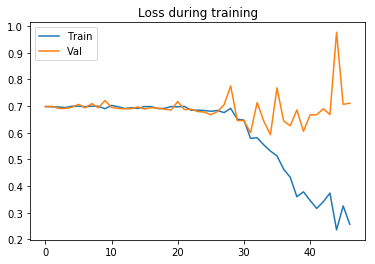

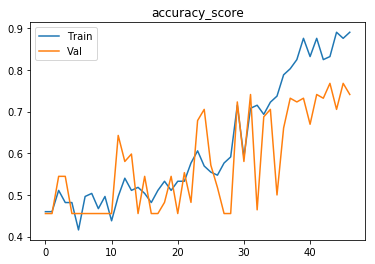

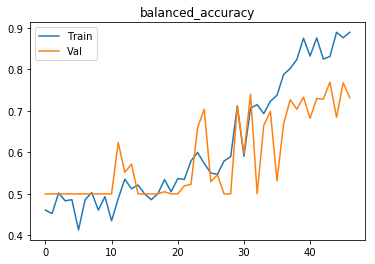

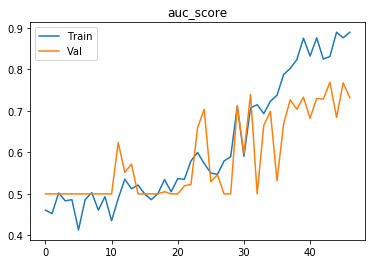

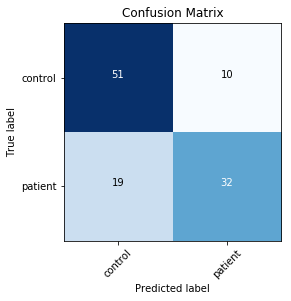

Finished outer fold.
{'final_acc': 0.7449373191899712, 'best_acc': 0.7905818064930891, 'final_iter': 65, 'best_iter': 64, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}
################################
################################
All accuracies: [0.8133356790992259, 0.7749824067558059, 0.7922237860661504, 0.8305770584095707, 0.8219563687543983, 0.8159090909090909, 0.7147727272727273, 0.8443181818181817, 0.9102272727272727, 0.7602272727272728, 0.6988142292490118, 0.5181818181818182, 0.6565217391304348, 0.7041501976284585, 0.5986166007905138, 0.7539473684210528, 0.6802631578947369, 0.7385964912280703, 0.8149122807017544, 0.8390350877192982, 0.7995520716685329, 0.8409854423292273, 0.8165360209033221, 0.8465845464725643, 0.8064576334453155, 0.8050401978973407, 0.5, 0.8656462585034014, 0.787569573283859, 0.7388682745825603, 0.8001984126984127, 0.7333333333333335, 0.8547619047619048, 0.8251984126984127, 0.8343253968253966, 0.69139194139

In [17]:
fold_metric, models = run(net=None, data=None,
                  k_folds=-1,
                  callbacks=None,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=None
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [18]:
5/0

ZeroDivisionError: division by zero

# Start inference

In [19]:
training_res = [{'final_acc': 0.8305770584095707, 'best_acc': 0.8455313159746658, 'final_iter': 80, 'best_iter': 62, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3}, {'final_acc': 0.9102272727272727, 'best_acc': 0.928409090909091, 'final_iter': 79, 'best_iter': 67, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 3}, {'final_acc': 0.7041501976284585, 'best_acc': 0.7608695652173914, 'final_iter': 117, 'best_iter': 115, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}, {'final_acc': 0.8390350877192982, 'best_acc': 0.8592105263157894, 'final_iter': 106, 'best_iter': 102, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 4}, {'final_acc': 0.8465845464725643, 'best_acc': 0.925531914893617, 'final_iter': 99, 'best_iter': 98, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}, {'final_acc': 0.8656462585034014, 'best_acc': 0.8837353123067409, 'final_iter': 92, 'best_iter': 55, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 2}, {'final_acc': 0.8547619047619048, 'best_acc': 0.8865079365079364, 'final_iter': 113, 'best_iter': 101, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}, {'final_acc': 0.8021978021978023, 'best_acc': 0.8044871794871795, 'final_iter': 61, 'best_iter': 56, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}, {'final_acc': 0.875, 'best_acc': 0.8833333333333334, 'final_iter': 107, 'best_iter': 97, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1}, {'final_acc': 0.7449373191899712, 'best_acc': 0.7905818064930891, 'final_iter': 65, 'best_iter': 64, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}]

In [20]:
print(len(training_res))
res_df = pd.DataFrame(training_res)

10


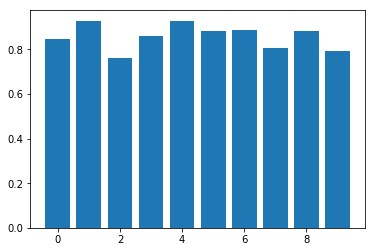

0.8568197981438834
0.8273117447610245


In [21]:
plt.bar(np.arange(len(res_df["best_acc"])), res_df["best_acc"])
plt.show()
print(np.mean(res_df["best_acc"]))
print(np.mean(res_df["final_acc"]))

In [22]:
print(np.mean(res_df["final_iter"]))

91.9


In [23]:
print(res_df["final_iter"])

0     80
1     79
2    117
3    106
4     99
5     92
6    113
7     61
8    107
9     65
Name: final_iter, dtype: int64


### Using best model checkpoint for inference

In [24]:
metrics = []
random_states = np.arange(20, 30) # important to use the same values as during training

for outer_fold, r in enumerate(random_states):
    print("Outer fold {}".format(outer_fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    train_res = training_res[outer_fold]
    model_dir = os.path.join(output_dir,"outer_{}_inner_{}_cv_fold_{}_BEST_ITERATION.h5".format(outer_fold, train_res["inner_fold_idx"], outer_fold * 5 + train_res["inner_fold_idx"]))
    model_name = train_res["params"]["model"]
    net = pick_model(model_name)
    
    net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net = net.cuda(gpu)
    net.eval()
    
    test_h5 = h5py.File(train_data_path.replace("train", "holdout") + str(r) + ".h5", 'r')

    X_test, y_test = np.array(test_h5['X']), np.array(test_h5['y'])

    # dataset overview
    print("# of patients {}, # of healthy controls {}".format(np.sum(y_test), len(y_test)-np.sum(y_test)))

    print(len(y_test))

    if zero_one_normalize:
        intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
        adni_data_test= ADNIDataset(X_test, y_test, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    else:
        adni_data_test = ADNIDataset(X_test, y_test, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

    test_h5.close()
    
    test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=False)
    
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Outer fold 0
# of patients 65, # of healthy controls 98
163
Bal. accuracy 70.361 %
ROC AUC Score 78.148 %
Sensitivity 81.538 %
Specificity 59.184 %
Outer fold 1
# of patients 77, # of healthy controls 99
176
Bal. accuracy 83.261 %
ROC AUC Score 89.597 %
Sensitivity 76.623 %
Specificity 89.899 %
Outer fold 2
# of patients 78, # of healthy controls 100
178
Bal. accuracy 83.038 %
ROC AUC Score 93.308 %
Sensitivity 73.077 %
Specificity 93.000 %
Outer fold 3
# of patients 70, # of healthy controls 93
163
Bal. accuracy 86.052 %
ROC AUC Score 91.521 %
Sensitivity 82.857 %
Specificity 89.247 %
Outer fold 4
# of patients 73, # of healthy controls 96
169
Bal. accuracy 75.557 %
ROC AUC Score 82.534 %
Sensitivity 69.863 %
Specificity 81.250 %
Outer fold 5
# of patients 73, # of healthy controls 97
170
Bal. accuracy 85.235 %
ROC AUC Score 92.120 %
Sensitivity 93.151 %
Specificity 77.320 %
Outer fold 6
# of patients 68, # of healthy controls 90
158
Bal. accuracy 65.686 %
ROC AUC Score 69.853 %
Sensi